In [1]:
#Jump to: Maximizing/Matching CONTROL
 #or: Maximizing/Matching SOCIAL  

import csv
import pandas as pd
import numpy as np
import glob
import matplotlib
import scipy as sp
from matplotlib import pyplot as plt
from itertools import cycle, islice
from scipy import stats

import seaborn as sns

In [2]:
'''
This notebook is for analyzing behavior data in the social multi-armed bandit (SMAB) paradigm.
It uses Pandas dataframes (https://pandas.pydata.org/docs/getting_started/index.html#getting-started).
The 's' datasets are single-player sessions from SMAB3 and the 'j' datasets are multi-player sessions from SMAB3.
The 'c' datasets are single-player sessions from SMAB4 and the 'm' datasets are multi-player sessions from SMAB4.

Updated by Bar Y. 8/4/20
'''

"\nThis notebook is for analyzing behavior data in the social multi-armed bandit (SMAB) paradigm.\nIt uses Pandas dataframes (https://pandas.pydata.org/docs/getting_started/index.html#getting-started).\nThe 's' datasets are single-player sessions from SMAB3 and the 'j' datasets are multi-player sessions from SMAB3.\nThe 'c' datasets are single-player sessions from SMAB4 and the 'm' datasets are multi-player sessions from SMAB4.\n\nUpdated by Bar Y. 8/4/20\n"

In [3]:
'''
These functions import csv files into pandas dataframes and rename the columns.
input: filename of the csv file to import; the path needs to be included, as well
output: pandas dataframe
'''


def organize_trial_by_trial(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward", 6:"time", 7:"P1 score", 8:"P2 score"})
    #drops first 20 trials of game 1
    #remove if you want to analyze the whole session
    #df = df[40:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    df = df.drop(['reward'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df



#0 means "next" button
#need to exclude zero?

def organize_trial_by_trial_floatclick(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"type", 1:"game number", 2:"trial", 3:"player", 4:"arm", 5:"probability", 6:"P1 score", 7:"P2 score", 8:""})
    #have 402 so need to restrict
    #df = df[1:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    df = df.drop(['type'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df



def organize_trial_by_trial_300(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"type", 1:"game number", 2:"trial", 3:"player", 4:"arm", 5:"probability", 6:"reward", 7:"time", 8:"P1 score", 9:"P2 score"})
    #df = df[40:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    df = df.drop(['type', 'reward'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df

#use this function for hand coded game data files 
def organize_trial_by_trial_hand_code(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    #remove first row with column headings
    df = df.drop(df.index[0])
    #convert values to numbers
    df = df.apply(pd.to_numeric)
    #add column headings
    df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"P1 score", 6:"P2 score"})
    df.head()
    
    return df

# In[6]:

'''
This function returns the score for game 1 and game 2. call_get_score can be used to call this function.
'''
def get_score(df, player_number, game_number):
    if game_number == 1:
        row = 199
    elif game_number == 2:
        row = 399
    if player_number == 1:
        column = 'P1 score'
    elif player_number == 2:
        column = 'P2 score'
    score = df.loc[row, column]
    return score

'''Here we get the score at trial 50 of both games'''
def get_score_at_50(df, player_number, game_number):
    if game_number == 1:
        row = 99
    elif game_number == 2:
        row = 300
    if player_number == 1:
        column = 'P1 score'
    elif player_number == 2:
        column = 'P2 score'
    score = df.loc[row, column]
    return score

In [4]:
#create a dataframes for scores
scores = pd.DataFrame(columns=['s_g1','s_g2','c_g1','c_g2', 'j_g1', 'j_g2', 'm_g1', 'm_g2'])


# In[8]:


#version is 's' for single player and 'j' for joint
def call_get_score(df, version):
    p1_g1 = get_score(df, 1, 1)
    p1_g2 = get_score(df, 1, 2)
    p1_score_diff = p1_g2 - p1_g1
    
    p1_g1_50 = get_score_at_50(df, 1, 1)
    p1_g2_50 = get_score_at_50(df, 1, 2)
    
    if version == 'j' or version == 'm':
        p1_g1 = get_score(df, 1, 1)
        p1_g2 = get_score(df, 1, 2)
        p1_score_diff = p1_g2 - p1_g1
        
        p1_g1_50 = get_score_at_50(df, 1, 1)
        p1_g2_50 = get_score_at_50(df, 1, 2)
        
        p2_g1 = get_score(df, 2, 1)
        p2_g2 = get_score(df, 2, 2)
        p2_score_diff = p2_g2 - p2_g1
        
        p2_g1_50 = get_score_at_50(df, 2, 1)
        p2_g2_50 = get_score_at_50(df, 2, 2)
        return p1_g1, p1_g2, p2_g1, p2_g2, p1_score_diff, p2_score_diff, p1_g1_50,p1_g2_50, p2_g1_50, p2_g2_50
    
    ''''if version == 'm':
        p1_g1 = get_score(df, 1, 1)
        p1_g2 = get_score(df, 1, 2)
        p1_score_diff = p1_g2 - p1_g1
        p2_g1 = get_score(df, 2, 1)
        p2_g2 = get_score(df, 2, 2)
        p2_score_diff = p2_g2 - p2_g1
        return p1_g1, p1_g2, p2_g1, p2_g2, p1_score_diff, p2_score_diff'''
    return p1_g1, p1_g2, p1_score_diff, p1_g1_50, p1_g2_50


# In[9]:


#separate data frames for p1 and p2 
def separate_df(df, version):
    #df.set_index(df['trial'])
    df_p1 = df[df['player'] == 1]
    df_p1_g1 = df_p1[df['game number'] == 1]
    df_p1_g2 = df_p1[df['game number'] == 2]
    
    #remove trials for g1
    #df_p1_g1 = df_p1_g1[20:40]
    #remove trials for g2
    #df_p1_g2 = df_p1_g2[20:40]
    
    if version == 's':
        return df_p1_g1, df_p1_g2
    if version == 'c':
        return df_p1_g1, df_p1_g2
    df_p2 = df[df['player'] ==2 ]
    df_p2_g1 = df_p2[df['game number'] == 1]
    df_p2_g2 = df_p2[df['game number'] == 2]
    
    #remove trials for g1
   # df_p2_g1 = df_p2_g1[20:40]
    #remove trials for g2
    #df_p2_g2= df_p2_g2[20:40]
    
    return df_p1_g1, df_p1_g2, df_p2_g1, df_p2_g2


# In[10]:


#notes from Binghong:

#see reshape to restrict csv file size
#https://urldefense.com/v3/__https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.reshape.html__;!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX9KXz57to$ 

#https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html__;!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX9PslIsfw$ 
#https://urldefense.com/v3/__https://www.w3schools.com/python/numpy_array_shape.asp__;!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX9xnFVd7o$ 

#https://urldefense.com/v3/__https://stackoverflow.com/__;!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX9koWV6hk$ 

#use drop to filter data frames or cut
#Df=df[20:]

#https://urldefense.com/v3/__https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html__;!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX9a46rcc8$ 

#drop columns, python, df


# # ANOVA

# In[11]:

#Note from Bar 7/23/20: Not sure what pingouin is?
#import pingouin as pg

# SMAB4 Hand Coding

# SMAB3 Single Player Analysis

In [5]:
'''
Here, we load all of the csv files into pandas dataframes using organize_trial_by_trial and get the game 1 and 2 scores using 
call_get_score.'''

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s01_gamedata.csv')
s01 = df
s01_p1_g1_score,s01_p1_g2_score,s01_score_diff,s01_p1_g1_50,s01_p1_g2_50 = call_get_score(s01, 's')
s01.head()

#in the s files, p2 is the confederate
#df = organize_trial_by_trial('data/s02_gamedata.csv')
#s02 = df
#s02_p1_g1_score = get_score(s02, 1, 1)
#s02.head()


#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s03_gamedata.csv')
s03 = df
s03_p1_g1_score,s03_p1_g2_score,s03_score_diff,s03_p1_g1_50,s03_p1_g2_50 = call_get_score(s03, 's')
s03.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s05_gamedata.csv')
s05 = df
s05_p1_g1_score,s05_p1_g2_score,s05_score_diff, s05_p1_g1_50,s05_p1_g2_50 = call_get_score(s05, 's')
s05.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s06_gamedata.csv')
s06 = df
s06_p1_g1_score,s06_p1_g2_score,s06_score_diff, s06_p1_g1_50,s06_p1_g2_50 = call_get_score(s06, 's')
s06.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s07_gamedata.csv')
s07 = df
s07_p1_g1_score,s07_p1_g2_score,s07_score_diff, s07_p1_g1_50,s07_p1_g2_50 = call_get_score(s07, 's')
s07.head()

pd.set_option('display.max_columns', None)  

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s08_gamedata.csv')
s08 = df
s08_p1_g1_score,s08_p1_g2_score,s08_score_diff, s08_p1_g1_50,s08_p1_g2_50 = call_get_score(s08, 's')
s08.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s09_gamedata.csv')
s09 = df
s09_p1_g1_score,s09_p1_g2_score,s09_score_diff, s09_p1_g1_50,s09_p1_g2_50 = call_get_score(s09, 's')
s09.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/s11_gamedata.csv')
s11 = df
s11_p1_g1_score,s11_p1_g2_score,s11_score_diff,s11_p1_g1_50,s11_p1_g2_50 = call_get_score(s11, 's')
s11.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s12_gamedata.csv')
s12 = df
s12_p1_g1_score,s12_p1_g2_score,s12_score_diff, s12_p1_g1_50,s12_p1_g2_50 = call_get_score(s12, 's')
s12.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/s15_gamedata.csv')
s15 = df
s15_p1_g1_score,s15_p1_g2_score,s15_score_diff,s15_p1_g1_50,s15_p1_g2_50 = call_get_score(s15, 's')
s15.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/s16_gamedata.csv')
s16 = df
s16_p1_g1_score,s16_p1_g2_score,s16_score_diff,s16_p1_g1_50,s16_p1_g2_50 = call_get_score(s16, 's')
s16.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s19_gamedata.csv')
s19 = df
s19_p1_g1_score,s19_p1_g2_score,s19_score_diff,s19_p1_g1_50,s19_p1_g2_50 = call_get_score(s19, 's')
s19.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/s17_gamedata.csv')
s17 = df
s17_p1_g1_score,s17_p1_g2_score,s17_score_diff,s17_p1_g1_50,s17_p1_g2_50 = call_get_score(s17, 's')
s17.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/s20_gamedata.csv')
s20 = df
s20_p1_g1_score,s20_p1_g2_score,s20_score_diff, s20_p1_g1_50,s20_p1_g2_50= call_get_score(s20, 's')
s20.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,1,90,0,0
1,1,1,2,0,90,1,0
2,1,2,1,2,60,1,1
3,1,2,2,0,90,2,1
4,1,3,1,3,30,2,2


In [202]:
reader = csv.reader( open('data/c06_gamedata.csv'))
game_data = [row for row in reader]
df = pd.DataFrame(np.array(game_data))
df = df.T

In [203]:
df

,0,1,2,3,4,5,6,7,8
0,1,1,1,3,60,0,10.177147,0,0
1,1,1,2,3,30,0,4.8996644,0,0
2,1,2,1,1,30,0,4.235981,0,0
3,1,2,2,3,30,0,3.6762552,0,0
4,1,3,1,3,60,1,5.3344603,1,0
5,1,3,2,3,30,0,3.1475019,1,0
6,1,4,1,2,90,0,5.2215109,1,0
7,1,4,2,3,30,0,3.8531661,1,0
8,1,5,1,3,60,0,4.9186592,1,0
9,1,5,2,3,30,0,10.115174,1,0


In [6]:
#organize_trial_by_trial_floatclick is missing 'time'

In [7]:
'''
Here, we create a dataframe of all of the scores and score differences between game 1 and 2'''

#list out all the scores in game 1 by participant
s_scores_1 = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'], 'score_1':
     [s01_p1_g1_score, s03_p1_g1_score, s05_p1_g1_score,
      s06_p1_g1_score, s07_p1_g1_score, s08_p1_g1_score, s09_p1_g1_score, s11_p1_g1_score, s12_p1_g1_score, s15_p1_g1_score, s16_p1_g1_score, s17_p1_g1_score, s19_p1_g1_score, s20_p1_g1_score]})
#to prevent an extra column that numbers each row:
s_scores_1.set_index('participant', inplace=True, drop=True)

#list out all the scores in game 2 by participant
s_scores_2 = pd.DataFrame({'participant':['s01', 's03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'], 'score_2':
    [s01_p1_g2_score, s03_p1_g2_score, s05_p1_g2_score, 
s06_p1_g2_score, s07_p1_g2_score, s08_p1_g2_score, s09_p1_g2_score, s11_p1_g2_score, s12_p1_g2_score, s15_p1_g2_score, s16_p1_g2_score, s17_p1_g2_score, s19_p1_g2_score, s20_p1_g2_score]})

#to prevent an extra column that numbers each row:
s_scores_2.set_index('participant', inplace=True, drop=True)


#list out all the scores in game 1 by participant
s_scores_1_50 = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'], 'score_1_50':
     [s01_p1_g1_50, s03_p1_g1_50, s05_p1_g1_50,
      s06_p1_g1_50, s07_p1_g1_50, s08_p1_g1_50, s09_p1_g1_50, s11_p1_g1_50, s12_p1_g1_50, s15_p1_g1_50, s16_p1_g1_50, s17_p1_g1_50, s19_p1_g1_50, s20_p1_g1_50]})
#to prevent an extra column that numbers each row:
s_scores_1_50.set_index('participant', inplace=True, drop=True)

#list out all the scores in game 2 by participant
s_scores_2_50 = pd.DataFrame({'participant':['s01', 's03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'], 'score_2_50':
    [s01_p1_g2_50, s03_p1_g2_50, s05_p1_g2_50, 
s06_p1_g2_50, s07_p1_g2_50, s08_p1_g2_50, s09_p1_g2_50, s11_p1_g2_50, s12_p1_g2_50, s15_p1_g2_50, s16_p1_g2_50, s17_p1_g2_50, s19_p1_g2_50, s20_p1_g2_50]})
s_scores_2_50.set_index('participant', inplace=True, drop=True)

frames = [s_scores_1_50,s_scores_2_50,s_scores_1,s_scores_2]

In [8]:
s_scores_50 = s_scores_1_50.merge(s_scores_2_50,right_index=True,left_index=True)

In [9]:
s_scores = s_scores_1.merge(s_scores_2,right_index=True,left_index=True)

In [10]:
s_combo = s_scores_50.merge(s_scores,right_index=True,left_index=True)

In [11]:
s_combo

,score_1_50,score_2_50,score_1,score_2
participant,,,,
s01,26,36,60,74
s03,29,36,63,71
s05,46,42,77,88
s06,42,40,82,87
s07,30,30,63,68
s08,46,43,90,80
s09,30,33,65,70
s11,29,30,60,61
s12,40,43,83,86


"s_combo = pd.DataFrame({'participant':['s01', 's01', 's03', 's03','s05', 's05'\n                              's06', 's06','s07','s07','s08','s08','s09','s09', 's11', 's11', 's12', 's12', 's15', 's15', 's16', 's16', 's17', 's17', 's19', 's19', 's20', 's20'], 'score':\n     [s01_p1_g1_score, s01_p1_g2_score, s02_p1_g1_score, s03_p1_g1_score, s03_p1_g2_score, s05_p1_g1_score,\n      s05_p1_g2_score,s06_p1_g1_score,s06_p1_g2_score, s07_p1_g1_score,s07_p1_g2_score, s08_p1_g1_score,s08_p1_g2_score,\n      s09_p1_g1_score, s09_p1_g2_score, s11_p1_g1_score, s11_p1_g2_score, s12_p1_g1_score, s12_p1_g2_score, s15_p1_g1_score, s15_p1_g2_score, s16_p1_g1_score, s16_p1_g2_score, s17_p1_g1_score, s17_p1_g2_score, s19_p1_g1_score, s19_p1_g2_score, s20_p1_g1_score, s20_p1_g2_score]})\ns_combo.set_index('participant', inplace=True, drop=True)"

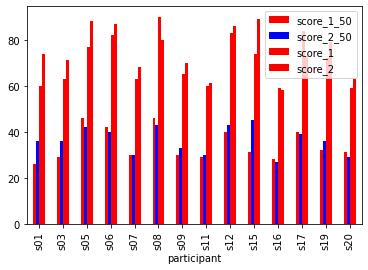

In [12]:
#unnecessary graph
#need to make g1 and g2 bars diff colors
colors = list(islice(cycle(['red','blue','red', 'red','blue','red','blue','red','blue','red','blue','red','blue','red','blue']),None,len(s_combo)))
#my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
s_combo_bar = s_combo.plot(kind='bar',color=colors)

'''s_combo = pd.DataFrame({'participant':['s01', 's01', 's03', 's03','s05', 's05'
                              's06', 's06','s07','s07','s08','s08','s09','s09', 's11', 's11', 's12', 's12', 's15', 's15', 's16', 's16', 's17', 's17', 's19', 's19', 's20', 's20'], 'score':
     [s01_p1_g1_score, s01_p1_g2_score, s02_p1_g1_score, s03_p1_g1_score, s03_p1_g2_score, s05_p1_g1_score,
      s05_p1_g2_score,s06_p1_g1_score,s06_p1_g2_score, s07_p1_g1_score,s07_p1_g2_score, s08_p1_g1_score,s08_p1_g2_score,
      s09_p1_g1_score, s09_p1_g2_score, s11_p1_g1_score, s11_p1_g2_score, s12_p1_g1_score, s12_p1_g2_score, s15_p1_g1_score, s15_p1_g2_score, s16_p1_g1_score, s16_p1_g2_score, s17_p1_g1_score, s17_p1_g2_score, s19_p1_g1_score, s19_p1_g2_score, s20_p1_g1_score, s20_p1_g2_score]})
s_combo.set_index('participant', inplace=True, drop=True)'''

,Game 1,Game 2
participant,,
s01,60,74
s03,63,71
s05,77,88
s06,82,87
s07,63,68
s08,90,80
s09,65,70
s11,60,61
s12,83,86


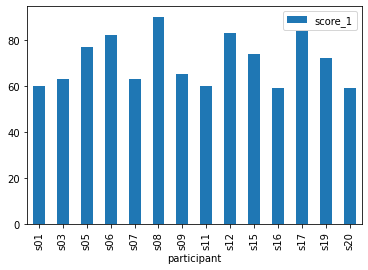

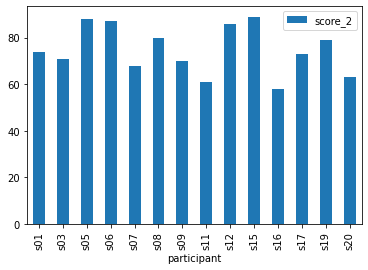

In [13]:
'''Here we plot the scores.'''

s_scores_1_bar = s_scores_1.plot.bar()

s_scores_2_bar = s_scores_2.plot.bar()

#merge both games by participant:
s_scores = pd.merge(s_scores_1, s_scores_2,on='participant')

#label columns
s_scores.columns=['Game 1','Game 2']

s_scores

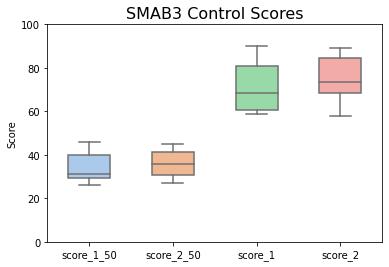

In [14]:
#make a boxplot of the scores in game 1 and game 2 
#s_scores_box = s_scores.boxplot(labels=['Game 1','Game 2'])
#plt.grid(b=None)
#plt.yticks(np.arange(50, 105, step=10))

s_scores_box = sns.boxplot( 
                 data=s_combo, order = ['score_1_50','score_2_50','score_1','score_2'],
                 width=0.5,
                 palette="pastel")
s_scores_box.axes.set_title("SMAB3 Control Scores",
                    fontsize=16)

plot_file_name="s_score_box.jpg"
 
plt.ylim(0, 100)
s_scores_box.axes.set(ylabel='Score')

# save as jpeg
s_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

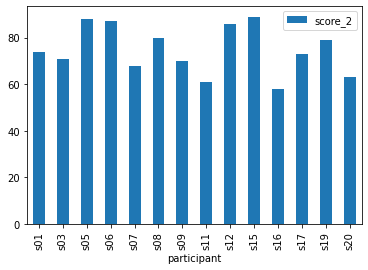

In [15]:
#get a p value comparing scores in game 1 to scores in game 2
s_scores_p = sp.stats.ttest_rel(s_scores['Game 1'],s_scores['Game 2'])


s_scores_p


s_scores_2_bar = s_scores_2.plot.bar()



#new_index = ('s01_g1','s01_g2','s02_g1','s03_g1','s03_g2','s05_g1','s05_g2', 
                               #'s06_g1','s06_g2','s07_g1','s07_g2','s08_g1','s08_g2','s09_g1','s09_g2')
#s_combo.index = new_index

In [16]:
'''Here we look at the means, standard deviations, and medians of the scores in games 1 and 2.'''

s_scores_1_mean = s_scores_1.mean()


s_scores_1_mean

score_1    70.785714
dtype: float64

In [17]:
s_scores_1_std = s_scores_1.std()


# In[52]:


s_scores_1_std


# In[53]:

score_1    10.864045
dtype: float64

In [18]:
s_scores_2_mean = s_scores_2.mean()


# In[54]:


s_scores_2_mean


# In[55]:

score_2    74.785714
dtype: float64

In [19]:
s_scores_2_std = s_scores_2.std()


# In[56]:


s_scores_2_std


# In[57]:

score_2    10.356555
dtype: float64

In [20]:
s_scores_med = s_scores.median()
s_scores_med

Game 1    68.5
Game 2    73.5
dtype: float64

In [21]:
'''Here we separate the dataframes of game 1 and game 2 for each subject.'''


s01_p1_g1, s01_p1_g2 = separate_df(s01, 's')




s01_p1_g2



s01_p1_g1, s01_p1_g2 = separate_df(s01, 's')
s03_p1_g1, s03_p1_g2 = separate_df(s03, 's')
s05_p1_g1, s05_p1_g2 = separate_df(s05, 's')
s06_p1_g1, s06_p1_g2 = separate_df(s06, 's')
s07_p1_g1, s07_p1_g2 = separate_df(s07, 's')
s08_p1_g1, s08_p1_g2 = separate_df(s08, 's')
s09_p1_g1, s09_p1_g2 = separate_df(s09, 's')
s11_p1_g1, s11_p1_g2 = separate_df(s11, 's')
s12_p1_g1, s12_p1_g2 = separate_df(s12, 's')
s15_p1_g1, s15_p1_g2 = separate_df(s15, 's')
s16_p1_g1, s16_p1_g2 = separate_df(s16, 's')
s17_p1_g1, s17_p1_g2 = separate_df(s17, 's')
s19_p1_g1, s19_p1_g2 = separate_df(s19, 's')
s20_p1_g1, s20_p1_g2 = separate_df(s20, 's')

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_

In [22]:
'''Here we count the number of times that each hole was selected by each subject in each game by calling value_counts'''


s01_p1_g1_count = s01_p1_g1['probability'].value_counts(sort=False)
s01_p1_g2_count = s01_p1_g2['probability'].value_counts(sort=False)
s03_p1_g1_count = s03_p1_g1['probability'].value_counts(sort=False)
s03_p1_g2_count = s03_p1_g2['probability'].value_counts(sort=False)
s05_p1_g1_count = s05_p1_g1['probability'].value_counts(sort=False)
s05_p1_g2_count = s05_p1_g2['probability'].value_counts(sort=False)
s06_p1_g1_count = s06_p1_g1['probability'].value_counts(sort=False)
s06_p1_g2_count = s06_p1_g2['probability'].value_counts(sort=False)
s07_p1_g1_count = s07_p1_g1['probability'].value_counts(sort=False)
s07_p1_g2_count = s07_p1_g2['probability'].value_counts(sort=False)
s08_p1_g1_count = s08_p1_g1['probability'].value_counts(sort=False)
s08_p1_g2_count = s08_p1_g2['probability'].value_counts(sort=False)
s09_p1_g1_count = s09_p1_g1['probability'].value_counts(sort=False)
s09_p1_g2_count = s09_p1_g2['probability'].value_counts(sort=False)
s11_p1_g1_count = s11_p1_g1['probability'].value_counts(sort=False)
s11_p1_g2_count = s11_p1_g2['probability'].value_counts(sort=False)
s12_p1_g1_count = s12_p1_g1['probability'].value_counts(sort=False)
s12_p1_g2_count = s12_p1_g2['probability'].value_counts(sort=False)
s15_p1_g1_count = s15_p1_g1['probability'].value_counts(sort=False)
s15_p1_g2_count = s15_p1_g2['probability'].value_counts(sort=False)
s16_p1_g1_count = s16_p1_g1['probability'].value_counts(sort=False)
s16_p1_g2_count = s16_p1_g2['probability'].value_counts(sort=False)
s17_p1_g1_count = s17_p1_g1['probability'].value_counts(sort=False)
s17_p1_g2_count = s17_p1_g2['probability'].value_counts(sort=False)
s19_p1_g1_count = s19_p1_g1['probability'].value_counts(sort=False)
s19_p1_g2_count = s19_p1_g2['probability'].value_counts(sort=False)
s20_p1_g1_count = s20_p1_g1['probability'].value_counts(sort=False)
s20_p1_g2_count = s20_p1_g2['probability'].value_counts(sort=False)

In [23]:
'''Here we create dataframes with the counts for game 1.'''

s_g1_counts = pd.DataFrame([s01_p1_g1_count, s03_p1_g1_count, s05_p1_g1_count, s06_p1_g1_count, s07_p1_g1_count, 
                s08_p1_g1_count, s09_p1_g1_count, s11_p1_g1_count, s12_p1_g1_count, s15_p1_g1_count, s16_p1_g1_count,
                    s17_p1_g1_count, s19_p1_g1_count, s20_p1_g1_count],
                          index=['s01_p1_g1_count', 's03_p1_g1_count', 
                            's05_p1_g1_count', 's06_p1_g1_count', 's07_p1_g1_count', 's08_p1_g1_count', 
                                 's09_p1_g1_count', 's11_p1_g1_count', 's12_p1_g1_count', 's15_p1_g1_count', 
                                 's16_p1_g1_count','s17_p1_g1_count', 's19_p1_g1_count', 's20_p1_g1_count'])



#How to prevent NaN: df = df.fillna(0). This makes the value 0 if a hole was never selected by a subject.
s_g1_counts = s_g1_counts.fillna(0)

#print
s_g1_counts

,30,60,90
s01_p1_g1_count,38,43,19
s03_p1_g1_count,28,38,34
s05_p1_g1_count,11,35,54
s06_p1_g1_count,11,13,76
s07_p1_g1_count,25,29,46
s08_p1_g1_count,2,6,92
s09_p1_g1_count,17,38,45
s11_p1_g1_count,30,35,36
s12_p1_g1_count,7,28,65
s15_p1_g1_count,10,12,79


In [24]:
'''Here we plot the value counts

s_g1_counts.sum(axis=1)


s_g1_counts_bar = s_g1_counts.plot.bar()

# save as jpeg
s_g1_counts_bar.figure.savefig(s_g1_counts_bar,
                    format='jpeg',
                    dpi=100)'''

"Here we plot the value counts\n\ns_g1_counts.sum(axis=1)\n\n\ns_g1_counts_bar = s_g1_counts.plot.bar()\n\n# save as jpeg\ns_g1_counts_bar.figure.savefig(s_g1_counts_bar,\n                    format='jpeg',\n                    dpi=100)"

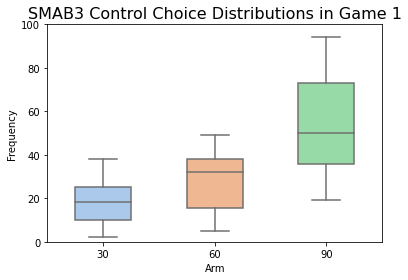

In [25]:
s_g1_counts_box = sns.boxplot( 
                 data=s_g1_counts, 
                 width=0.5,
                 palette="pastel")
s_g1_counts_box.axes.set_title("SMAB3 Control Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="s_g1_counts_box.jpg"
 
plt.ylim(0, 100)
s_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
s_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [26]:
'''Here we get the mean and standard deviation of the number of selections of each hole where low is the 0th column and the 30% hole, 
med is the 1st column and the 60% hole, and high is the 2nd column and the 90% hole.'''


s_g1_low = np.mean(s_g1_counts.iloc[:,0])
s_g1_med = np.mean(s_g1_counts.iloc[:,1])
s_g1_high = np.mean(s_g1_counts.iloc[:,2])


s_g1_low_std = np.std(s_g1_counts.iloc[:,0])
s_g1_med_std = np.std(s_g1_counts.iloc[:,1])
s_g1_high_std = np.std(s_g1_counts.iloc[:,2])

In [27]:
'''Here we create dataframes with the counts for game 2.'''


s_g2_counts = pd.DataFrame([s01_p1_g2_count, s03_p1_g2_count, 
                            s05_p1_g2_count, s06_p1_g2_count, s07_p1_g2_count, s08_p1_g2_count, s09_p1_g2_count,
                            s11_p1_g2_count, s12_p1_g2_count, s15_p1_g2_count, s16_p1_g2_count,
                    s17_p1_g2_count, s19_p1_g2_count, s20_p1_g2_count],
index= ['s01_p1_g2_count', 's03_p1_g2_count', 's05_p1_g2_count', 's06_p1_g2_count',
                                 's07_p1_g2_count', 's08_p1_g2_count', 's09_p1_g2_count', 's11_p1_g2_count', 
                                 's12_p1_g2_count', 's15_p1_g2_count', 's16_p1_g2_count','s17_p1_g2_count', 
                                 's19_p1_g2_count', 's20_p1_g2_count'])


#How to prevent NaN: df = df.fillna(0)
s_g2_counts = s_g2_counts.fillna(0)

#print
s_g2_counts

s_g2_counts.sum(axis=1)

s01_p1_g2_count    100.0
s03_p1_g2_count    100.0
s05_p1_g2_count    100.0
s06_p1_g2_count    100.0
s07_p1_g2_count    100.0
s08_p1_g2_count    100.0
s09_p1_g2_count    100.0
s11_p1_g2_count    101.0
s12_p1_g2_count    100.0
s15_p1_g2_count    101.0
s16_p1_g2_count    101.0
s17_p1_g2_count    101.0
s19_p1_g2_count    100.0
s20_p1_g2_count    101.0
dtype: float64

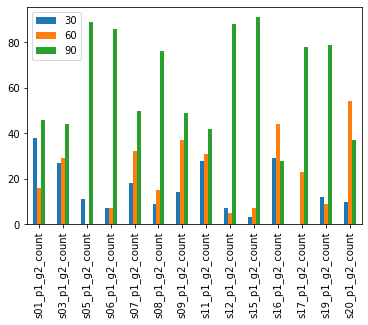

In [28]:
'''Here we plot the counts in game 2.'''

s_g2_counts_bar = s_g2_counts.plot.bar()

# save as jpeg
s_g2_counts_bar.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

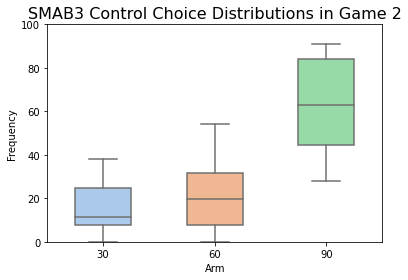

In [29]:
s_g2_counts_box = sns.boxplot( 
                 data=s_g2_counts, 
                 width=0.5,
                 palette="pastel")
s_g2_counts_box.axes.set_title("SMAB3 Control Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="s_g2_counts_box.jpg"

plt.ylim(0, 100)
s_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
s_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [30]:
'''Here we get the mean and standard deviation of the number of times participants chose each hole.'''


s_g2_low = np.mean(s_g2_counts.iloc[:,0])
s_g2_med = np.mean(s_g2_counts.iloc[:,1])
s_g2_high = np.mean(s_g2_counts.iloc[:,2])


In [31]:
s_g2_low_std = np.std(s_g2_counts.iloc[:,0])
s_g2_med_std = np.std(s_g2_counts.iloc[:,1])
s_g2_high_std = np.std(s_g2_counts.iloc[:,2])



s_g2_low_std



s_g2_med_std



s_g2_high_std

21.746803659107126

In [32]:
'''Here we place the value counts for each hole for each game into separate numy arrays and compare them statistically.'''


import researchpy as rp


s_90_1 = np.array(s_g1_counts.iloc[:,2])
s_90_2 = np.array(s_g2_counts.iloc[:,2])

s_60_1 = np.array(s_g1_counts.iloc[:,1])
s_60_2 = np.array(s_g2_counts.iloc[:,1])


s_30_1 = np.array(s_g1_counts.iloc[:,0])
s_30_2 = np.array(s_g2_counts.iloc[:,0])

s_90_p = sp.stats.ttest_rel(s_90_1,s_90_2)
s_60_p = sp.stats.ttest_rel(s_60_1,s_60_2)
s_30_p = sp.stats.ttest_rel(s_30_1,s_30_2)

# SMAB4 Single Player Analysis

In [33]:
'''Here we load the csv files into pandas dataframes by calling organize_trial_by_trial and get the scores in games
1 and 2 by calling call_get_score.'''

df = organize_trial_by_trial('data/c02_gamedata.csv')
c02 = df
c02_p1_g1_score,c02_p1_g2_score,c02_score_diff, c02_p1_g1_50,c02_p1_g2_50 = call_get_score(c02, 'c')
c02.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c03_gamedata.csv')
c03 = df
c03_p1_g1_score,c03_p1_g2_score,c03_score_diff, c03_p1_g1_50,c03_p1_g2_50 = call_get_score(c03, 'c')
c03.head()

#in the s files, p2 is the confederate
#df = organize_trial_by_trial('data/c04_gamedata.csv')
#c04 = df
#c04_p1_g1_score,c04_p1_g2_score,c04_score_diff = call_get_score(c04, 'c')
#c04.head()


#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c05_gamedata.csv')
c05 = df
c05_p1_g1_score,c05_p1_g2_score,c05_score_diff, c05_p1_g1_50,c05_p1_g2_50 = call_get_score(c05, 'c')
c05.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c06_gamedata.csv')
c06 = df
c06_p1_g1_score,c06_p1_g2_score,c06_score_diff, c06_p1_g1_50,c06_p1_g2_50 = call_get_score(c06, 'c')
c06.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c09_gamedata.csv')
c09 = df
c09_p1_g1_score,c09_p1_g2_score,c09_score_diff, c09_p1_g1_50,c09_p1_g2_50 = call_get_score(c09, 'c')
c09.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c10_gamedata.csv')
c10 = df
c10_p1_g1_score,c10_p1_g2_score,c10_score_diff, c10_p1_g1_50,c10_p1_g2_50 = call_get_score(c10, 'c')
c10.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c11_gamedata.csv')
c11 = df
c11_p1_g1_score,c11_p1_g2_score,c11_score_diff, c11_p1_g1_50,c11_p1_g2_50 = call_get_score(c11, 'c')
c11.head()

pd.set_option('display.max_columns', None)  

#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/c12_gamedata.csv')
c12 = df
c12_p1_g1_score,c12_p1_g2_score,c12_score_diff, c12_p1_g1_50,c12_p1_g2_50 = call_get_score(c12, 'c')
c12.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/c13_gamedata.csv')
c13 = df
c13_p1_g1_score,c13_p1_g2_score,c13_score_diff, c13_p1_g1_50,c13_p1_g2_50 = call_get_score(c13, 'c')
c13.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/c14_gamedata.csv')
c14 = df
c14_p1_g1_score,c14_p1_g2_score,c14_score_diff, c14_p1_g1_50,c14_p1_g2_50 = call_get_score(c14, 'c')
c14.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/c16_gamedata.csv')
c16 = df
c16_p1_g1_score,c16_p1_g2_score,c16_score_diff, c16_p1_g1_50,c16_p1_g2_50 = call_get_score(c16, 'c')
c12.head()

#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/c17_gamedata.csv')
c17 = df
c17_p1_g1_score,c17_p1_g2_score,c17_score_diff, c17_p1_g1_50,c17_p1_g2_50 = call_get_score(c17, 'c')
c17#in the s files, p2 is the confederate

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,30,0,0
1,1,1,2,0,60,0,0
2,1,2,1,3,30,0,0
3,1,3,2,0,60,0,0
4,1,4,1,1,90,0,1
...,...,...,...,...,...,...,...
397,2,196,1,1,90,73,54
398,2,197,2,0,60,74,54
399,2,198,1,1,90,74,54
400,2,199,2,0,60,75,54


In [34]:
'''Here we place the score differences between games 1 and 2 in pandas dataframes and get the mean.'''

# In[119]:


score_diff_confederate = pd.DataFrame({'participant':['c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'score_diff_confederate':
     [c02_score_diff, c03_score_diff,
      c05_score_diff, c06_score_diff, c09_score_diff, c10_score_diff, c11_score_diff, c12_score_diff, c13_score_diff, c14_score_diff, c16_score_diff, c17_score_diff ]})

score_diff_confederate

score_diff_confederate_mean = score_diff_confederate['score_diff_confederate'].mean()


score_diff_confederate_mean

-0.9166666666666666

In [35]:
'''Here we place the scores in games 1 and 2 into dataframes.'''


#list out all the scores in game 1 by participant
c_scores_1 = pd.DataFrame({'participant':['c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'confederate_score_1':
     [c02_p1_g1_score, c03_p1_g1_score,
      c05_p1_g1_score, c06_p1_g1_score, c09_p1_g1_score, c10_p1_g1_score, c11_p1_g1_score, c12_p1_g1_score, c13_p1_g1_score, c14_p1_g1_score, c16_p1_g1_score, c17_p1_g1_score]})
#to prevent an extra column that numbers each row:
c_scores_1.set_index('participant', inplace=True, drop=True)

#print
c_scores_1



#list out all the scores in game 2 by participant
c_scores_2 = pd.DataFrame({'participant':['c02', 'c03', 
                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'confederate_score_2':[c02_p1_g2_score, c03_p1_g2_score, c05_p1_g2_score, c06_p1_g2_score, c09_p1_g2_score, c10_p1_g2_score, c11_p1_g2_score, c12_p1_g2_score, c13_p1_g2_score, c14_p1_g2_score, c16_p1_g2_score, c17_p1_g2_score]})

#to prevent an extra column that numbers each row:
c_scores_2.set_index('participant', inplace=True, drop=True)
#s_scores_1 = pd.DataFrame(data = d1)
#s_scores_2 = pd.DataFrame(data = d2)

#print
c_scores_2


#list out all the scores in game 1 by participant
c_scores_1_50 = pd.DataFrame({'participant':['c02', 'c03', 
                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'score_1_50':
     [c02_p1_g1_50, c03_p1_g1_50, c05_p1_g1_50,
      c06_p1_g1_50, c09_p1_g1_50, c10_p1_g1_50, c11_p1_g1_50, c12_p1_g1_50, c13_p1_g1_50, c14_p1_g1_50, c16_p1_g1_50, c17_p1_g1_50]})
#to prevent an extra column that numbers each row:
c_scores_1_50.set_index('participant', inplace=True, drop=True)

#list out all the scores in game 2 by participant
c_scores_2_50 = pd.DataFrame({'participant':['c02', 'c03', 
                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'score_1_50':
     [c02_p1_g2_50, c03_p1_g2_50, c05_p1_g2_50,
      c06_p1_g2_50, c09_p1_g2_50, c10_p1_g2_50, c11_p1_g2_50, c12_p1_g2_50, c13_p1_g2_50, c14_p1_g2_50, c16_p1_g2_50, c17_p1_g2_50]})
c_scores_2_50.set_index('participant', inplace=True, drop=True)

In [36]:
'''Here we combine the dataframes with the scores from the 2 games.'''
c_scores_50 = c_scores_1_50.merge(c_scores_2_50,right_index=True,left_index=True)
c_scores = c_scores_1.merge(c_scores_2,right_index=True,left_index=True)
c_combo = c_scores_50.merge(c_scores,right_index=True,left_index=True)

#rename columns
c_combo.columns=["score_1_50", "score_2_50", "score_1", "score_2"]

In [37]:
'''Here we plot the scores in games 1 and 2.

c_scores_1_bar = c_scores_1.plot.bar()



c_scores_2_bar = c_scores_2.plot.bar()



#label columns
#c_scores.columns=['Game 1','Game 2']


c_scores'''

"Here we plot the scores in games 1 and 2.\n\nc_scores_1_bar = c_scores_1.plot.bar()\n\n\n\nc_scores_2_bar = c_scores_2.plot.bar()\n\n\n\n#label columns\n#c_scores.columns=['Game 1','Game 2']\n\n\nc_scores"

In [38]:
#need to fix rewards for SMAB4
c_combo

,score_1_50,score_2_50,score_1,score_2
participant,,,,
c02,36,43,74,85
c03,36,40,79,73
c05,33,35,61,72
c06,30,30,59,53
c09,34,24,61,44
c10,34,42,81,79
c11,28,40,69,82
c12,30,26,59,53
c13,28,35,64,68


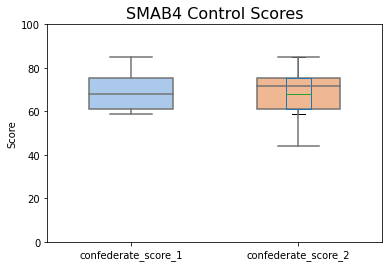

In [39]:
c_scores_box = c_scores.boxplot(labels=['Game 1','Game 2'])
plt.grid(b=None)
#plt.yticks(np.arange(50, 105, step=10))


c_scores_box = sns.boxplot( 
                 data=c_scores, 
                 width=0.5,
                 palette="pastel")
c_scores_box.axes.set_title("SMAB4 Control Scores",
                    fontsize=16)

plot_file_name="c_score_box.jpg"
 
plt.ylim(0, 100)
c_scores_box.axes.set(ylabel='Score')

# save as jpeg
c_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

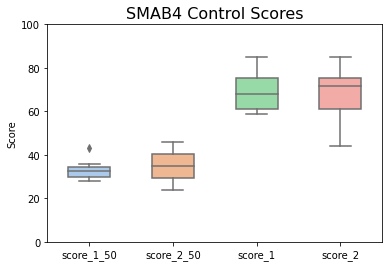

In [40]:
'''Here we make a boxplot with the scores in the first and second half of the games included'''
c_combo_box = sns.boxplot( 
                 data=c_combo, order = ['score_1_50','score_2_50','score_1','score_2'],
                 width=0.5,
                 palette="pastel")
c_combo_box.axes.set_title("SMAB4 Control Scores",
                    fontsize=16)

plot_file_name="c_score_box.jpg"
 
plt.ylim(0, 100)
c_combo_box.axes.set(ylabel='Score')

# save as jpeg
c_combo_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [41]:
'''Get the p value between the scores in games 1 and 2.

c_scores_p = sp.stats.ttest_rel(c_scores['Game 1'],c_scores['Game 2'])



c_scores_p


#plot bar graph of scores


c_scores_2_bar = c_scores_2.plot.bar()



#combine g1 and g2 to one dataframe
c_combo = c_scores_1.append(c_scores_2)



c_combo = pd.DataFrame({'participant':['c02', 'c02', 'c03', 'c03',
                              'c06','c06','c09','c09','c10','c10','c11','c11','c12','c12','c13','c13','c14','c14','c16','c16','c17','c17'], 'score':
     [c02_p1_g1_score, c02_p1_g2_score, c03_p1_g1_score, c03_p1_g2_score, c05_p1_g1_score, c05_p1_g2_score, c06_p1_g1_score, c06_p1_g2_score, c09_p1_g1_score, c09_p1_g2_score, c10_p1_g1_score, c10_p1_g2_score, c11_p1_g1_score, c11_p1_g2_score, c12_p1_g1_score, c12_p1_g2_score, c13_p1_g1_score, c13_p1_g2_score, c14_p1_g1_score, c14_p1_g2_score, c16_p1_g1_score, c16_p1_g2_score, c17_p1_g1_score, c17_p1_g2_score]})
c_combo.set_index('participant', inplace=True, drop=True)


#new_index = ('c02_g1','c02_g2','c03_g1','c03_g2','c04_g1','c04_g2','c05_g1','c05_g2','c06_g1','c06_g2','c09_g1','c09_g2','c10_g1','c10_g2','c11_g1','c11_g2','c12_g1','c12_g2','c13_g1','c13_g2','c14_g1','c14_g2','c16_g1','c16_g2','c17_g1','c17_g2')
#c_combo.index = new_index


c_combo = c_combo.sort_values(by=['participant'])'''

"Get the p value between the scores in games 1 and 2.\n\nc_scores_p = sp.stats.ttest_rel(c_scores['Game 1'],c_scores['Game 2'])\n\n\n\nc_scores_p\n\n\n#plot bar graph of scores\n\n\nc_scores_2_bar = c_scores_2.plot.bar()\n\n\n\n#combine g1 and g2 to one dataframe\nc_combo = c_scores_1.append(c_scores_2)\n\n\n\nc_combo = pd.DataFrame({'participant':['c02', 'c02', 'c03', 'c03',\n                              'c06','c06','c09','c09','c10','c10','c11','c11','c12','c12','c13','c13','c14','c14','c16','c16','c17','c17'], 'score':\n     [c02_p1_g1_score, c02_p1_g2_score, c03_p1_g1_score, c03_p1_g2_score, c05_p1_g1_score, c05_p1_g2_score, c06_p1_g1_score, c06_p1_g2_score, c09_p1_g1_score, c09_p1_g2_score, c10_p1_g1_score, c10_p1_g2_score, c11_p1_g1_score, c11_p1_g2_score, c12_p1_g1_score, c12_p1_g2_score, c13_p1_g1_score, c13_p1_g2_score, c14_p1_g1_score, c14_p1_g2_score, c16_p1_g1_score, c16_p1_g2_score, c17_p1_g1_score, c17_p1_g2_score]})\nc_combo.set_index('participant', inplace=True, drop=T

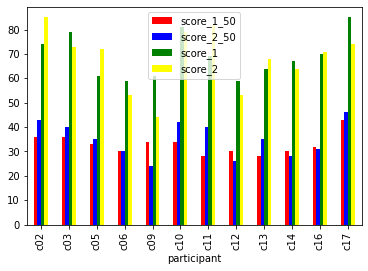

In [42]:
#unnecessary graph
#need to make g1 and g2 bars diff colors
colors = list(islice(cycle(['red','blue','green', 'yellow']),None,len(c_combo)))
#blue','red','blue','red','blue','red','blue','red','blue','red','blue']),None,len(c_combo)))
#my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
c_combo_bar = c_combo.plot(kind='bar',color=colors)

# Checking for outliars

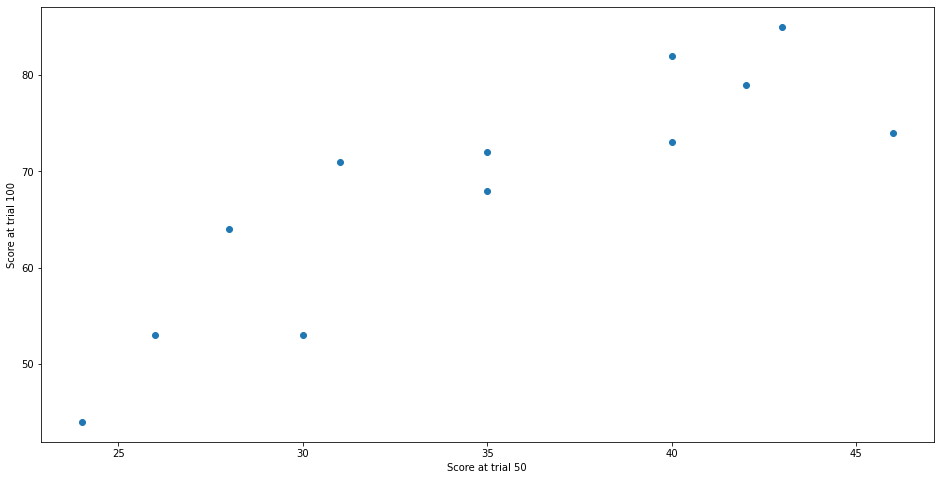

In [43]:
#scatter plot
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(c_combo['score_2_50'], c_combo['score_2'])
ax.set_xlabel('Score at trial 50')
ax.set_ylabel('Score at trial 100')
plt.show()

In [44]:
#calculate z score
z = np.abs(stats.zscore(c_combo['score_2']))
print(z)

[1.40048334 0.40211898 0.31892195 1.26182162 2.01059489 0.90130116
 1.15089225 1.26182162 0.01386617 0.34665429 0.23572492 0.48531601]


In [45]:
z = np.abs(stats.zscore(c_combo['score_2_50']))
print(z)

[1.15470054 0.72168784 0.         0.72168784 1.58771324 1.01036297
 0.72168784 1.29903811 0.         1.01036297 0.57735027 1.58771324]


In [46]:
'''Here we get the mean, median, and standard deviation of the scores in games 1 and 2.'''

c_scores_1_mean = c_scores_1.mean()


c_scores_1_mean

confederate_score_1    69.083333
dtype: float64

In [47]:
c_scores_1_std = c_scores_1.std()


c_scores_1_std

confederate_score_1    8.959082
dtype: float64

In [48]:
# In[146]:


c_scores_2_mean = c_scores_2.mean()


# In[147]:


c_scores_2_mean

confederate_score_2    68.166667
dtype: float64

In [49]:
# In[148]:


c_scores_2_std = c_scores_2.std()


# In[149]:


c_scores_2_std

confederate_score_2    12.554125
dtype: float64

In [50]:
# In[150]:


c_scores_med = c_scores.median()
c_scores_med

confederate_score_1    68.0
confederate_score_2    71.5
dtype: float64

In [51]:
'''Here we separate the dataframes into games 1 and 2.'''

#s01_p1_g1, s01_p1_g2 = separate_df(s01, 's')
c02_p1_g1, c02_p1_g2 = separate_df(c02, 'c')
c03_p1_g1, c03_p1_g2 = separate_df(c03, 'c')
c05_p1_g1, c05_p1_g2 = separate_df(c05, 'c')
c06_p1_g1, c06_p1_g2 = separate_df(c06, 'c')
c09_p1_g1, c09_p1_g2 = separate_df(c09, 'c')
c10_p1_g1, c10_p1_g2 = separate_df(c10, 'c')
c11_p1_g1, c11_p1_g2 = separate_df(c11, 'c')
c12_p1_g1, c12_p1_g2 = separate_df(c12, 'c')
c13_p1_g1, c13_p1_g2 = separate_df(c13, 'c')
c14_p1_g1, c14_p1_g2 = separate_df(c14, 'c')
c16_p1_g1, c16_p1_g2 = separate_df(c16, 'c')
c17_p1_g1, c17_p1_g2 = separate_df(c17, 'c')

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_

In [52]:
'''Here we count the number of times each hole was chosen in each game and place it in an array.'''

c02_p1_g1_count = c02_p1_g1['probability'].value_counts(sort=False)
c02_p1_g2_count = c02_p1_g2['probability'].value_counts(sort=False)
c03_p1_g1_count = c03_p1_g1['probability'].value_counts(sort=False)
c03_p1_g2_count = c03_p1_g2['probability'].value_counts(sort=False)
c05_p1_g1_count = c05_p1_g1['probability'].value_counts(sort=False)
c05_p1_g2_count = c05_p1_g2['probability'].value_counts(sort=False)
c06_p1_g1_count = c06_p1_g1['probability'].value_counts(sort=False)
c06_p1_g2_count = c06_p1_g2['probability'].value_counts(sort=False)
c09_p1_g1_count = c09_p1_g1['probability'].value_counts(sort=False)
c09_p1_g2_count = c09_p1_g2['probability'].value_counts(sort=False)
c10_p1_g1_count = c10_p1_g1['probability'].value_counts(sort=False)
c10_p1_g2_count = c10_p1_g2['probability'].value_counts(sort=False)
c11_p1_g1_count = c11_p1_g1['probability'].value_counts(sort=False)
c11_p1_g2_count = c11_p1_g2['probability'].value_counts(sort=False)
c12_p1_g1_count = c12_p1_g1['probability'].value_counts(sort=False)
c12_p1_g2_count = c12_p1_g2['probability'].value_counts(sort=False)
c13_p1_g1_count = c13_p1_g1['probability'].value_counts(sort=False)
c13_p1_g2_count = c13_p1_g2['probability'].value_counts(sort=False)
c14_p1_g1_count = c14_p1_g1['probability'].value_counts(sort=False)
c14_p1_g2_count = c14_p1_g2['probability'].value_counts(sort=False)
c16_p1_g1_count = c16_p1_g1['probability'].value_counts(sort=False)
c16_p1_g2_count = c16_p1_g2['probability'].value_counts(sort=False)
c17_p1_g1_count = c17_p1_g1['probability'].value_counts(sort=False)
c17_p1_g2_count = c17_p1_g2['probability'].value_counts(sort=False)

In [53]:
c09_p1_g2_count

30    45
60    37
90    18
Name: probability, dtype: int64

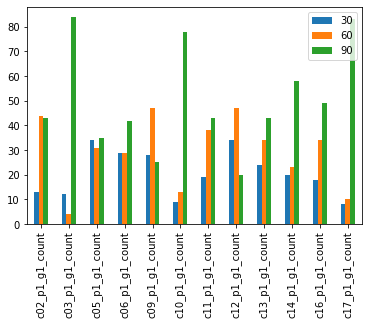

In [54]:
'''Here we place the number of times each hole was chosen by each subject in game 1 and into a dataframe.
We also plot this data and get the means and standard deviations of it.'''


c_g1_counts = pd.DataFrame([c02_p1_g1_count, c03_p1_g1_count,
                            c05_p1_g1_count, c06_p1_g1_count, c09_p1_g1_count, c10_p1_g1_count, c11_p1_g1_count, c12_p1_g1_count, c13_p1_g1_count, c14_p1_g1_count, c16_p1_g1_count, c17_p1_g1_count],
         index=['c02_p1_g1_count', 'c03_p1_g1_count', 'c05_p1_g1_count', 'c06_p1_g1_count', 
                'c09_p1_g1_count', 'c10_p1_g1_count', 'c11_p1_g1_count', 'c12_p1_g1_count', 'c13_p1_g1_count', 'c14_p1_g1_count', 
                'c16_p1_g1_count', 'c17_p1_g1_count'])


#How to prevent NaN: df = df.fillna(0)
c_g1_counts = c_g1_counts.fillna(0)

#print
c_g1_counts


c_g1_counts.sum(axis=1)


c_g1_counts_bar = c_g1_counts.plot.bar()

# save as jpeg
c_g1_counts_bar.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

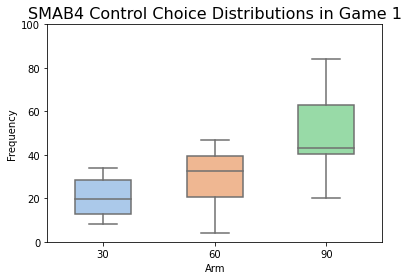

In [55]:
c_g1_counts_box = sns.boxplot( 
                 data=c_g1_counts, 
                 width=0.5,
                 palette="pastel")
c_g1_counts_box.axes.set_title("SMAB4 Control Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="c_g1_counts_box.jpg"
 
plt.ylim(0, 100)
c_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
c_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [56]:
# In[158]:


#0 is low (30), 1 is med (60), 2 is high (90)
c_g1_low = np.mean(c_g1_counts.iloc[:,0])
c_g1_med = np.mean(c_g1_counts.iloc[:,1])
c_g1_high = np.mean(c_g1_counts.iloc[:,2])


c_g1_low


c_g1_med


c_g1_high

50.25

In [57]:
c_g1_low_std = np.std(c_g1_counts.iloc[:,0])
c_g1_med_std = np.std(c_g1_counts.iloc[:,1])
c_g1_high_std = np.std(c_g1_counts.iloc[:,2])


c_g1_low_std


c_g1_med_std


c_g1_high_std

20.522853115490545

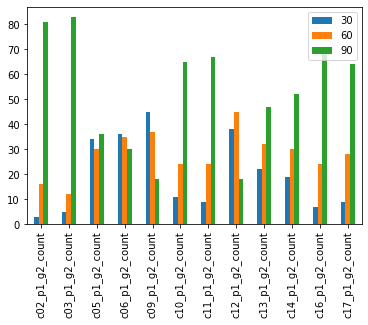

In [58]:
'''Here we place the number of times each hole was chosen by each subject in game 2 and into a dataframe.
We also plot this data and get the means and standard deviations of it.'''

c_g2_counts = pd.DataFrame([c02_p1_g2_count, c03_p1_g2_count,
                            c05_p1_g2_count, c06_p1_g2_count, c09_p1_g2_count, c10_p1_g2_count, c11_p1_g2_count, c12_p1_g2_count, c13_p1_g2_count, c14_p1_g2_count, c16_p1_g2_count, c17_p1_g2_count],
         index=['c02_p1_g2_count', 'c03_p1_g2_count', 'c05_p1_g2_count', 'c06_p1_g2_count', 
                'c09_p1_g2_count', 'c10_p1_g2_count', 'c11_p1_g2_count', 'c12_p1_g2_count', 'c13_p1_g2_count', 'c14_p1_g2_count', 
                'c16_p1_g2_count', 'c17_p1_g2_count'])


#How to prevent NaN: df = df.fillna(0)
c_g2_counts = c_g2_counts.fillna(0)

#print
c_g2_counts


c_g2_counts.sum(axis=1)


c_g2_counts_bar = c_g2_counts.plot.bar()

# save as jpeg
c_g2_counts_bar.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

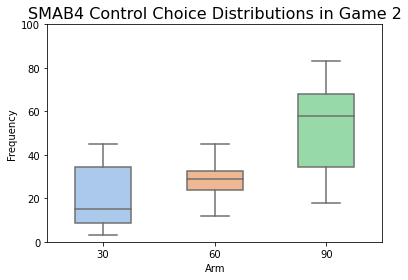

In [59]:
c_g2_counts_box = sns.boxplot( 
                 data=c_g2_counts, 
                 width=0.5,
                 palette="pastel")
c_g2_counts_box.axes.set_title("SMAB4 Control Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="c_g2_counts_box.jpg"
 
plt.ylim(0, 100)
c_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
c_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [60]:
c_g2_low = np.mean(c_g2_counts.iloc[:,0])
c_g2_med = np.mean(c_g2_counts.iloc[:,1])
c_g2_high = np.mean(c_g2_counts.iloc[:,2])


c_g2_low


c_g2_med


c_g2_high

52.583333333333336

In [61]:
c_g2_low_std = np.std(c_g2_counts.iloc[:,0])
c_g2_med_std = np.std(c_g2_counts.iloc[:,1])
c_g2_high_std = np.std(c_g2_counts.iloc[:,2])


c_g2_low_std


c_g2_med_std


c_g2_high_std 

21.86495801251145

In [62]:
'''Here we convert the value counts of each hole in each game into Numpy arrays.'''

import researchpy as rp


c_90_1 = np.array(c_g1_counts.iloc[:,2])
c_90_2 = np.array(c_g2_counts.iloc[:,2])


# In[182]:


c_90_1


# In[183]:


c_90_2


# In[184]:


c_60_1 = np.array(c_g1_counts.iloc[:,1])
c_60_2 = np.array(c_g2_counts.iloc[:,1])


# In[185]:


c_60_1


# In[186]:


c_60_2


# In[187]:


c_30_1 = np.array(c_g1_counts.iloc[:,0])
c_30_2 = np.array(c_g2_counts.iloc[:,0])


# In[188]:


c_30_1


# In[189]:


c_30_2

array([ 3,  5, 34, 36, 45, 11,  9, 38, 22, 19,  7,  9])

In [63]:
'''Here we do a t-test comparing the hole choices in games 1 and 2.'''



c_90_p = sp.stats.ttest_rel(c_90_1,c_90_2)
c_60_p = sp.stats.ttest_rel(c_60_1,c_60_2)
c_30_p = sp.stats.ttest_rel(c_30_1,c_30_2)


# In[191]:


c_90_p


# In[192]:


c_60_p


# In[193]:


c_30_p


# In[194]:


#maximizing and matching?


# In[195]:


#maximizing and matching?

Ttest_relResult(statistic=0.35541612894311325, pvalue=0.7289994056012533)

# Single Player Analysis of SMAB 3 and SMAB 4

## Testing for differences between SMAB 3 and SMAB 4

In [64]:
'''scores, games 1 vs 2, by condition, in smab 3 vs 4. So 2 x 2 x 2, 
mixed-measures anova or GLM, with game as a repeated measure. 
You could also collapse game and just do a simple 2x2 anova to get a sense of the data.'''

'scores, games 1 vs 2, by condition, in smab 3 vs 4. So 2 x 2 x 2, \nmixed-measures anova or GLM, with game as a repeated measure. \nYou could also collapse game and just do a simple 2x2 anova to get a sense of the data.'

In [65]:
import pingouin as pg

In [66]:
'''Here we place the scores in games 1 and 2 into dataframes, combining SMAB3 and SMAB4.'''

# NEED: add scores at trial 50



#list out all the scores in game 1 by participant
control_scores_1 = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20','c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'control_score_1':
     [s01_p1_g1_score, s03_p1_g1_score, s05_p1_g1_score,
      s06_p1_g1_score, s07_p1_g1_score, s08_p1_g1_score, s09_p1_g1_score, s11_p1_g1_score, s12_p1_g1_score, s15_p1_g1_score, s16_p1_g1_score, s17_p1_g1_score, s19_p1_g1_score, s20_p1_g1_score, c02_p1_g1_score, c03_p1_g1_score,
      c05_p1_g1_score, c06_p1_g1_score, c09_p1_g1_score, c10_p1_g1_score, c11_p1_g1_score, c12_p1_g1_score, c13_p1_g1_score, c14_p1_g1_score, c16_p1_g1_score, c17_p1_g1_score]})
#to prevent an extra column that numbers each row:
control_scores_1.set_index('participant', inplace=True, drop=True)

#print
control_scores_1


#list out all the scores in game 2 by participant
control_scores_2 = pd.DataFrame({'participant':['s01', 's03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20','c02', 'c03', 
                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'control_score_2':
        [s01_p1_g2_score, s03_p1_g2_score, s05_p1_g2_score, 
s06_p1_g2_score, s07_p1_g2_score, s08_p1_g2_score, s09_p1_g2_score, s11_p1_g2_score, s12_p1_g2_score, s15_p1_g2_score, s16_p1_g2_score, s17_p1_g2_score, s19_p1_g2_score, s20_p1_g2_score, 
         c02_p1_g2_score, c03_p1_g2_score, c05_p1_g2_score, c06_p1_g2_score, c09_p1_g2_score, c10_p1_g2_score, c11_p1_g2_score, c12_p1_g2_score, c13_p1_g2_score, c14_p1_g2_score, c16_p1_g2_score, c17_p1_g2_score]})

#to prevent an extra column that numbers each row:
control_scores_2.set_index('participant', inplace=True, drop=True)
#s_scores_1 = pd.DataFrame(data = d1)
#s_scores_2 = pd.DataFrame(data = d2)

#print
control_scores_2


#merge both games by participant:
control_scores = pd.merge(control_scores_1, control_scores_2, on = 'participant')



#label columns
control_scores.columns=['Game 1','Game 2']




control_scores



control_scores.sum(axis=1)


# In[203]:


control_scores=control_scores.sum(axis=1)


# In[204]:


control_scores.sort_values(inplace=True)


# In[205]:


control_scores


# In[206]:


control_scores_1_mean = control_scores_1.mean()


# In[207]:


control_scores_1_mean


# In[208]:


control_scores_1_std = control_scores_1.std()


# In[209]:


control_scores_1_std


# In[210]:


control_scores_2_mean = control_scores_2.mean()


# In[211]:


control_scores_2_mean


# In[212]:


control_scores_2_std = control_scores_2.std()


# In[213]:


control_scores_2_std


# In[214]:


control_scores_med = control_scores.median()
control_scores_med


# In[215]:


control_scores_p = sp.stats.ttest_rel(control_scores_1,control_scores_2)


# In[216]:


control_scores_p


# In[217]:


def degreesOfFreedom(X, Y):
    s1 = (stdev(X)**2)
    s2 = (stdev(Y)**2)
    df = (s1 / len(X) + s2 / len(Y))**2 / ((s1 / len(X))**2 / (len(X) - 1) + (s2 / len(Y))**2 / len(Y) - 1)
    return(df)


# 

# # Maximizing/Matching CONTROL

# In[218]:


s_g1_counts


# In[219]:


s_g1_counts.sum(axis=1)


# In[220]:


s_g2_counts


# In[221]:


s_g2_counts.sum(axis=1)


# In[222]:


c_g1_counts


# In[223]:


c_g1_counts.sum(axis=1)


# In[224]:


c_g2_counts


# In[225]:


c_g2_counts.sum(axis=1)

c02_p1_g2_count    100
c03_p1_g2_count    100
c05_p1_g2_count    100
c06_p1_g2_count    101
c09_p1_g2_count    100
c10_p1_g2_count    100
c11_p1_g2_count    100
c12_p1_g2_count    101
c13_p1_g2_count    101
c14_p1_g2_count    101
c16_p1_g2_count    101
c17_p1_g2_count    101
dtype: int64

In [67]:
#combine control_score_2 and control_score_1
control_scores = control_scores_1.merge(control_scores_2,right_index=True,left_index=True)

In [68]:
control_scores

,control_score_1,control_score_2
participant,,
s01,60,74
s03,63,71
s05,77,88
s06,82,87
s07,63,68
s08,90,80
s09,65,70
s11,60,61
s12,83,86


In [69]:
#convert from wide-format to long-format
#pd.melt(control_scores,id_vars=0, value_vars=['control_score_1','control_score_2'],ignore_index=False)

control_scores = pd.melt(control_scores,ignore_index=False)

In [70]:
subjects = control_scores.index.to_numpy()


experiment = np.array([])

for i in subjects:
    if [i][0][0] == 's':
        experiment = np.append(experiment,3)
    elif [i][0][0] == 'c':
        experiment = np.append(experiment,4)
        
control_scores['experiment'] = experiment

In [71]:
experiment

array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4.])

In [72]:
control_scores.reset_index()

,participant,variable,value,experiment
0,s01,control_score_1,60,3.0
1,s03,control_score_1,63,3.0
2,s05,control_score_1,77,3.0
3,s06,control_score_1,82,3.0
4,s07,control_score_1,63,3.0
5,s08,control_score_1,90,3.0
6,s09,control_score_1,65,3.0
7,s11,control_score_1,60,3.0
8,s12,control_score_1,83,3.0
9,s15,control_score_1,74,3.0


In [73]:
'''Here we conduct a 2 x 2 mixed measures ANOVA to compare the scores in games 1 and 2'''
pg.mixed_anova(data=control_scores, dv='value', between='experiment', within='variable', subject='participant')

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,experiment,223.718407,1,24,223.718407,1.143891,0.295471,0.045494,NaN
1,variable,38.942308,1,24,38.942308,1.097664,0.305216,0.043736,1.0
2,Interaction,78.099359,1,24,78.099359,2.201381,0.150902,0.084018,NaN


In [74]:
import patsy
import statsmodels.api as sm

In [75]:
'''Here we conduct a linear regression to compare the scores in games 1 and 2'''
outcome_1,predictors_1 = patsy.dmatrices("value ~ variable + experiment", control_scores)
mod_1 = sm.OLS(outcome_1,predictors_1)
res_1 = mod_1.fit()

print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.144
Date:                Thu, 03 Sep 2020   Prob (F-statistic):              0.327
Time:                        14:54:10   Log-Likelihood:                -195.55
No. Observations:                  52   AIC:                             397.1
Df Residuals:                      49   BIC:                             403.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [76]:
'''Here we place the hole counts from into dataframes, combining SMAB3 and SMAB4.'''


control_counts_g1 = pd.DataFrame([s01_p1_g1_count, s03_p1_g1_count, s05_p1_g1_count, s06_p1_g1_count, s07_p1_g1_count, 
                s08_p1_g1_count, s09_p1_g1_count, s11_p1_g1_count, s12_p1_g1_count, s15_p1_g1_count, s16_p1_g1_count,
                    s17_p1_g1_count, s19_p1_g1_count, s20_p1_g1_count,c02_p1_g1_count, c03_p1_g1_count,
                            c05_p1_g1_count, c06_p1_g1_count, c09_p1_g1_count, c10_p1_g1_count, c11_p1_g1_count, c12_p1_g1_count, c13_p1_g1_count, c14_p1_g1_count, c16_p1_g1_count, c17_p1_g1_count],
                          index=['s01_p1_g1_count', 's03_p1_g1_count', 
                            's05_p1_g1_count', 's06_p1_g1_count', 's07_p1_g1_count', 's08_p1_g1_count', 
                                 's09_p1_g1_count', 's11_p1_g1_count', 's12_p1_g1_count', 's15_p1_g1_count', 
                                 's16_p1_g1_count','s17_p1_g1_count', 's19_p1_g1_count', 's20_p1_g1_count','c02_p1_g1_count', 'c03_p1_g1_count', 'c05_p1_g1_count', 'c06_p1_g1_count', 
                'c09_p1_g1_count', 'c10_p1_g1_count', 'c11_p1_g1_count', 'c12_p1_g1_count', 'c13_p1_g1_count', 'c14_p1_g1_count', 
                'c16_p1_g1_count', 'c17_p1_g1_count'])




control_counts_g1


# In[228]:


control_counts_g2 = pd.DataFrame([s01_p1_g2_count, s03_p1_g2_count, 
                            s05_p1_g2_count, s06_p1_g2_count, s07_p1_g2_count, s08_p1_g2_count, s09_p1_g2_count,
                            s11_p1_g2_count, s12_p1_g2_count, s15_p1_g2_count, s16_p1_g2_count,
                    s17_p1_g2_count, s19_p1_g2_count, s20_p1_g2_count,c02_p1_g2_count, c03_p1_g2_count,
                            c05_p1_g2_count, c06_p1_g2_count, c09_p1_g2_count, c10_p1_g2_count, c11_p1_g2_count, c12_p1_g2_count, c13_p1_g2_count, c14_p1_g2_count, c16_p1_g2_count, c17_p1_g2_count],
index= ['s01_p1_g2_count', 's03_p1_g2_count', 's05_p1_g2_count', 's06_p1_g2_count',
                                 's07_p1_g2_count', 's08_p1_g2_count', 's09_p1_g2_count', 's11_p1_g2_count', 
                                 's12_p1_g2_count', 's15_p1_g2_count', 's16_p1_g2_count','s17_p1_g2_count', 
                                 's19_p1_g2_count', 's20_p1_g2_count','c02_p1_g2_count', 'c03_p1_g2_count', 'c05_p1_g2_count', 'c06_p1_g2_count', 
                'c09_p1_g2_count', 'c10_p1_g2_count', 'c11_p1_g2_count', 'c12_p1_g2_count', 'c13_p1_g2_count', 'c14_p1_g2_count', 
                'c16_p1_g2_count', 'c17_p1_g2_count'])


# In[229]:


control_counts_g2

,30,60,90
s01_p1_g2_count,38.0,16.0,46.0
s03_p1_g2_count,27.0,29.0,44.0
s05_p1_g2_count,11.0,NaN,89.0
s06_p1_g2_count,7.0,7.0,86.0
s07_p1_g2_count,18.0,32.0,50.0
s08_p1_g2_count,9.0,15.0,76.0
s09_p1_g2_count,14.0,37.0,49.0
s11_p1_g2_count,28.0,31.0,42.0
s12_p1_g2_count,7.0,5.0,88.0
s15_p1_g2_count,3.0,7.0,91.0


In [77]:
subjects_1 = control_counts_g1.index.to_numpy()

In [78]:
#combine control_counts_2 and control_counts_1

#modify the index to be only participant
subjects_1 = control_counts_g1.index.to_numpy()
subjects_2 = control_counts_g2.index.to_numpy()

subjects_new1 = np.array([])
subjects_new2 = np.array([])

ii = 0
for i in subjects_1:
    subjects_new1 = np.append(subjects_new1,subjects_1[ii][0:3])
    ii = ii +1
    
iii = 0
for i in subjects_2:
    subjects_new2 = np.append(subjects_new2,subjects_2[iii][0:3])
    iii = iii +1

control_counts_g1.index = subjects_new1
control_counts_g2.index = subjects_new2

control_counts = control_counts_g1.merge(control_counts_g2,right_index=True,left_index=True)

In [79]:
control_counts = pd.melt(control_counts,ignore_index=False)

In [80]:
control_counts

,variable,value
s01,30_x,38.0
s03,30_x,28.0
s05,30_x,11.0
s06,30_x,11.0
s07,30_x,25.0
...,...,...
c12,90_y,18.0
c13,90_y,47.0
c14,90_y,52.0
c16,90_y,70.0


In [81]:
length = len(control_counts['variable'][0])
control_counts['variable'][0][length-1]

'x'

In [82]:
#clean up control_counts
#modify 'variable' to be only '30','60', or '90' and add a column 'game' specifying the game #
variable = control_counts['variable'].to_numpy()

choice = np.array([])
game = np.array([])

ii = 0
for i in variable:
    length = len(variable[ii])
    if variable[ii][length - 1] == 'x':
        game = np.append(game,'1')
    elif variable[ii][len(variable[ii]) - 1] == 'y':
        game = np.append(game,'2')
    choice = np.append(choice,variable[ii][0:2])
    ii = ii +1
    
control_counts['variable'] = choice
control_counts['game'] = game

In [83]:
control_counts

,variable,value,game
s01,30,38.0,1
s03,30,28.0,1
s05,30,11.0,1
s06,30,11.0,1
s07,30,25.0,1
...,...,...,...
c12,90,18.0,2
c13,90,47.0,2
c14,90,52.0,2
c16,90,70.0,2


In [84]:
# In[230]:


#Here we compare the choice distributions to idealized models of two decision-making strategies: 
#matching and maximizing. Matching would be choosing each each hole proportionally to its reward rate, 
#and maximizing would be always choosing the high reward hole.


# In[231]:


#JSD: Jensen Shannon Divergence. Measures the similarity between two probability distributions. Taken from 
#https://urldefense.com/v3/__https://gist.github.com/zhiyzuo/f80e2b1cfb493a5711330d271a228a3d__;!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX94Xg7JRI$ . *Note: probability distributions need to be
#normalized.'''
#parameters: p and q are the two probability distributions to be compared.

def jsd(p, q, base=np.e):
    
    
    #Implementation of pairwise `jsd` based on https://urldefense.com/v3/__https://en.wikipedia.org/wiki/Jensen**BShannon_divergence__;4oCT!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX9SSBIvMc$ 
    # convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    # normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    return sp.stats.entropy(p,m, base=base)/2. +  sp.stats.entropy(q, m, base=base)/2.


# In[232]:


#Are ppl using a strategy similar to their partner's? This functions calls jsd for p1 and for p2. *UNFINISHED* 
#DO NOT USE.
#calls jsd for p1 and p2 and for p1 and p2 with the mean
#def compare_strat(p1,p2):
    #strat = jsd(p1,p2)
   # comp_1 = jsd(p1,[j_g1_low,j_g1_med,j_g1_high])
    #comp_2 = jsd(p2,[j_g1_low,j_g1_med,j_g1_high])
    #return strat, comp_1, comp_2


# In[233]:


#Idealized probability distributions to use for comparison. You can change these or add more models.

maximize = [0,0,100]
match = [30/180 * 100,60/180 * 100,90/180 * 100]
random = [30/90 * 100,30/90 * 100,30/90 * 100]
social = [1/3 * 100,1/3 * 100, 1/3 * 100]


# In[234]:


#This function calls jsd. 
#Input: counts- a player's choice distributions in a particular game (ex. s01_p1_g1_counts)
#Output: maxi- JSD score for the maximizing strategy
        #matchi- JSD score for the matching strategy
def call_jsd(counts):
    maxi = jsd(counts,maximize) #(p, q)
    matchi = jsd(counts,match)
    rando = jsd(counts,random)
    soci = jsd(counts, social)
    return maxi,matchi,rando,soci


# In[235]:


from scipy import stats


# In[236]:


#if same, 0
#test = jsd(counts,maximize)


# In[237]:


#test


# In[238]:


def check_type(df,*social):
    types = pd.DataFrame(index=['type'])

In [85]:
# In[239]:

#Call 'call_jsd' for each participant for each game in the single player sessions.
#with 0, put in actual probabilities in brackets

s01_g1_max,s01_g1_match,s01_g1_rand,s01_g1_soc = call_jsd(s01_p1_g1_count)
s01_g2_max,s01_g2_match,s01_g2_rand,s01_g2_soc = call_jsd(s01_p1_g2_count)
s03_g1_max,s03_g1_match,s03_g1_rand,s03_g1_soc = call_jsd(s03_p1_g1_count)
s03_g2_max,s03_g2_match,s03_g2_rand,s03_g2_soc = call_jsd(s03_p1_g2_count)
s05_g1_max,s05_g1_match,s05_g1_rand,s05_g1_soc= call_jsd(s05_p1_g1_count)
s05_g2_max,s05_g2_match,s05_g2_rand,s05_g2_soc = call_jsd([11, 0, 89])
s06_g1_max,s06_g1_match,s06_g1_rand,s06_g1_soc = call_jsd(s06_p1_g1_count)
s06_g2_max,s06_g2_match,s06_g2_rand,s06_g2_soc = call_jsd(s06_p1_g2_count)
s07_g1_max,s07_g1_match,s07_g1_rand,s07_g1_soc = call_jsd(s07_p1_g1_count)
s07_g2_max,s07_g2_match,s07_g2_rand,s07_g2_soc = call_jsd(s07_p1_g2_count)
s08_g1_max,s08_g1_match,s08_g1_rand,s08_g1_soc = call_jsd(s08_p1_g1_count)
s08_g2_max,s08_g2_match,s08_g2_rand,s08_g2_soc = call_jsd(s08_p1_g2_count)
s09_g1_max,s09_g1_match,s09_g1_rand,s09_g1_soc = call_jsd(s09_p1_g1_count)
s09_g2_max,s09_g2_match,s09_g2_rand,s09_g2_soc = call_jsd(s09_p1_g2_count)
s11_g1_max,s11_g1_match,s11_g1_rand,s11_g1_soc = call_jsd(s11_p1_g1_count)
s11_g2_max,s11_g2_match,s11_g2_rand,s11_g2_soc = call_jsd(s11_p1_g2_count)
s12_g1_max,s12_g1_match,s12_g1_rand,s12_g1_soc = call_jsd(s12_p1_g1_count)
s12_g2_max,s12_g2_match,s12_g2_rand,s12_g2_soc = call_jsd(s12_p1_g2_count)
s15_g1_max,s15_g1_match,s15_g1_rand,s15_g1_soc = call_jsd(s15_p1_g1_count)
s15_g2_max,s15_g2_match,s15_g2_rand,s15_g2_soc = call_jsd(s15_p1_g2_count)
s16_g1_max,s16_g1_match,s16_g1_rand,s16_g1_soc = call_jsd(s16_p1_g1_count)
s16_g2_max,s16_g2_match,s16_g2_rand,s16_g2_soc = call_jsd(s16_p1_g2_count)
s17_g1_max,s17_g1_match,s17_g1_rand,s17_g1_soc = call_jsd(s17_p1_g1_count)
s17_g2_max,s17_g2_match,s17_g2_rand,s17_g2_soc = call_jsd([0,22,78])
s19_g1_max,s19_g1_match,s19_g1_rand,s19_g1_soc = call_jsd(s19_p1_g1_count)
s19_g2_max,s19_g2_match,s19_g2_rand,s19_g2_soc = call_jsd(s19_p1_g2_count)
s20_g1_max,s20_g1_match,s20_g1_rand,s20_g1_soc = call_jsd(s20_p1_g1_count)
s20_g2_max,s20_g2_match,s20_g2_rand,s20_g2_soc = call_jsd(s20_p1_g2_count)
c02_g1_max,c02_g1_match,c02_g1_rand,c02_g1_soc = call_jsd(c02_p1_g1_count)
c02_g2_max,c02_g2_match,c02_g2_rand,c02_g2_soc = call_jsd(c02_p1_g2_count)
c03_g1_max,c03_g1_match,c03_g1_rand,c03_g1_soc = call_jsd(c03_p1_g1_count)
c03_g2_max,c03_g2_match,c03_g2_rand,c03_g2_soc = call_jsd(c03_p1_g2_count)
c05_g1_max,c05_g1_match,c05_g1_rand,c05_g1_soc = call_jsd(c05_p1_g1_count)
c05_g2_max,c05_g2_match,c05_g2_rand,c05_g2_soc = call_jsd(c05_p1_g2_count)
c06_g1_max,c06_g1_match,c06_g1_rand,c06_g1_soc = call_jsd(c06_p1_g1_count)
c06_g2_max,c06_g2_match,c06_g2_rand,c06_g2_soc = call_jsd(c06_p1_g1_count)
c09_g1_max,c09_g1_match,c09_g1_rand,c09_g1_soc = call_jsd(c09_p1_g1_count)
c09_g2_max,c09_g2_match,c09_g2_rand,c09_g2_soc = call_jsd(c09_p1_g2_count)
c10_g1_max,c10_g1_match,c10_g1_rand,c10_g1_soc = call_jsd(c10_p1_g1_count)
c10_g2_max,c10_g2_match,c10_g2_rand,c10_g2_soc = call_jsd(c10_p1_g2_count)
c11_g1_max,c11_g1_match,c11_g1_rand,c11_g1_soc = call_jsd(c11_p1_g1_count)
c11_g2_max,c11_g2_match,c11_g2_rand,c11_g2_soc= call_jsd(c11_p1_g2_count)
c12_g1_max,c12_g1_match,c12_g1_rand,c12_g1_soc = call_jsd(c12_p1_g1_count)
c12_g2_max,c12_g2_match,c12_g2_rand,c12_g2_soc = call_jsd(c12_p1_g2_count)
c13_g1_max,c13_g1_match,c13_g1_rand,c13_g1_soc  = call_jsd(c13_p1_g1_count)
c13_g2_max,c13_g2_match,c13_g2_rand,c13_g2_soc = call_jsd(c13_p1_g2_count)
c14_g1_max,c14_g1_match,c14_g1_rand,c14_g1_soc = call_jsd(c14_p1_g1_count)
c14_g2_max,c14_g2_match,c14_g2_rand,c14_g2_soc = call_jsd(c14_p1_g2_count)
c16_g1_max,c16_g1_match,c16_g1_rand,c16_g1_soc = call_jsd(c16_p1_g1_count)
c16_g2_max,c16_g2_match,c16_g2_rand,c16_g2_soc = call_jsd(c16_p1_g2_count)
c17_g1_max,c17_g1_match,c17_g1_rand,c17_g1_soc = call_jsd(c17_p1_g1_count)
c17_g2_max,c17_g2_match,c17_g2_rand,c17_g2_soc = call_jsd(c17_p1_g2_count)

In [86]:
# In[ ]:


#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
control_jsd_g1 = pd.DataFrame({'max':[s01_g1_max,s03_g1_max,s05_g1_max,s06_g1_max,s07_g1_max,s08_g1_max,
                                s09_g1_max, s11_g1_max, s12_g1_max, s15_g1_max, s16_g1_max, s17_g1_max, 
                                      s19_g1_max, s20_g1_max, c02_g1_max, c03_g1_max, c05_g1_max, c06_g1_max, 
                                      c09_g1_max, c10_g1_max, c11_g1_max, c12_g1_max, c13_g1_max, c14_g1_max, 
                                      c16_g1_max, c17_g1_max],
                      'match':[s01_g1_match,s03_g1_match,s05_g1_match
                               ,s06_g1_match,s07_g1_match,s08_g1_match,s09_g1_match, s11_g1_match, 
                               s12_g1_match, s15_g1_match, s16_g1_match, s17_g1_match, s19_g1_match, 
                               s20_g1_match, c02_g1_match, c03_g1_match, c05_g1_match, c06_g1_match, 
                                      c09_g1_match, c10_g1_match, c11_g1_match, c12_g1_match, c13_g1_match, c14_g1_match, 
                                      c16_g1_match, c17_g1_match],
                    'rand':[s01_g1_rand,s03_g1_rand,s05_g1_rand,s06_g1_rand,s07_g1_rand,s08_g1_rand,
                                s09_g1_rand, s11_g1_rand, s12_g1_rand, s15_g1_rand, s16_g1_rand, s17_g1_rand, 
                                      s19_g1_rand, s20_g1_rand, c02_g1_rand, c03_g1_rand, c05_g1_rand, c06_g1_rand, 
                                      c09_g1_rand, c10_g1_rand, c11_g1_rand, c12_g1_rand, c13_g1_rand, c14_g1_rand, 
                                      c16_g1_rand, c17_g1_rand],
                        'soc':[s01_g1_soc,s03_g1_soc,s05_g1_soc,s06_g1_soc,s07_g1_soc,s08_g1_soc,
                                s09_g1_soc, s11_g1_soc, s12_g1_soc, s15_g1_soc, s16_g1_soc, s17_g1_soc, 
                                      s19_g1_soc, s20_g1_soc, c02_g1_soc, c03_g1_soc, c05_g1_soc, c06_g1_soc, 
                                      c09_g1_soc, c10_g1_soc, c11_g1_soc, c12_g1_soc, c13_g1_soc, c14_g1_soc, 
                                      c16_g1_soc, c17_g1_soc]},
                              
                        index=['s01', 's03','s05','s06','s07','s08','s09', 's11', 's12', 's15', 's16', 's17', 's19', 's20', 'c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'])

In [87]:
# In[ ]:


#closer to 0 = closer to that pure strategy
control_jsd_g1


# In[ ]:


# get the column name of min values in every row
strategy_control_jsd_g1 = control_jsd_g1.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_control_jsd_g1)


# In[ ]:


strategy_control_jsd_g1.value_counts()


# In[ ]:


#control_types_g1 = check_type(control_jsd_g1)


# In[ ]:


#control_types_g1.drop([0])


# In[ ]:


#(control_types_g1 == 'maxi').sum()


# In[ ]:


#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
control_jsd_g2 = pd.DataFrame({'max':[s01_g2_max,s03_g2_max,s05_g2_max,s06_g2_max,s07_g2_max,s08_g2_max,
                                s09_g2_max, s11_g2_max, s12_g2_max, s15_g2_max, s16_g2_max, s17_g2_max, 
                                      s19_g2_max, s20_g2_max, c02_g2_max, c03_g2_max, c05_g2_max, c06_g2_max, 
                                      c09_g2_max, c10_g2_max, c11_g2_max, c12_g2_max, c13_g2_max, c14_g2_max, 
                                      c16_g2_max, c17_g2_max],
                      'match':[s01_g2_match,s03_g2_match,s05_g2_match
                               ,s06_g2_match,s07_g2_match,s08_g2_match,s09_g2_match, s11_g2_match, 
                               s12_g2_match, s15_g2_match, s16_g2_match, s17_g2_match, s19_g2_match, 
                               s20_g2_match, c02_g2_match, c03_g2_match, c05_g2_match, c06_g2_match, 
                                      c09_g2_match, c10_g2_match, c11_g2_match, c12_g2_match, c13_g2_match, c14_g2_match, 
                                      c16_g2_match, c17_g2_match],
                    'rand':[s01_g2_rand,s03_g2_rand,s05_g2_rand,s06_g2_rand,s07_g2_rand,s08_g2_rand,
                                s09_g2_rand, s11_g2_rand, s12_g2_rand, s15_g2_rand, s16_g2_rand, s17_g2_rand, 
                                      s19_g2_rand, s20_g2_rand, c02_g2_rand, c03_g2_rand, c05_g2_rand, c06_g2_rand, 
                                      c09_g2_rand, c10_g2_rand, c11_g2_rand, c12_g2_rand, c13_g2_rand, c14_g2_rand, 
                                      c16_g2_rand, c17_g2_rand],
                        'soc':[s01_g2_soc,s03_g2_soc,s05_g2_soc,s06_g2_soc,s07_g2_soc,s08_g2_soc,
                                s09_g2_soc, s11_g2_soc, s12_g2_soc, s15_g2_soc, s16_g2_soc, s17_g2_soc, 
                                      s19_g2_soc, s20_g2_soc, c02_g2_soc, c03_g2_soc, c05_g2_soc, c06_g2_soc, 
                                      c09_g2_soc, c10_g2_soc, c11_g2_soc, c12_g2_soc, c13_g2_soc, c14_g2_soc, 
                                      c16_g2_soc, c17_g2_soc]},
                              
                        index=['s01', 's03','s05','s06','s07','s08','s09', 's11', 's12', 's15', 's16', 's17', 's19', 's20', 'c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'])

min values of row are at following columns :
s01     rand
s03     rand
s05    match
s06    match
s07    match
s08      max
s09    match
s11     rand
s12    match
s15    match
s16     rand
s17      max
s19    match
s20     rand
c02    match
c03      max
c05     rand
c06     rand
c09     rand
c10    match
c11    match
c12     rand
c13    match
c14    match
c16    match
c17    match
dtype: object


In [88]:
# In[ ]:


control_jsd_g2


# In[ ]:


# get the column name of min values in every row
strategy_control_jsd_g2 = control_jsd_g2.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_control_jsd_g2)


# In[ ]:


minValues_control_jsd_g2 = control_jsd_g2.min()
 
print('minimum value in each column : ')
print(minValues_control_jsd_g2)


# In[ ]:


maxValues_control_jsd_g2 = control_jsd_g2.max()
 
print('maximum value in each column : ')
print(maxValues_control_jsd_g2)


# In[ ]:


strategy_control_jsd_g2.value_counts()


# In[ ]:


#control_types_g2 = check_type(control_jsd_g2)


# In[ ]:


#control_types_g2.drop([0])


# In[ ]:


#(control_types_g2 == 'maxi').sum()


# In[ ]:


#how different max and match dists are from eachother
#neither max or match(?)
#threshold = jsd(maximize,match)

min values of row are at following columns :
s01     rand
s03     rand
s05      max
s06      max
s07    match
s08    match
s09    match
s11     rand
s12      max
s15      max
s16     rand
s17    match
s19    match
s20    match
c02    match
c03      max
c05     rand
c06     rand
c09     rand
c10    match
c11    match
c12     rand
c13    match
c14    match
c16    match
c17    match
dtype: object
minimum value in each column : 
max      0.035604
match    0.000196
rand     0.000712
soc      0.000712
dtype: float64
maximum value in each column : 
max      0.442841
match    0.146174
rand     0.210697
soc      0.210697
dtype: float64


match    13
rand      8
max       5
dtype: int64

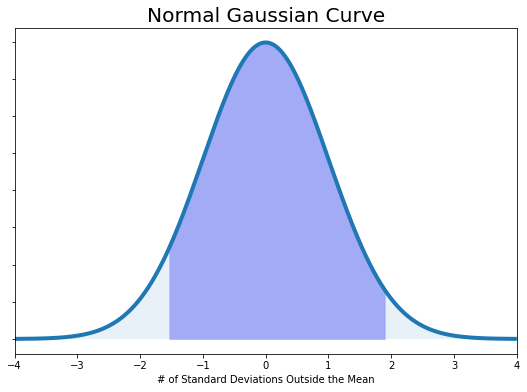

In [89]:
# In[ ]:


import matplotlib.lines as mlines


# In[ ]:


#colors_jsd = [['lightcoral','red','lightcoral','red','bisque','orange','bisque','orange','palegreen','green','palegreen','green',
              #'lightblue','blue','lightblue','blue','mediumslateblue','indigo','mediumslateblue','indigo','lightpink','deeppink',
              #'lightpink','deeppink','yellow','gold','yellow','gold','lightgray','gray','lightgray','gray']              


# In[ ]:


import itertools


# In[ ]:


#Here I print the means of the JSD values in each condition, just to see what they are.'''


# In[ ]:


#run t test to see sig between max and match per game
#put in box plot
control_jsd_g1.mean()


# In[ ]:


control_jsd_g1.std()


# In[ ]:


control_jsd_g2.mean()


# In[ ]:


control_jsd_g2.std()


# # Control z-scores

# In[ ]:


sp.stats.zscore(control_jsd_g1['max'])


# In[ ]:


sp.stats.zscore(control_jsd_g2['max'])


# In[ ]:


sp.stats.zscore(control_jsd_g1['match'])


# In[ ]:


sp.stats.zscore(control_jsd_g2['match'])


# In[ ]:


import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
# if using a Jupyter notebook, inlcude:
get_ipython().run_line_magic('matplotlib', 'inline')


# In[ ]:


mu = 0.217806 
sigma = 0.118674
x1 = 0.035604
x2 = 0.442841


# In[ ]:


# calculate the z-transform
z1 = ( x1 - mu ) / sigma
z2 = ( x2 - mu ) / sigma


# In[ ]:


x = np.arange(z1, z2, 0.001) # range of x in spec
x_all = np.arange(-10, 10, 0.001) # entire range of x, both in and out of spec
# mean = 0, stddev = 1, since Z-transform was calculated
y = norm.pdf(x,0,1)
y2 = norm.pdf(x_all,0,1)


# In[ ]:


# build the plot
fig, ax = plt.subplots(figsize=(9,6))
plt.style.use('fivethirtyeight')
ax.plot(x_all,y2)

ax.fill_between(x,y,0, alpha=0.3, color='b')
ax.fill_between(x_all,y2,0, alpha=0.1)
ax.set_xlim([-4,4])
ax.set_xlabel('# of Standard Deviations Outside the Mean')
ax.set_yticklabels([])
ax.set_title('Normal Gaussian Curve')

plt.savefig('normal_curve.png', dpi=72, bbox_inches='tight')
plt.show()

In [90]:
# # Control strategy stats 

# In[ ]:


control_jsd_g1.dropna(inplace = True) 


# # Max strategy

# In[ ]:


control_max_g1 = control_jsd_g1.loc[ : , 'max' ]


# In[ ]:


control_max_g1


# In[ ]:


control_max_g2 = control_jsd_g2.loc[ : , 'max' ]


# In[ ]:


control_max_g2


# In[ ]:


control_max_g1_mean = control_max_g1.mean()


# In[ ]:


control_max_g1_mean


# In[ ]:


control_max_g1_std = control_max_g1.std()


# In[ ]:


control_max_g1_std


# In[ ]:


control_max_g2_mean = control_max_g2.mean()


# In[ ]:


control_max_g2_mean


# In[ ]:


control_max_g2_std = control_max_g2.std()
control_max_g2_std


# Max T-Test 

# In[ ]:


control_max_p = sp.stats.ttest_rel(control_max_g1,control_max_g2)


# In[ ]:


control_max_p


# # Match strategy

# In[ ]:


control_match_g1 = control_jsd_g1.loc[ : , 'match' ]


# In[ ]:


control_match_g1


# In[ ]:


control_match_g2 = control_jsd_g2.loc[ : , 'match' ]


# In[ ]:


control_match_g2


# In[ ]:


control_match_g1_mean = control_match_g1.mean()


# In[ ]:


control_match_g1_mean


# In[ ]:


control_match_g1_std = control_match_g1.std()


# In[ ]:


control_match_g1_std


# In[ ]:


control_match_g2_mean = control_match_g2.mean()


# In[ ]:


control_match_g2_mean


# In[ ]:


control_match_g2_std = control_match_g2.std()


# In[ ]:


control_match_g2_std


# In[ ]:


control_match_p = sp.stats.ttest_rel(control_match_g1,control_match_g2)


# In[ ]:


control_match_p


# # Random strategy

# In[ ]:


control_rand_g1 = control_jsd_g1.loc[ : , 'rand' ]


# In[ ]:


control_rand_g1


# In[ ]:


control_rand_g2 = control_jsd_g2.loc[ : , 'rand' ]


# In[ ]:


control_rand_g2


# In[ ]:


control_rand_g1_mean = control_rand_g1.mean()


# In[ ]:


control_rand_g1_mean


# In[ ]:


control_rand_g1_std = control_rand_g1.std()


# In[ ]:


control_rand_g1_std


# In[ ]:


control_rand_g2_mean = control_rand_g2.mean()


# In[ ]:


control_rand_g2_mean


# In[ ]:


control_rand_g2_std = control_rand_g2.std()
control_rand_g2_std


# In[ ]:


control_rand_p = sp.stats.ttest_rel(control_rand_g1,control_rand_g2)


# In[ ]:


control_rand_p


# # Social strategy

# In[ ]:


control_soc_g1 = control_jsd_g1.loc[ : , 'soc' ]


# In[ ]:


control_soc_g1


# In[ ]:


control_soc_g2 = control_jsd_g2.loc[ : , 'soc' ]


# In[ ]:


control_soc_g2


# In[ ]:


control_soc_g1_mean = control_soc_g1.mean()


# In[ ]:


control_soc_g1_mean


# In[ ]:


control_soc_g1_std = control_soc_g1.std()


# In[ ]:


control_soc_g1_std


# In[ ]:


control_soc_g2_mean = control_soc_g2.mean()


# In[ ]:


control_soc_g2_mean


# In[ ]:


control_soc_g2_std = control_soc_g2.std()


# In[ ]:


control_soc_g2_std


# In[ ]:


control_soc_p = sp.stats.ttest_rel(control_soc_g1,control_soc_g2)


# In[ ]:


control_soc_p


# In[ ]:


#control_scores_p = sp.stats.ttest_rel(control_scores['Game 1'],control_scores['Game 2'])


# In[ ]:


#control_scores_p


# In[ ]:





# In[ ]:


import matplotlib.patches as mpatches


# In[ ]:


#,'orange','green','blue','pink','purple','peru','cyan','red','lightcoral','orange','darkorange','green','palegreen','blue', 'peru','cyan', 'red','lightcoral', 'orange','darkorange','green','palegreen','blue','palegreen','blue']


# In[ ]:


#Here I think I tried to create colors for each subject in each condition for use in graphs. I DON'T think this is 
#a good way to do this.'''
#colors_jsd_j = ['red','lightcoral','red','darkred','green','red',
             # 'blue','darkblue','hotblue','blue','purple','plum','peru','saddlebrown','gray','lightgray']
colors_jsd_control_g1_ego = ['red','red','red','red','red','blue','red','red','red','red',
                         'red','blue','red','red',
              'red', 'blue','red', 'red','red', 'red','red','red','red','red','red','red']


colors_jsd_control_g2_ego = ['red','red','blue','blue','red','red','red','red','blue','blue',
                         'red','red','red','red',
              'red', 'blue','red', 'red','red', 'red','red','red','red','red','red','red']


colors_jsd_control_g1_joint = ['green','green','green','green','green','green','green','green'
                              ,'green','green', 'green','green','green','green',
              'green','green','green','green','green','green','green','green','green'
                              ,'green','green','green']

colors_jsd_control_g2_joint = ['green','green','green','green','green','green','green','green'
                              ,'green','green', 'green','green','green','green',
              'green','green','green','green','green','green','green','green','green'
                              ,'green','green','green']

#markers_jsd = ['o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v'
       #   'o','v','o','v','o','v','o','v']
colors

['red',
 'blue',
 'green',
 'yellow',
 'red',
 'blue',
 'green',
 'yellow',
 'red',
 'blue',
 'green',
 'yellow']

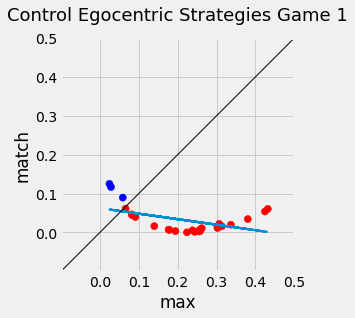

In [91]:
# # Graphs

# In[ ]:


#Here I try to plot the JSD Values. Continued below under 'JSD with gender.


# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(control_jsd_g1['max'], control_jsd_g1['match'], 1)

control_ego_jsd_g1_plot = control_jsd_g1.plot.scatter(x='max',y='match',s=50,color=colors_jsd_control_g1_ego)
plt.title('Control Egocentric Strategies Game 1', fontsize=18, y=1.05)
control_ego_jsd_g1_plot.plot(control_jsd_g1['max'], m*control_jsd_g1['max'] + b, linewidth=2)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)

#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])

line1 = mlines.Line2D([-1, .5],[-1, .5], color='black', linewidth=1)
control_ego_jsd_g1_plot.add_line(line1)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('control_ego_jsd_1.eps',format='eps',bbox_inches='tight',dpi=1000)
plt.show()

In [92]:
# In[ ]:


'''ontrol_ego_jsd_g1_plot = control_jsd_g1.plot.scatter(x='max',y='match',s=50,color=colors_jsd_control_g1_ego)

hist, xbins,ybins = control_ego_jsd_g1_plot.figure.histogram(y,x, bins=range(6))
x,y = np.meshgrid(xbins[:-1], ybins[:-1])
x = x[hist != 0]; y = y[hist != 0]
z   = hist[hist != 0]


fig, ax = plt.subplots()
ax.scatter(x,y, s=49, alpha=0.4)

for i in range(len(z)):
    ax.annotate(str(int(z[i])), xy=(x[i],y[i]), xytext=(4,0), 
                textcoords="offset points" )

plt.show()'''


# In[ ]:



'''#under line = matching (closer to 0)
#plots of atual jsd values

m, b = np.polyfit(control_jsd_g1['rand'], control_jsd_g1['soc'], 1)

control_joint_jsd_g1_plot = control_jsd_g1.plot.scatter(x='rand',y='soc',s=50,color=colors_jsd_control_g1_joint)
plt.title('Control Social Strategies Game 1', fontsize=18, y=1.05)
control_joint_jsd_g2_plot.plot(control_jsd_g1['rand'], m*control_jsd_g1['soc'] + b, linewidth=2)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

#make axes equal length
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()


#add legend FIX
#from numpy.random import randn
#z = randn(100)
#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)
#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])



#add line
line1 = mlines.Line2D([-1, .5],[-1, .5], color='black', linewidth=1)
control_joint_jsd_g1_plot.add_line(line1)


F.set_figsize_inches( (DefaultSize[0]*2, DefaultSize[1]*2) )
Size = F.get_size_inches()
plt.savefig('control_joint_jsd_1.eps',format='eps',dpi=1000)
plt.show()



'''

'#under line = matching (closer to 0)\n#plots of atual jsd values\n\nm, b = np.polyfit(control_jsd_g1[\'rand\'], control_jsd_g1[\'soc\'], 1)\n\ncontrol_joint_jsd_g1_plot = control_jsd_g1.plot.scatter(x=\'rand\',y=\'soc\',s=50,color=colors_jsd_control_g1_joint)\nplt.title(\'Control Social Strategies Game 1\', fontsize=18, y=1.05)\ncontrol_joint_jsd_g2_plot.plot(control_jsd_g1[\'rand\'], m*control_jsd_g1[\'soc\'] + b, linewidth=2)\nplt.xticks(np.arange(0, 1, step=0.1))\nplt.yticks(np.arange(0, 1, step=0.1))\n#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color=\'red\')\n#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])\n\n#plt.xlabel(\'Match\')\n#plt.ylabel(\'Maximize\')\n\nplt.ylim(-.1, .5)\nplt.xlim(-.1, .5)\n\n#make axes equal length\nplt.gca().set_aspect(\'equal\', adjustable=\'box\')\nplt.draw()\n\n\n#add legend FIX\n#from numpy.random import randn\n#z = randn(100)\n#blue_dot, = plt.plot(z, "bo", markersize=10)\n#red_dot, = plt.plot(z, "ro", markersize=10)\n#plt.legend([blue_do

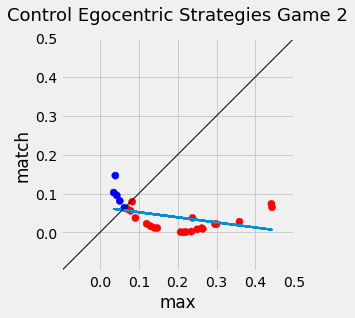

In [93]:
# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(control_jsd_g2['max'], control_jsd_g2['match'], 1)

control_ego_jsd_g2_plot = control_jsd_g2.plot.scatter(x='max',y='match',s=50,color=colors_jsd_control_g2_ego)
plt.title('Control Egocentric Strategies Game 2', fontsize=18, y=1.05)
control_ego_jsd_g2_plot.plot(control_jsd_g2['max'], m*control_jsd_g2['max'] + b, linewidth=2)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)

#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])

line1 = mlines.Line2D([-1, .5],[-1, .5], color='black', linewidth=1)
control_ego_jsd_g2_plot.add_line(line1)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('control_ego_jsd_2.eps',format='eps',bbox_inches='tight',dpi=1000)
plt.show()

# SMAB4 Joint Analysis

In [94]:
# In[ ]:


'''#under line = matching (closer to 0)
#plots of atual jsd values
control_joint_jsd_g2_plot = control_jsd_g2.plot.scatter(x='rand',y='soc',s=50,color=colors_jsd_control_g2_joint,title='Control Social Strategies Game 2')
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

#make axes equal length
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()


#add legend FIX
#from numpy.random import randn
#z = randn(100)
#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)
#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])



#add line
line1 = mlines.Line2D([-1, .5],[-1, .5], color='black')
control_joint_jsd_g2_plot.add_line(line1)



plt.savefig('control_joint_jsd_1.eps',format='eps',dpi=1000)
plt.show()

# save as jpeg
control_joint_jsd_g2_plot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)'''

'#under line = matching (closer to 0)\n#plots of atual jsd values\ncontrol_joint_jsd_g2_plot = control_jsd_g2.plot.scatter(x=\'rand\',y=\'soc\',s=50,color=colors_jsd_control_g2_joint,title=\'Control Social Strategies Game 2\')\nplt.xticks(np.arange(0, 1, step=0.1))\nplt.yticks(np.arange(0, 1, step=0.1))\n#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color=\'red\')\n#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])\n\n#plt.xlabel(\'Match\')\n#plt.ylabel(\'Maximize\')\n\nplt.ylim(-.1, .5)\nplt.xlim(-.1, .5)\n\n#make axes equal length\nplt.gca().set_aspect(\'equal\', adjustable=\'box\')\nplt.draw()\n\n\n#add legend FIX\n#from numpy.random import randn\n#z = randn(100)\n#blue_dot, = plt.plot(z, "bo", markersize=10)\n#red_dot, = plt.plot(z, "ro", markersize=10)\n#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])\n\n\n\n#add line\nline1 = mlines.Line2D([-1, .5],[-1, .5], color=\'black\')\ncontrol_joint_jsd_g2_plot.add_line(line1)\n\n\n\nplt.savefig(\'control_joint_jsd_1.eps\',form

In [95]:
'''Here we load the csv files into Pandas dataframes by calling organize_trial_by_trial and get the score of each subject 
in each game by calling call_get_score.'''


df = organize_trial_by_trial('data/j01_gamedata.csv')
j01 = df
j01_p1_g1_score,j01_p1_g2_score,j01_p2_g1_score,j01_p2_g2_score,j01_p1_diff,j01_p2_diff,j01_p1_g1_50,j01_p1_g2_50,j01_p2_g1_50,j01_p2_g2_50= call_get_score(j01, 'j')
j01.head()

df = organize_trial_by_trial('data/j02_gamedata.csv')
j02 = df
j02_p1_g1_score,j02_p1_g2_score,j02_p2_g1_score,j02_p2_g2_score,j02_p1_diff,j02_p2_diff,j02_p1_g1_50,j02_p1_g2_50,j02_p2_g1_50,j02_p2_g2_50 = call_get_score(j02, 'j')
j02.head()


df = organize_trial_by_trial('data/j03_gamedata.csv')
j03 = df
j03_p1_g1_score,j03_p1_g2_score,j03_p2_g1_score,j03_p2_g2_score,j03_p1_diff,j03_p2_diff,j03_p1_g1_50,j03_p1_g2_50,j03_p2_g1_50,j03_p2_g2_50 = call_get_score(j03, 'j')
j03.head()


df = organize_trial_by_trial('data/j04_gamedata.csv')
j04 = df
j04_p1_g1_score,j04_p1_g2_score,j04_p2_g1_score,j04_p2_g2_score,j04_p1_diff,j04_p2_diff,j04_p1_g1_50,j04_p1_g2_50,j04_p2_g1_50,j04_p2_g2_50 = call_get_score(j04, 'j')
j04.head()


df = organize_trial_by_trial('data/j05_gamedata.csv')
j05 = df
j05_p1_g1_score,j05_p1_g2_score,j05_p2_g1_score,j05_p2_g2_score,j05_p1_diff,j05_p2_diff,j05_p1_g1_50,j05_p1_g2_50,j05_p2_g1_50,j05_p2_g2_50 = call_get_score(j05, 'j')
j05.head()


df = organize_trial_by_trial('data/j06_gamedata.csv')
j06 = df
j06_p1_g1_score,j06_p1_g2_score,j06_p2_g1_score,j06_p2_g2_score,j06_p1_diff,j06_p2_diff,j06_p1_g1_50,j06_p1_g2_50,j06_p2_g1_50,j06_p2_g2_50 = call_get_score(j06, 'j')
j06.head()


df = organize_trial_by_trial('data/j07_gamedata.csv')
j07 = df
j07_p1_g1_score,j07_p1_g2_score,j07_p2_g1_score,j07_p2_g2_score,j07_p1_diff,j07_p2_diff,j07_p1_g1_50,j07_p1_g2_50,j07_p2_g1_50,j07_p2_g2_50 = call_get_score(j07, 'j')
j07.head()


df = organize_trial_by_trial('data/j08_gamedata.csv')
j08 = df
j08_p1_g1_score,j08_p1_g2_score,j08_p2_g1_score,j08_p2_g2_score,j08_p1_diff,j08_p2_diff,j08_p1_g1_50,j08_p1_g2_50,j08_p2_g1_50,j08_p2_g2_50 = call_get_score(j08, 'j')
j08.head()


df = organize_trial_by_trial_floatclick('data/j10_gamedata.csv')
j10 = df
j10_p1_g1_score,j10_p1_g2_score,j10_p2_g1_score,j10_p2_g2_score,j10_p1_diff,j10_p2_diff,j10_p1_g1_50,j10_p1_g2_50,j10_p2_g1_50,j10_p2_g2_50 = call_get_score(j10, 'j')
j10.head()


df = organize_trial_by_trial_floatclick('data/j11_gamedata.csv')
j11 = df
j11_p1_g1_score,j11_p1_g2_score,j11_p2_g1_score,j11_p2_g2_score,j11_p1_diff,j11_p2_diff,j11_p1_g1_50,j11_p1_g2_50,j11_p2_g1_50,j11_p2_g2_50 = call_get_score(j11, 'j')
j11.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,90,0,0
1,1,1,2,1,90,1,0
2,1,2,1,2,60,1,0
3,1,2,2,3,30,1,0
4,1,3,1,3,90,1,0


In [96]:
'''Here we separate the dataframes by suject and game by calling separate_df. We also create arrays with the number of
times that each subject chose each hole by calling value_counts.'''

j01_p1_g1, j01_p1_g2, j01_p2_g1, j01_p2_g2 = separate_df(j01, 'j')
j02_p1_g1, j02_p1_g2, j02_p2_g1, j02_p2_g2 = separate_df(j02, 'j')
j03_p1_g1, j03_p1_g2, j03_p2_g1, j03_p2_g2 = separate_df(j03, 'j')
j04_p1_g1, j04_p1_g2, j04_p2_g1, j04_p2_g2 = separate_df(j04, 'j')
j05_p1_g1, j05_p1_g2, j05_p2_g1, j05_p2_g2 = separate_df(j05, 'j')
j06_p1_g1, j06_p1_g2, j06_p2_g1, j06_p2_g2 = separate_df(j06, 'j')
j07_p1_g1, j07_p1_g2, j07_p2_g1, j07_p2_g2 = separate_df(j07, 'j')
j08_p1_g1, j08_p1_g2, j08_p2_g1, j08_p2_g2 = separate_df(j08, 'j')
j10_p1_g1, j10_p1_g2, j10_p2_g1, j10_p2_g2 = separate_df(j10, 'j')
j11_p1_g1, j11_p1_g2, j11_p2_g1, j11_p2_g2 = separate_df(j11, 'j')



j01_p1_g1_count = j01_p1_g1['probability'].value_counts(sort=False)
j01_p1_g2_count = j01_p1_g2['probability'].value_counts(sort=False)
j01_p2_g1_count = j01_p2_g1['probability'].value_counts(sort=False)
j01_p2_g2_count = j01_p2_g2['probability'].value_counts(sort=False)
j02_p1_g1_count = j02_p1_g1['probability'].value_counts(sort=False)
j02_p1_g2_count = j02_p1_g2['probability'].value_counts(sort=False)
j02_p2_g1_count = j02_p2_g1['probability'].value_counts(sort=False)
j02_p2_g2_count = j02_p2_g2['probability'].value_counts(sort=False)
j03_p1_g1_count = j03_p1_g1['probability'].value_counts(sort=False)
j03_p1_g2_count = j03_p1_g2['probability'].value_counts(sort=False)
j03_p2_g1_count = j03_p2_g1['probability'].value_counts(sort=False)
j03_p2_g2_count = j03_p2_g2['probability'].value_counts(sort=False)
j04_p1_g1_count = j04_p1_g1['probability'].value_counts(sort=False)
j04_p1_g2_count = j04_p1_g2['probability'].value_counts(sort=False)
j04_p2_g1_count = j04_p2_g1['probability'].value_counts(sort=False)
j04_p2_g2_count = j04_p2_g2['probability'].value_counts(sort=False)
j05_p1_g1_count = j05_p1_g1['probability'].value_counts(sort=False)
j05_p1_g2_count = j05_p1_g2['probability'].value_counts(sort=False)
j05_p2_g1_count = j05_p2_g1['probability'].value_counts(sort=False)
j05_p2_g2_count = j05_p2_g2['probability'].value_counts(sort=False)
j06_p1_g1_count = j06_p1_g1['probability'].value_counts(sort=False)
j06_p1_g2_count = j06_p1_g2['probability'].value_counts(sort=False)
j06_p2_g1_count = j06_p2_g1['probability'].value_counts(sort=False)
j06_p2_g2_count = j06_p2_g2['probability'].value_counts(sort=False)
j07_p1_g1_count = j07_p1_g1['probability'].value_counts(sort=False)
j07_p1_g2_count = j07_p1_g2['probability'].value_counts(sort=False)
j07_p2_g1_count = j07_p2_g1['probability'].value_counts(sort=False)
j07_p2_g2_count = j07_p2_g2['probability'].value_counts(sort=False)
j08_p1_g1_count = j08_p1_g1['probability'].value_counts(sort=False)
j08_p1_g2_count = j08_p1_g2['probability'].value_counts(sort=False)
j08_p2_g1_count = j08_p2_g1['probability'].value_counts(sort=False)
j08_p2_g2_count = j08_p2_g2['probability'].value_counts(sort=False)
j10_p1_g1_count = j10_p1_g1['probability'].value_counts(sort=False)
j10_p1_g2_count = j10_p1_g2['probability'].value_counts(sort=False)
j10_p2_g1_count = j10_p2_g1['probability'].value_counts(sort=False)
j10_p2_g2_count = j10_p2_g2['probability'].value_counts(sort=False)
j11_p1_g1_count = j11_p1_g1['probability'].value_counts(sort=False)
j11_p1_g2_count = j11_p1_g2['probability'].value_counts(sort=False)
j11_p2_g1_count = j11_p2_g1['probability'].value_counts(sort=False)
j11_p2_g2_count = j11_p2_g2['probability'].value_counts(sort=False)

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_

In [97]:
'''Here we create dataframes with all of the scores of each subject in games 1 and 2. 50 refers to the score half-way
through the games'''


# # Combined Joint scores G1

j_scores_1 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'score_1':
     [j01_p1_g1_score, j01_p2_g1_score, j02_p1_g1_score, j02_p2_g1_score, j03_p1_g1_score, j03_p2_g1_score,
      j04_p1_g1_score, j04_p2_g1_score, j05_p1_g1_score, j05_p2_g1_score, j06_p1_g1_score, j06_p2_g1_score,
      j07_p1_g1_score, j07_p2_g1_score, j08_p1_g1_score, j08_p2_g1_score, j10_p1_g1_score, j10_p2_g1_score, j11_p1_g1_score, j11_p2_g1_score]})
j_scores_1.set_index('participant', inplace=True, drop=True)
j_scores_1


# # Combined Joint scores G2

# In[ ]:


j_scores_2 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'score_2':
     [j01_p1_g2_score, j01_p2_g2_score, j02_p1_g2_score, j02_p2_g2_score, j03_p1_g2_score, j03_p2_g2_score,
      j04_p1_g2_score, j04_p2_g2_score, j05_p1_g2_score, j05_p2_g2_score, j06_p1_g2_score, j06_p2_g2_score,
      j07_p1_g2_score, j07_p2_g2_score, j08_p1_g2_score, j08_p2_g2_score, j10_p1_g2_score, j10_p2_g2_score, j11_p1_g2_score, j11_p2_g2_score]})
j_scores_2.set_index('participant', inplace=True, drop=True)
j_scores_2



j_scores_1_50 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'score_1_50':
     [j01_p1_g1_50, j01_p2_g1_50, j02_p1_g1_50, j02_p2_g1_50, j03_p1_g1_50, j03_p2_g1_50,
      j04_p1_g1_50, j04_p2_g1_50, j05_p1_g1_50, j05_p2_g1_50, j06_p1_g1_50, j06_p2_g1_50,
      j07_p1_g1_50, j07_p2_g1_50, j08_p1_g1_50, j08_p2_g1_50, j10_p1_g1_50, j10_p2_g1_50, j11_p1_g1_50, j11_p2_g1_50]})
j_scores_1_50.set_index('participant', inplace=True, drop=True)




j_scores_2_50 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'score_2_50':
     [j01_p1_g2_50, j01_p2_g2_50, j02_p1_g2_50, j02_p2_g2_50, j03_p1_g2_50, j03_p2_g2_50,
      j04_p1_g2_50, j04_p2_g2_50, j05_p1_g2_50, j05_p2_g2_50, j06_p1_g2_50, j06_p2_g2_50,
      j07_p1_g2_50, j07_p2_g2_50, j08_p1_g2_50, j08_p2_g2_50, j10_p1_g2_50, j10_p2_g2_50, j11_p1_g2_50, j11_p2_g2_50]})
j_scores_2_50.set_index('participant', inplace=True, drop=True)



In [98]:
'''Here we combine the dataframes with the scores from the 2 games.'''
j_scores_50 = j_scores_1_50.merge(j_scores_2_50,right_index=True,left_index=True)
j_scores = j_scores_1.merge(j_scores_2,right_index=True,left_index=True)
j_combo = j_scores_50.merge(j_scores,right_index=True,left_index=True)

#rename columns
#c_combo.columns=["score_1_50", "score_2_50", "score_1", "score_2"]

In [99]:
j_combo

,score_1_50,score_2_50,score_1,score_2
participant,,,,
j01_p1,26,37,57,73
j01_p2,30,27,61,60
j02_p1,25,35,54,72
j02_p2,37,29,68,76
j03_p1,30,38,69,82
j03_p2,32,33,67,75
j04_p1,31,29,64,60
j04_p2,26,24,56,54
j05_p1,36,29,77,70


In [100]:
''''#Combined Joint scores G1 and G2

j_scores = pd.merge(j_scores_1, j_scores_2, on = 'participant')
j_scores.columns=['Game 1','Game 2']
#jp1_scores.set_index('participant', inplace=True, drop=True)
j_scores'''

"'#Combined Joint scores G1 and G2\n\nj_scores = pd.merge(j_scores_1, j_scores_2, on = 'participant')\nj_scores.columns=['Game 1','Game 2']\n#jp1_scores.set_index('participant', inplace=True, drop=True)\nj_scores"

In [101]:
'''Here we get the mean, median, and standard deviation of the scores. We also run a t-test comparing the scores in games 1 and 2
and plot the data.'''

j_scores_1_mean = j_scores_1.mean()


# In[ ]:


j_scores_1_mean


# In[ ]:


j_scores_1_std = j_scores_1.std()


# In[ ]:


j_scores_1_std


# In[ ]:


j_scores_2_mean = j_scores_2.mean()


# In[ ]:


j_scores_2_mean


# In[ ]:


j_scores_2_std = j_scores_2.std()


# In[ ]:


j_scores_2_std


# In[ ]:


j_scores_med = j_scores.median()
j_scores_med


# In[ ]:

score_1    66.5
score_2    75.5
dtype: float64

In [102]:
#j_scores_p = sp.stats.ttest_rel(j_scores['Game 1'],j_scores['Game 2'])

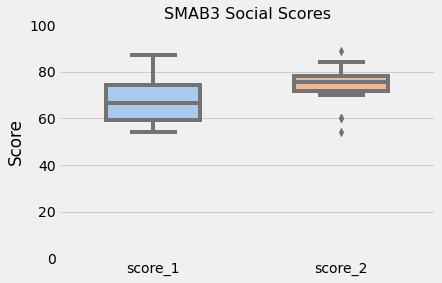

In [103]:
j_scores_box = sns.boxplot( 
                 data=j_scores, 
                 width=0.5,
                 palette="pastel")
j_scores_box.axes.set_title("SMAB3 Social Scores",
                    fontsize=16)

plot_file_name="j_score_box.jpg"
 
plt.ylim(0, 100)
j_scores_box.axes.set(ylabel='Score')

# save as jpeg
j_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

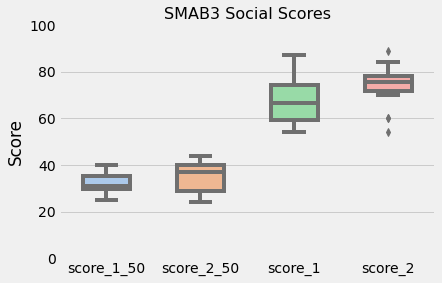

In [104]:
j_combo_box = sns.boxplot( 
                 data=j_combo, order = ['score_1_50','score_2_50','score_1','score_2'],
                 width=0.5,
                 palette="pastel")
j_combo_box.axes.set_title("SMAB3 Social Scores",
                    fontsize=16)

plot_file_name="j_score_box.jpg"
 
plt.ylim(0, 100)
j_combo_box.axes.set(ylabel='Score')

# save as jpeg
j_combo_box.figure.savefig(plot_file_name,
                    format='jpeg')

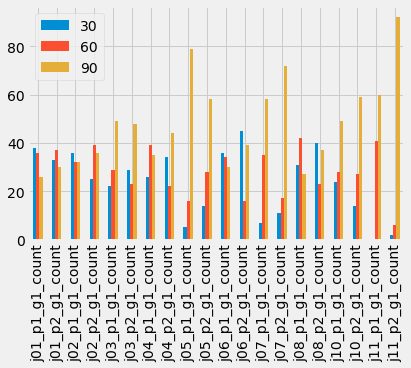

In [105]:
'''Here we place all of the data into the number of times each subject chose each hole into dataframes for games 1 
and 2. We plot this data and run statistics on it.'''

# # Joint combined choices in G1



j_g1_counts = pd.DataFrame([j01_p1_g1_count, j01_p2_g1_count, j02_p1_g1_count, j02_p2_g1_count, j03_p1_g1_count, 
              j03_p2_g1_count, j04_p1_g1_count, j04_p2_g1_count, j05_p1_g1_count, j05_p2_g1_count, j06_p1_g1_count, 
              j06_p2_g1_count, j07_p1_g1_count, j07_p2_g1_count, j08_p1_g1_count, j08_p2_g1_count, 
              j10_p1_g1_count, j10_p2_g1_count, j11_p1_g1_count, j11_p2_g1_count],
                index = ['j01_p1_g1_count', 'j01_p2_g1_count', 'j02_p1_g1_count', 'j02_p2_g1_count', 
                 'j03_p1_g1_count', 'j03_p2_g1_count', 'j04_p1_g1_count', 'j04_p2_g1_count', 'j05_p1_g1_count', 
                  'j05_p2_g1_count', 'j06_p1_g1_count', 'j06_p2_g1_count', 'j07_p1_g1_count', 
                    'j07_p2_g1_count', 'j08_p1_g1_count', 'j08_p2_g1_count', 'j10_p1_g1_count', 'j10_p2_g1_count', 
                    'j11_p1_g1_count', 'j11_p2_g1_count'])


# In[ ]:


j_g1_counts = j_g1_counts.fillna(0)


# In[ ]:


j_g1_counts 


# In[ ]:


j_g1_counts.sum(axis=1)


# In[ ]:


j_g1_counts_bar = j_g1_counts.plot.bar()

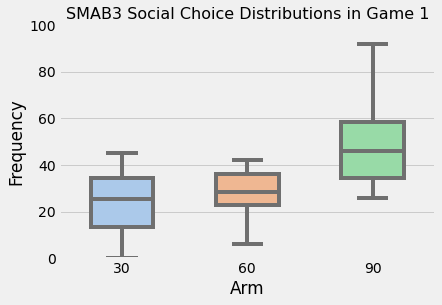

In [106]:
# In[ ]:


j_g1_counts_box = sns.boxplot( 
                 data=j_g1_counts, 
                 width=0.5,
                 palette="pastel")
j_g1_counts_box.axes.set_title("SMAB3 Social Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="j_g1_counts_box.jpg"
 
plt.ylim(0, 100)
j_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')


# In[ ]:

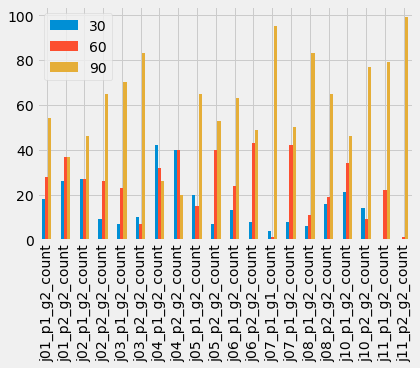

In [107]:
j_g1_low = np.mean(j_g1_counts.iloc[:,0])
j_g1_med = np.mean(j_g1_counts.iloc[:,1])
j_g1_high = np.mean(j_g1_counts.iloc[:,2])


# In[ ]:


j_g1_low


# In[ ]:


j_g1_med


# In[ ]:


j_g1_high


# In[ ]:


j_g1_low_std = np.std(j_g1_counts.iloc[:,0])
j_g1_med_std = np.std(j_g1_counts.iloc[:,1])
j_g1_high_std = np.std(j_g1_counts.iloc[:,2])


# In[ ]:


j_g1_low_std


# In[ ]:


j_g1_med_std


# In[ ]:


j_g1_high_std


# # Joint combined choices in G2

# In[ ]:


j_g2_counts = pd.DataFrame([j01_p1_g2_count, j01_p2_g2_count, j02_p1_g2_count, j02_p2_g2_count, j03_p1_g2_count, 
              j03_p2_g2_count, j04_p1_g2_count, j04_p2_g2_count, j05_p1_g2_count, j05_p2_g2_count, j06_p1_g2_count, 
              j06_p2_g2_count, j07_p1_g2_count, j07_p2_g2_count, j08_p1_g2_count, j08_p2_g2_count, 
              j10_p1_g2_count, j10_p2_g2_count, j11_p1_g2_count, j11_p2_g2_count],
                index = ['j01_p1_g2_count', 'j01_p2_g2_count', 'j02_p1_g2_count', 'j02_p2_g2_count', 
                 'j03_p1_g2_count', 'j03_p2_g2_count', 'j04_p1_g2_count', 'j04_p2_g2_count', 'j05_p1_g2_count', 
                  'j05_p2_g2_count', 'j06_p1_g2_count', 'j06_p2_g2_count', 'j07_p1_g1_count', 'j07_p1_g2_count', 
                 'j08_p1_g2_count', 'j08_p2_g2_count', 'j10_p1_g2_count', 'j10_p2_g2_count', 
                    'j11_p1_g2_count', 'j11_p2_g2_count'])


# In[ ]:


j_g2_counts = j_g2_counts.fillna(0)
j_g2_counts 


# In[ ]:


j_g2_counts.sum(axis=1)


# In[ ]:


j_g2_counts_bar = j_g2_counts.plot.bar()

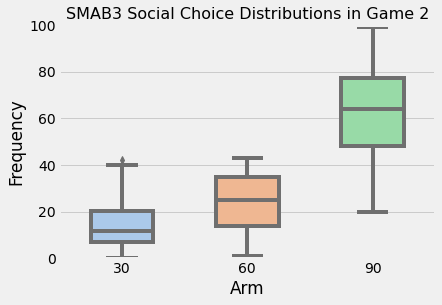

In [108]:
# In[ ]:


j_g2_counts_box = sns.boxplot( 
                 data=j_g2_counts, 
                 width=0.5,
                 palette="pastel")
j_g2_counts_box.axes.set_title("SMAB3 Social Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="j_g2_counts_box.jpg"
 
plt.ylim(0, 100)
j_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [109]:
# In[ ]:


j_g2_low = np.mean(j_g2_counts.iloc[:,0])
j_g2_med = np.mean(j_g2_counts.iloc[:,1])
j_g2_high = np.mean(j_g2_counts.iloc[:,2])


# In[ ]:


j_g2_low


# In[ ]:


j_g2_med


# In[ ]:


j_g2_high


# In[ ]:


j_g2_low_std = np.std(j_g2_counts.iloc[:,0])
j_g2_med_std = np.std(j_g2_counts.iloc[:,1])
j_g2_high_std = np.std(j_g2_counts.iloc[:,2])


# In[ ]:


j_g2_low_std


# In[ ]:


j_g2_med_std


# In[ ]:


j_g2_high_std

20.72408019671802

In [110]:
j_g1_counts

,30,60,90
j01_p1_g1_count,38.0,36.0,26.0
j01_p2_g1_count,33.0,37.0,30.0
j02_p1_g1_count,36.0,32.0,32.0
j02_p2_g1_count,25.0,39.0,36.0
j03_p1_g1_count,22.0,29.0,49.0
j03_p2_g1_count,29.0,23.0,48.0
j04_p1_g1_count,26.0,39.0,35.0
j04_p2_g1_count,34.0,22.0,44.0
j05_p1_g1_count,5.0,16.0,79.0
j05_p2_g1_count,14.0,28.0,58.0


In [111]:
#combine joint hole count dataframes 
#make index just the participant code
#combine control_counts_2 and control_counts_1

#modify the index to be only participant
subjects_1 = j_g1_counts.index.to_numpy()
subjects_2 = j_g2_counts.index.to_numpy()

subjects_new1 = np.array([])
subjects_new2 = np.array([])

ii = 0
for i in subjects_1:
    subjects_new1 = np.append(subjects_new1,subjects_1[ii][0:6])
    ii = ii +1
    
iii = 0
for i in subjects_2:
    subjects_new2 = np.append(subjects_new2,subjects_2[iii][0:6])
    iii = iii +1

j_g1_counts.index = subjects_new1
j_g2_counts.index = subjects_new2

j_counts = j_g1_counts.merge(j_g2_counts,right_index=True,left_index=True)

In [112]:
j_counts

,30_x,60_x,90_x,30_y,60_y,90_y
j01_p1,38.0,36.0,26.0,18.0,28.0,54.0
j01_p2,33.0,37.0,30.0,26.0,37.0,37.0
j02_p1,36.0,32.0,32.0,27.0,27.0,46.0
j02_p2,25.0,39.0,36.0,9.0,26.0,65.0
j03_p1,22.0,29.0,49.0,7.0,23.0,70.0
j03_p2,29.0,23.0,48.0,10.0,7.0,83.0
j04_p1,26.0,39.0,35.0,42.0,32.0,26.0
j04_p2,34.0,22.0,44.0,40.0,40.0,20.0
j05_p1,5.0,16.0,79.0,20.0,15.0,65.0
j05_p2,14.0,28.0,58.0,7.0,40.0,53.0


In [113]:
'''Here we combine the separate the counts of each hole into separate arrays. We run t-tests to compare the counts
of each hole in each game.'''


# # Joint combined arrays

# In[ ]:


#pip install researchpy


# In[ ]:


import researchpy as rp


# In[ ]:


j_90_1 = np.array(j_g1_counts.iloc[:,2])
j_90_2 = np.array(j_g2_counts.iloc[:,2])


# In[ ]:


j_90_1


# In[ ]:


j_90_2


# In[ ]:


j_60_1 = np.array(j_g1_counts.iloc[:,1])
j_60_2 = np.array(j_g2_counts.iloc[:,1])


# In[ ]:


j_60_1


# In[ ]:


j_60_2


# In[ ]:


j_30_1 = np.array(j_g1_counts.iloc[:,0])
j_30_2 = np.array(j_g2_counts.iloc[:,0])


# In[ ]:


j_30_1


# In[ ]:


j_30_2


# # Joint combined choice statistics

# In[ ]:


j_90_p = sp.stats.ttest_rel(j_90_1,j_90_2)
j_60_p = sp.stats.ttest_rel(j_60_1,j_60_2)
j_30_p = sp.stats.ttest_rel(j_30_1,j_30_2)


# In[ ]:


j_90_p


# In[ ]:


j_60_p


# In[ ]:


j_30_p

Ttest_relResult(statistic=2.8916950793464284, pvalue=0.009347666583121904)

# SMAB4 Joint Data 

In [191]:
'''Here we load the csv files into pandas dataframes by calling organize_trial_by_trial and get the scores in games
1 and 2 by calling call_get_score.'''

# # Multi Analysis


df = organize_trial_by_trial('data/m05_gamedata.csv')
m05 = df
m05_p1_g1_score,m05_p1_g2_score,m05_p2_g1_score,m05_p2_g2_score,m05_p1_diff,m05_p2_diff,m05_p1_g1_50,m05_p1_g2_50,m05_p2_g1_50,m05_p2_g2_50 = call_get_score(m05, 'm')
m05.head()


# In[ ]:


df = organize_trial_by_trial_floatclick('data/m06_gamedata.csv')
m06 = df
m06_p1_g1_score,m06_p1_g2_score,m06_p2_g1_score,m06_p2_g2_score,m06_p1_diff,m06_p2_diff,m06_p1_g1_50,m06_p1_g2_50,m06_p2_g1_50,m06_p2_g2_50 = call_get_score(m06, 'm')
m06.head()


# In[ ]:


df = organize_trial_by_trial_floatclick('data/m08_gamedata.csv')
m08 = df
m08_p1_g1_score,m08_p1_g2_score,m08_p2_g1_score,m08_p2_g2_score,m08_p1_diff,m08_p2_diff,m08_p1_g1_50,m08_p1_g2_50,m08_p2_g1_50,m08_p2_g2_50 = call_get_score(m08, 'm')
m08.head()


# In[ ]:


# In[ ]:


df = organize_trial_by_trial_floatclick('data/m10_gamedata.csv')
m10 = df
m10_p1_g1_score,m10_p1_g2_score,m10_p2_g1_score,m10_p2_g2_score,m10_p1_diff,m10_p2_diff,m10_p1_g1_50,m10_p1_g2_50,m10_p2_g1_50,m10_p2_g2_50 = call_get_score(m10, 'm')
m10.head()


# In[ ]:


df = organize_trial_by_trial_floatclick('data/m11_gamedata.csv')
m11 = df
m11_p1_g1_score,m11_p1_g2_score,m11_p2_g1_score,m11_p2_g2_score,m11_p1_diff,m11_p2_diff,m11_p1_g1_50,m11_p1_g2_50,m11_p2_g1_50,m11_p2_g2_50 = call_get_score(m11, 'm')
m11.head()


# In[ ]:


#df = organize_trial_by_trial_floatclick('data/m12_gamedata.csv')
#m12 = df
#m12_p1_g1_score,m12_p1_g2_score,m12_p2_g1_score,m12_p2_g2_score,m12_p1_score_diff,m12_p2_score_diff = call_get_score(m12, 'm')
#m12.head()


# In[ ]:


df = organize_trial_by_trial_floatclick('data/m13_gamedata.csv')
m13 = df
m13_p1_g1_score,m13_p1_g2_score,m13_p2_g1_score,m13_p2_g2_score,m13_p1_diff,m13_p2_diff,m13_p1_g1_50,m13_p1_g2_50,m13_p2_g1_50,m13_p2_g2_50 = call_get_score(m13, 'm')
m13.head()


# In[ ]:


df = organize_trial_by_trial_floatclick('data/m14_gamedata.csv')
m14 = df
m14_p1_g1_score,m14_p1_g2_score,m14_p2_g1_score,m14_p2_g2_score,m14_p1_diff,m14_p2_diff,m14_p1_g1_50,m14_p1_g2_50,m14_p2_g1_50,m14_p2_g2_50 = call_get_score(m14, 'm')
m14.head()


# In[ ]:


m05_p1_g1, m05_p1_g2, m05_p2_g1, m05_p2_g2 = separate_df(m05, 'm')
m06_p1_g1, m06_p1_g2, m06_p2_g1, m06_p2_g2 = separate_df(m06, 'm')
m08_p1_g1, m08_p1_g2, m08_p2_g1, m08_p2_g2 = separate_df(m08, 'm')
m10_p1_g1, m10_p1_g2, m10_p2_g1, m10_p2_g2 = separate_df(m10, 'm')
m11_p1_g1, m11_p1_g2, m11_p2_g1, m11_p2_g2 = separate_df(m11, 'm')
m13_p1_g1, m13_p1_g2, m13_p2_g1, m13_p2_g2 = separate_df(m13, 'm')
m14_p1_g1, m14_p1_g2, m14_p2_g1, m14_p2_g2 = separate_df(m14, 'm')


# In[ ]:


m05_p1_g1_count = m05_p1_g1['probability'].value_counts(sort=False)
m05_p1_g2_count = m05_p1_g2['probability'].value_counts(sort=False)
m05_p2_g1_count = m05_p2_g1['probability'].value_counts(sort=False)
m05_p2_g2_count = m05_p2_g2['probability'].value_counts(sort=False)
m06_p1_g1_count = m06_p1_g1['probability'].value_counts(sort=False)
m06_p1_g2_count = m06_p1_g2['probability'].value_counts(sort=False)
m06_p2_g1_count = m06_p2_g1['probability'].value_counts(sort=False)
m06_p2_g2_count = m06_p2_g2['probability'].value_counts(sort=False)
m08_p1_g1_count = m08_p1_g1['probability'].value_counts(sort=False)
m08_p1_g2_count = m08_p1_g2['probability'].value_counts(sort=False)
m08_p2_g1_count = m08_p2_g1['probability'].value_counts(sort=False)
m08_p2_g2_count = m08_p2_g2['probability'].value_counts(sort=False)
m10_p1_g1_count = m10_p1_g1['probability'].value_counts(sort=False)
m10_p1_g2_count = m10_p1_g2['probability'].value_counts(sort=False)
m10_p2_g1_count = m10_p2_g1['probability'].value_counts(sort=False)
m10_p2_g2_count = m10_p2_g2['probability'].value_counts(sort=False)
m11_p1_g1_count = m11_p1_g1['probability'].value_counts(sort=False)
m11_p1_g2_count = m11_p1_g2['probability'].value_counts(sort=False)
m11_p2_g1_count = m11_p2_g1['probability'].value_counts(sort=False)
m11_p2_g2_count = m11_p2_g2['probability'].value_counts(sort=False)
m13_p1_g1_count = m13_p1_g1['probability'].value_counts(sort=False)
m13_p1_g2_count = m13_p1_g2['probability'].value_counts(sort=False)
m13_p2_g1_count = m13_p2_g1['probability'].value_counts(sort=False)
m13_p2_g2_count = m13_p2_g2['probability'].value_counts(sort=False)
m14_p1_g1_count = m14_p1_g1['probability'].value_counts(sort=False)
m14_p1_g2_count = m14_p1_g2['probability'].value_counts(sort=False)
m14_p2_g1_count = m14_p2_g1['probability'].value_counts(sort=False)
m14_p2_g2_count = m14_p2_g2['probability'].value_counts(sort=False)

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_

In [198]:
#importing m09- 1st 12 trials missing- 6 for each player
reader = csv.reader( open('data/m09_gamedata.csv'))
game_data = [row for row in reader]
df = pd.DataFrame(np.array(game_data))
df = df.T
#column headings all wrong
df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward", 6:"time", 7:"P1 score", 8:"P2 score"})
#drops first 20 trials of game 1
#remove if you want to analyze the whole session
#df = df[40:]
#df = df.drop(columns = 'time') #can comment this out if want to look at time
df = df.drop(['reward'], axis=1)
m09 = df.apply(pd.to_numeric)
m09.head()



''''df = organize_trial_by_trial_floatclick('data/m09_gamedata.csv')
m09 = df
m09_p1_g1_score,m09_p1_g2_score,m09_p2_g1_score,m09_p2_g2_score,m09_p1_score_diff,m09_p2_score_diff = call_get_score(m09, 'm')
m09.head()'''

"'df = organize_trial_by_trial_floatclick('data/m09_gamedata.csv')\nm09 = df\nm09_p1_g1_score,m09_p1_g2_score,m09_p2_g1_score,m09_p2_g2_score,m09_p1_score_diff,m09_p2_score_diff = call_get_score(m09, 'm')\nm09.head()"

In [208]:
reader = csv.reader( open('data/s01_gamedata.csv'))
game_data = [row for row in reader]
df = pd.DataFrame(np.array(game_data))
df = df.T
#column headings all wrong
#df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward", 6:"time", 7:"P1 score", 8:"P2 score"})
#drops first 20 trials of game 1
#remove if you want to analyze the whole session
#df = df[40:]
#df = df.drop(columns = 'time') #can comment this out if want to look at time
#df = df.drop(['reward'], axis=1)
s01 = df.apply(pd.to_numeric)
s01

,0,1,2,3,4,5,6,7,8
0,1,1,1,2,30,1,11.220698,1,0
1,1,1,2,1,90,1,2.742137,1,1
2,1,2,1,3,60,1,5.362458,2,1
3,1,2,2,1,90,1,3.699948,2,2
4,1,3,1,2,30,0,3.489552,2,2
5,1,3,2,1,90,1,3.218956,2,3
6,1,4,1,3,60,0,3.210886,2,3
7,1,4,2,1,90,1,2.978648,2,4
8,1,5,1,3,60,1,2.904784,3,4
9,1,5,2,1,90,1,3.196655,3,5


In [206]:
reader = csv.reader( open('data/s12_gamedata.csv'))
game_data = [row for row in reader]
df = pd.DataFrame(np.array(game_data))
df = df.T
#column headings all wrong
#df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward", 6:"time", 7:"P1 score", 8:"P2 score"})
#drops first 20 trials of game 1
#remove if you want to analyze the whole session
#df = df[40:]
#df = df.drop(columns = 'time') #can comment this out if want to look at time
#df = df.drop(['reward'], axis=1)
s12 = df.apply(pd.to_numeric)
s12

,0,1,2,3,4,5,6,7,8,9
0,300,1,1,1,1,90,1,25.567801,1,0
1,300,1,1,2,1,90,1,8.335537,1,1
2,300,1,2,1,3,30,0,3.291428,1,1
3,300,1,2,2,2,60,1,3.386384,1,2
4,300,1,3,1,1,90,1,3.559303,2,2
5,300,1,3,2,2,60,0,3.846164,2,2
6,300,1,4,1,3,30,0,8.284046,2,2
7,300,1,4,2,1,90,1,9.645399,2,3
8,300,1,5,1,1,90,1,2.605756,3,3
9,300,1,5,2,1,90,1,2.286909,3,4


In [197]:
m09

,game number,trial,player,arm,probability,time,P1 score
0,200,1,13,2,1,4,3
1,200,1,14,1,2,4,4
2,200,1,15,2,1,5,4
3,200,1,16,1,1,5,4
4,200,1,17,2,3,6,4
5,200,1,18,1,2,6,5
6,200,1,19,2,1,7,5
7,200,1,20,1,3,7,5
8,200,1,21,2,1,7,5
9,200,1,22,1,2,7,6


In [115]:
# # Combined multi scores G1

# In[ ]:


m_scores_1 = pd.DataFrame({'participant':['m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1':
     [m05_p1_g1_score, m05_p2_g1_score, m06_p1_g1_score, m06_p2_g1_score, m08_p1_g1_score, m08_p2_g1_score,
      m10_p1_g1_score, m10_p2_g1_score, m11_p1_g1_score, m11_p2_g1_score, m13_p1_g1_score, m13_p2_g1_score,
      m14_p1_g1_score, m14_p2_g1_score]})
m_scores_1.set_index('participant', inplace=True, drop=True)
m_scores_1


# # Combined multi scores G2

# In[ ]:


m_scores_2 = pd.DataFrame({'participant':['m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_2':
     [m05_p1_g2_score, m05_p2_g2_score, m06_p1_g2_score, m06_p2_g2_score, m08_p1_g2_score, m08_p2_g2_score,
      m10_p1_g2_score, m10_p2_g2_score, m11_p1_g2_score, m11_p2_g2_score, m13_p1_g2_score, m13_p2_g2_score,
      m14_p1_g2_score, m14_p2_g2_score]})
m_scores_2.set_index('participant', inplace=True, drop=True)
m_scores_2


m_scores_1_50 = pd.DataFrame({'participant':['m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1_50':
     [m05_p1_g1_50, m05_p2_g1_50, m06_p1_g1_50, m06_p2_g1_50, m08_p1_g1_50, m08_p2_g1_50, m10_p1_g1_50, m10_p2_g1_50, m11_p1_g1_50, m11_p2_g1_50, m13_p1_g1_50, m13_p2_g1_50,
     m14_p1_g1_50, m14_p2_g1_50,]})
m_scores_1_50.set_index('participant', inplace=True, drop=True)

m_scores_2_50 = pd.DataFrame({'participant':['m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'score_1_50':
     [m05_p1_g2_50, m05_p2_g2_50, m06_p1_g2_50, m06_p2_g2_50, m08_p1_g2_50, m08_p2_g2_50, m10_p1_g2_50, m10_p2_g2_50, m11_p1_g2_50, m11_p2_g2_50, m13_p1_g2_50, m13_p2_g2_50,
     m14_p1_g2_50, m14_p2_g2_50,]})
m_scores_2_50.set_index('participant', inplace=True, drop=True)

In [116]:
'''Here we combine the dataframes with the scores from the 2 games.'''
m_scores_50 = m_scores_1_50.merge(m_scores_2_50,right_index=True,left_index=True)
m_scores = m_scores_1.merge(m_scores_2,right_index=True,left_index=True)
m_combo = m_scores_50.merge(m_scores,right_index=True,left_index=True)

#rename columns
m_combo.columns=["score_1_50", "score_2_50", "score_1", "score_2"]

In [117]:
''''m_scores = pd.merge(m_scores_1, m_scores_2, on = 'participant')
m_scores.columns=['Game 1','Game 2']
#jp1_scores.set_index('participant', inplace=True, drop=True)
m_scores


# In[ ]:


m_scores_1_mean = m_scores_1.mean()


# In[ ]:


m_scores_1_mean


# In[ ]:


m_scores_1_std = m_scores_1.std()


# In[ ]:


m_scores_1_std


# In[ ]:


m_scores_2_mean = m_scores_2.mean()


# In[ ]:


m_scores_2_mean


# In[ ]:


m_scores_2_std = m_scores_2.std()


# In[ ]:


m_scores_2_std


# In[ ]:


m_scores_med = m_scores.median()
m_scores_med


# In[ ]:


m_scores_p = sp.stats.ttest_rel(m_scores['Game 1'],m_scores['Game 2'])


# In[ ]:


m_scores_p'''

"'m_scores = pd.merge(m_scores_1, m_scores_2, on = 'participant')\nm_scores.columns=['Game 1','Game 2']\n#jp1_scores.set_index('participant', inplace=True, drop=True)\nm_scores\n\n\n# In[ ]:\n\n\nm_scores_1_mean = m_scores_1.mean()\n\n\n# In[ ]:\n\n\nm_scores_1_mean\n\n\n# In[ ]:\n\n\nm_scores_1_std = m_scores_1.std()\n\n\n# In[ ]:\n\n\nm_scores_1_std\n\n\n# In[ ]:\n\n\nm_scores_2_mean = m_scores_2.mean()\n\n\n# In[ ]:\n\n\nm_scores_2_mean\n\n\n# In[ ]:\n\n\nm_scores_2_std = m_scores_2.std()\n\n\n# In[ ]:\n\n\nm_scores_2_std\n\n\n# In[ ]:\n\n\nm_scores_med = m_scores.median()\nm_scores_med\n\n\n# In[ ]:\n\n\nm_scores_p = sp.stats.ttest_rel(m_scores['Game 1'],m_scores['Game 2'])\n\n\n# In[ ]:\n\n\nm_scores_p"

In [118]:
m_combo

,score_1_50,score_2_50,score_1,score_2
participant,,,,
m05_p1,42,34,86,68
m05_p2,41,44,75,86
m06_p1,26,31,57,62
m06_p2,35,35,71,68
m08_p1,31,33,69,80
m08_p2,35,43,82,88
m10_p1,33,31,69,66
m10_p2,23,31,57,62
m11_p1,34,44,80,83


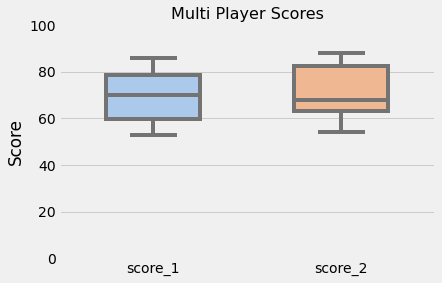

In [119]:
m_scores_box = sns.boxplot( 
                 data=m_scores, 
                 width=0.5,
                 palette="pastel")
m_scores_box.axes.set_title("Multi Player Scores",
                    fontsize=16)

plot_file_name="m_score_box.jpg"
 
plt.ylim(0, 100)
m_scores_box.axes.set(ylabel='Score')

# save as jpeg
m_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')


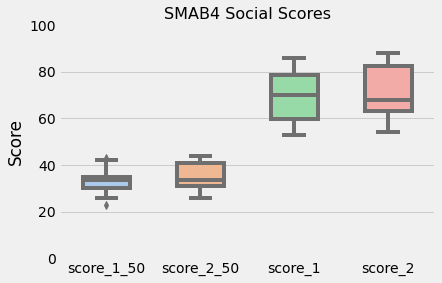

In [120]:
m_combo_box = sns.boxplot( 
                 data=m_combo, order = ['score_1_50','score_2_50','score_1','score_2'],
                 width=0.5,
                 palette="pastel")
m_combo_box.axes.set_title("SMAB4 Social Scores",
                    fontsize=16)

plot_file_name="m_score_box.jpg"
 
plt.ylim(0, 100)
m_combo_box.axes.set(ylabel='Score')

# save as jpeg
m_combo_box.figure.savefig(plot_file_name,
                    format='jpeg')

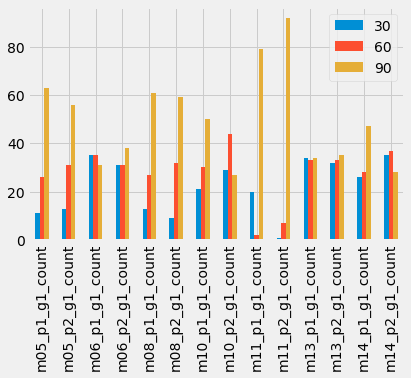

In [121]:
'''Here we place the counts of how many times each hole was chosen into dataframes for games 1 and 2. We also 
get statistics on this data and plot it.'''

# # Multi combined choices in G1

# In[ ]:


m_g1_counts = pd.DataFrame([m05_p1_g1_count, m05_p2_g1_count, m06_p1_g1_count, m06_p2_g1_count, m08_p1_g1_count, m08_p2_g1_count, 
              m10_p1_g1_count, m10_p2_g1_count, m11_p1_g1_count, m11_p2_g1_count, m13_p1_g1_count, m13_p2_g1_count, 
              m14_p1_g1_count, m14_p2_g1_count],
                index = ['m05_p1_g1_count', 'm05_p2_g1_count', 'm06_p1_g1_count', 'm06_p2_g1_count',
                 'm08_p1_g1_count', 'm08_p2_g1_count', 'm10_p1_g1_count', 'm10_p2_g1_count', 'm11_p1_g1_count', 
                'm11_p2_g1_count', 'm13_p1_g1_count', 'm13_p2_g1_count', 'm14_p1_g1_count', 'm14_p2_g1_count'])


# In[ ]:


m_g1_counts = m_g1_counts.fillna(0) 


# In[ ]:


m_g1_counts


# In[ ]:


m_g1_counts.sum(axis=1)


# In[ ]:


m_g1_counts_bar = m_g1_counts.plot.bar()

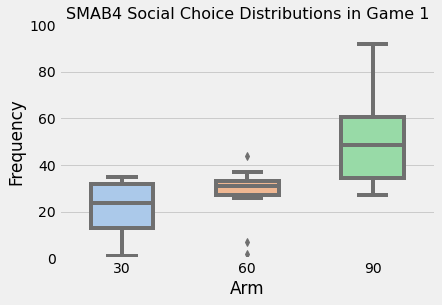

In [122]:
# In[ ]:


m_g1_counts_box = sns.boxplot( 
                 data = m_g1_counts, 
                 width=0.5,
                 palette="pastel")
m_g1_counts_box.axes.set_title("SMAB4 Social Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="m_g1_counts_box.jpg"
 
plt.ylim(0, 100)
m_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
m_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [123]:
# In[ ]:


m_g1_low = np.mean(m_g1_counts.iloc[:,0])
m_g1_med = np.mean(m_g1_counts.iloc[:,1])
m_g1_high = np.mean(m_g1_counts.iloc[:,2])


# In[ ]:


m_g1_low


# In[ ]:


m_g1_med


# In[ ]:


m_g1_high


# In[ ]:


m_g1_low_std = np.std(m_g1_counts.iloc[:,0])
m_g1_med_std = np.std(m_g1_counts.iloc[:,1])
m_g1_high_std = np.std(m_g1_counts.iloc[:,2])


# In[ ]:


m_g1_low_std


# In[ ]:


m_g1_med_std


# In[ ]:


m_g1_high_std


# # Multi combined choices in G2

# In[ ]:


m_g2_counts = pd.DataFrame([m05_p1_g2_count, m05_p2_g2_count, m06_p1_g2_count, m06_p2_g2_count, m08_p1_g2_count, m08_p2_g2_count, 
              m10_p1_g2_count, m10_p2_g2_count, m11_p1_g2_count, m11_p2_g2_count, m13_p1_g2_count, m13_p2_g2_count, 
              m14_p1_g2_count, m14_p2_g2_count],
                index = ['m05_p1_g2_count', 'm05_p2_g2_count', 'm06_p1_g2_count', 'm06_p2_g2_count',
                 'm08_p1_g2_count', 'm08_p2_g2_count', 'm10_p1_g2_count', 'm10_p2_g2_count', 'm11_p1_g2_count', 
                'm11_p2_g2_count', 'm13_p1_g2_count', 'm13_p2_g2_count', 'm14_p1_g2_count', 'm14_p2_g2_count'])


# In[ ]:


m_g2_counts = m_g2_counts.fillna(0) 


# In[ ]:


m_g2_counts


# In[ ]:


m_g2_counts.sum(axis=1)


# In[ ]:

m05_p1_g2_count    100.0
m05_p2_g2_count    100.0
m06_p1_g2_count    101.0
m06_p2_g2_count    100.0
m08_p1_g2_count    101.0
m08_p2_g2_count    100.0
m10_p1_g2_count    101.0
m10_p2_g2_count    100.0
m11_p1_g2_count    101.0
m11_p2_g2_count    100.0
m13_p1_g2_count    101.0
m13_p2_g2_count    100.0
m14_p1_g2_count    101.0
m14_p2_g2_count    100.0
dtype: float64

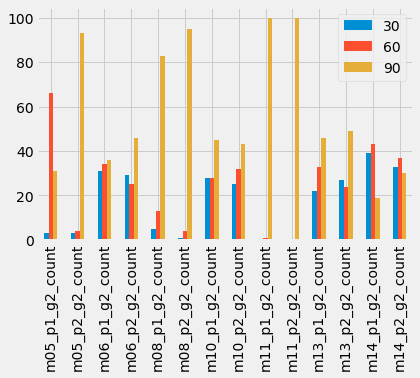

In [124]:
m_g2_counts_bar = m_g2_counts.plot.bar()

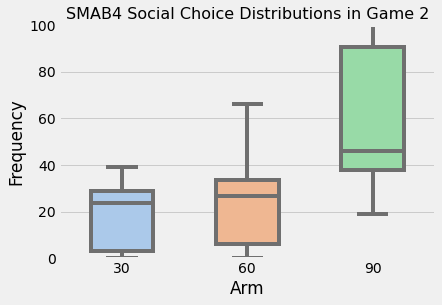

In [125]:
m_g2_counts_box = sns.boxplot( 
                 data = m_g2_counts, 
                 width=0.5,
                 palette="pastel")
m_g2_counts_box.axes.set_title("SMAB4 Social Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="m_g2_counts_box.jpg"
 
plt.ylim(0, 100)
m_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
m_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [126]:
# In[ ]:


m_g2_low = np.mean(m_g2_counts.iloc[:,0])
m_g2_med = np.mean(m_g2_counts.iloc[:,1])
m_g2_high = np.mean(m_g2_counts.iloc[:,2])


# In[ ]:


m_g2_low


# In[ ]:


m_g2_med


# In[ ]:


m_g2_high


# In[ ]:


m_g2_low_std = np.std(m_g2_counts.iloc[:,0])
m_g2_med_std = np.std(m_g2_counts.iloc[:,1])
m_g2_high_std = np.std(m_g2_counts.iloc[:,2])


# In[ ]:


m_g2_low_std


# In[ ]:


m_g2_med_std


# In[ ]:


m_g2_high_std


# # Multi combined arrays

# In[ ]:


#pip install researchpy


# In[ ]:


import researchpy as rp


# In[ ]:


m_90_1 = np.array(m_g1_counts.iloc[:,2])
m_90_2 = np.array(m_g2_counts.iloc[:,2])


# In[ ]:


m_90_1


# In[ ]:


m_90_2


# In[ ]:


m_60_1 = np.array(m_g1_counts.iloc[:,1])
m_60_2 = np.array(m_g2_counts.iloc[:,1])


# In[ ]:


m_60_1


# In[ ]:


m_60_2


# In[ ]:


m_30_1 = np.array(m_g1_counts.iloc[:,0])
m_30_2 = np.array(m_g2_counts.iloc[:,0])


# In[ ]:


m_30_1


# In[ ]:


m_30_2


# # Multi combined choice statistics

# In[ ]:


m_90_p = sp.stats.ttest_rel(m_90_1,m_90_2)
m_60_p = sp.stats.ttest_rel(m_60_1,m_60_2)
m_30_p = sp.stats.ttest_rel(m_30_1,m_30_2)


# In[ ]:


m_90_p


# In[ ]:


m_60_p


# In[ ]:


m_30_p


# In[ ]:


#maximizing and matching?

Ttest_relResult(statistic=2.14398812563711, pvalue=0.05151862753230061)

In [127]:
'''Here we combine scores from SMAB3 and SMAB4 in one dataframe'''

# # SOCIAL (total) scores G1


social_scores_1 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 
                                               'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 
                                               'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2','m05_p1', 'm05_p2','m06_p1', 
                                               'm06_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 
                                               'm14_p1', 'm14_p2'], 'social_score_1':
     [j01_p1_g1_score, j01_p2_g1_score, j02_p1_g1_score, j02_p2_g1_score, j03_p1_g1_score, j03_p2_g1_score,
      j04_p1_g1_score, j04_p2_g1_score, j05_p1_g1_score, j05_p2_g1_score, j06_p1_g1_score, j06_p2_g1_score,
      j07_p1_g1_score, j07_p2_g1_score, j08_p1_g1_score, j08_p2_g1_score, j10_p1_g1_score, j10_p2_g1_score, j11_p1_g1_score, j11_p2_g1_score, m05_p1_g1_score, m05_p2_g1_score, m06_p1_g1_score, m06_p2_g1_score, m08_p1_g1_score, m08_p2_g1_score,
      m10_p1_g1_score, m10_p2_g1_score, m11_p1_g1_score, m11_p2_g1_score, m13_p1_g1_score, m13_p2_g1_score,
      m14_p1_g1_score, m14_p2_g1_score]})
social_scores_1.set_index('participant', inplace=True, drop=True)
social_scores_1


# # SOCIAL (total) scores G2

# In[ ]:


social_scores_2 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1',
                        'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2', 
                           'm05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'social_score_2':
     [j01_p1_g2_score, j01_p2_g2_score, j02_p1_g2_score, j02_p2_g2_score, j03_p1_g2_score, j03_p2_g2_score,
      j04_p1_g2_score, j04_p2_g2_score, j05_p1_g2_score, j05_p2_g2_score, j06_p1_g2_score, j06_p2_g2_score,
      j07_p1_g2_score, j07_p2_g2_score, j08_p1_g2_score, j08_p2_g2_score, j10_p1_g2_score, j10_p2_g2_score, j11_p1_g2_score, j11_p2_g2_score, m05_p1_g2_score, m05_p2_g2_score, m06_p1_g2_score, m06_p2_g2_score, m08_p1_g2_score, m08_p2_g2_score,
      m10_p1_g2_score, m10_p2_g2_score, m11_p1_g2_score, m11_p2_g2_score, m13_p1_g2_score, m13_p2_g2_score, m14_p1_g2_score, m14_p2_g2_score]})
social_scores_2.set_index('participant', inplace=True, drop=True)
social_scores_2


# In[ ]:


social_scores = pd.merge(social_scores_1, social_scores_2, on = 'participant')
social_scores.columns=['Game 1','Game 2']
#jp1_scores.set_index('participant', inplace=True, drop=True)
social_scores


# In[ ]:


#export to excel
social_scores.to_excel("output14.xlsx")  


# In[ ]:


social_scores=social_scores.sum(axis=1)


# In[ ]:


social_scores.sort_values(inplace=True)


# In[ ]:


social_scores


# In[ ]:


social_scores_1_mean = social_scores_1.mean()


# In[ ]:


social_scores_1_mean


# In[ ]:


social_scores_1_std = social_scores_1.std()


# In[ ]:


social_scores_1_std


# In[ ]:


social_scores_2_mean = social_scores_2.mean()


# In[ ]:


social_scores_2_mean


# In[ ]:


social_scores_2_std = social_scores_2.std()


# In[ ]:


social_scores_2_std


# In[ ]:


social_scores_med = social_scores.median()
social_scores_med


# In[ ]:


social_scores_p = sp.stats.ttest_rel(social_scores_1,social_scores_2)


# In[ ]:


social_scores_p


# # Arm1

# In[ ]:

Ttest_relResult(statistic=array([-2.77790757]), pvalue=array([0.00895414]))

In [128]:
#combine joint hole count dataframes 
#make index just the participant code
#combine control_counts_2 and control_counts_1

#modify the index to be only participant
subjects_1 = m_g1_counts.index.to_numpy()
subjects_2 = m_g2_counts.index.to_numpy()

subjects_new1 = np.array([])
subjects_new2 = np.array([])

ii = 0
for i in subjects_1:
    subjects_new1 = np.append(subjects_new1,subjects_1[ii][0:6])
    ii = ii +1
    
iii = 0
for i in subjects_2:
    subjects_new2 = np.append(subjects_new2,subjects_2[iii][0:6])
    iii = iii +1

m_g1_counts.index = subjects_new1
m_g2_counts.index = subjects_new2

m_counts = m_g1_counts.merge(m_g2_counts,right_index=True,left_index=True)

In [129]:
m_counts

,30_x,60_x,90_x,30_y,60_y,90_y
m05_p1,11,26,63,3.0,66.0,31.0
m05_p2,13,31,56,3.0,4.0,93.0
m06_p1,35,35,31,31.0,34.0,36.0
m06_p2,31,31,38,29.0,25.0,46.0
m08_p1,13,27,61,5.0,13.0,83.0
m08_p2,9,32,59,1.0,4.0,95.0
m10_p1,21,30,50,28.0,28.0,45.0
m10_p2,29,44,27,25.0,32.0,43.0
m11_p1,20,2,79,0.0,1.0,100.0
m11_p2,1,7,92,0.0,0.0,100.0


# Test for differences between SMAB3 and SMAB4 in multi-player data

In [130]:
#combine control_score_2 and control_score_1
social_scores = social_scores_1.merge(social_scores_2,right_index=True,left_index=True)


#convert from wide-format to long-format
social_scores = pd.melt(social_scores,ignore_index=False)

In [131]:
subjects = social_scores.index.to_numpy()

In [132]:
subjects

array(['j01_p1', 'j01_p2', 'j02_p1', 'j02_p2', 'j03_p1', 'j03_p2',
       'j04_p1', 'j04_p2', 'j05_p1', 'j05_p2', 'j06_p1', 'j06_p2',
       'j07_p1', 'j07_p2', 'j08_p1', 'j08_p2', 'j10_p1', 'j10_p2',
       'j11_p1', 'j11_p2', 'm05_p1', 'm05_p2', 'm06_p1', 'm06_p2',
       'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2',
       'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2', 'j01_p1', 'j01_p2',
       'j02_p1', 'j02_p2', 'j03_p1', 'j03_p2', 'j04_p1', 'j04_p2',
       'j05_p1', 'j05_p2', 'j06_p1', 'j06_p2', 'j07_p1', 'j07_p2',
       'j08_p1', 'j08_p2', 'j10_p1', 'j10_p2', 'j11_p1', 'j11_p2',
       'm05_p1', 'm05_p2', 'm06_p1', 'm06_p2', 'm08_p1', 'm08_p2',
       'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2',
       'm14_p1', 'm14_p2'], dtype=object)

In [133]:
experiment = np.array([])

for i in subjects:
    if [i][0][0] == 'j':
        experiment = np.append(experiment,3)
    elif [i][0][0] == 'm':
        experiment = np.append(experiment,4)
        
social_scores['experiment'] = experiment

In [134]:
social_scores

,variable,value,experiment
participant,,,
j01_p1,social_score_1,57,3.0
j01_p2,social_score_1,61,3.0
j02_p1,social_score_1,54,3.0
j02_p2,social_score_1,68,3.0
j03_p1,social_score_1,69,3.0
...,...,...,...
m11_p2,social_score_2,87,4.0
m13_p1,social_score_2,68,4.0
m13_p2,social_score_2,72,4.0


In [135]:
'''Here we conduct a 2 x 2 mixed measures ANOVA to compare the scores in games 1 and 2'''
pg.mixed_anova(data=social_scores, dv='value', between='experiment', within='variable', subject='participant')

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,experiment,1.482353,1,32,1.482353,0.009787,0.921811,0.000306,NaN
1,variable,400.367647,1,32,400.367647,8.177511,0.007407,0.203535,1.0
2,Interaction,145.425210,1,32,145.425210,2.970311,0.094457,0.084938,NaN


In [136]:
import patsy

In [137]:
'''Here we conduct a linear regression to compare the scores in games 1 and 2'''
outcome_1,predictors_1 = patsy.dmatrices("value ~ variable + experiment", social_scores)
mod_1 = sm.OLS(outcome_1,predictors_1)
res_1 = mod_1.fit()

print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.991
Date:                Thu, 03 Sep 2020   Prob (F-statistic):              0.145
Time:                        14:54:16   Log-Likelihood:                -251.84
No. Observations:                  68   AIC:                             509.7
Df Residuals:                      65   BIC:                             516.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [138]:
#combine m_counts and j_counts
joint_counts = m_counts.append(j_counts)

In [139]:
joint_counts = joint_counts.melt(ignore_index=False)

In [140]:
joint_counts

,variable,value
m05_p1,30_x,11.0
m05_p2,30_x,13.0
m06_p1,30_x,35.0
m06_p2,30_x,31.0
m08_p1,30_x,13.0
...,...,...
j08_p2,90_y,65.0
j10_p1,90_y,46.0
j10_p2,90_y,77.0
j11_p1,90_y,79.0


In [141]:
#clean up joint_counts
#modify 'variable' to be only '30','60', or '90' and add a column 'game' specifying the game #
variable = joint_counts['variable'].to_numpy()

choice = np.array([])
game = np.array([])

ii = 0
for i in variable:
    length = len(variable[ii])
    if variable[ii][length - 1] == 'x':
        game = np.append(game,'1')
    elif variable[ii][len(variable[ii]) - 1] == 'y':
        game = np.append(game,'2')
    choice = np.append(choice,variable[ii][0:2])
    ii = ii +1
    
joint_counts['variable'] = choice
joint_counts['game'] = game

In [142]:
joint_counts

,variable,value,game
m05_p1,30,11.0,1
m05_p2,30,13.0,1
m06_p1,30,35.0,1
m06_p2,30,31.0,1
m08_p1,30,13.0,1
...,...,...,...
j08_p2,90,65.0,2
j10_p1,90,46.0,2
j10_p2,90,77.0,2
j11_p1,90,79.0,2


# Test for differences in SMAB3 and SMAB4 including single and multiplayer

In [143]:
'''Here we combine all of the scores (all games, confed and multiplayer, SMAB 3 and 4)'''
scores = control_scores.append(social_scores)

In [144]:
scores

,variable,value,experiment
participant,,,
s01,control_score_1,60,3.0
s03,control_score_1,63,3.0
s05,control_score_1,77,3.0
s06,control_score_1,82,3.0
s07,control_score_1,63,3.0
...,...,...,...
m11_p2,social_score_2,87,4.0
m13_p1,social_score_2,68,4.0
m13_p2,social_score_2,72,4.0


In [145]:
#combnine all SMAB3 scores
j_scores = j_scores.rename(columns={"score_1": "Game 1", "score_2": "Game 2"})
smab3_scores = s_scores.append(j_scores)

In [146]:
smab3_scores

,Game 1,Game 2
participant,,
s01,60,74
s03,63,71
s05,77,88
s06,82,87
s07,63,68
s08,90,80
s09,65,70
s11,60,61
s12,83,86


In [147]:
smab3_scores_1_mean = smab3_scores['Game 1'].mean()
smab3_scores_1_std = smab3_scores['Game 1'].std()
smab3_scores_2_mean = smab3_scores['Game 2'].mean()
smab3_scores_2_std = smab3_scores['Game 2'].std()

In [148]:
smab3_scores_1_mean, smab3_scores_1_std, smab3_scores_2_mean, smab3_scores_2_std

(68.44117647058823, 10.141995429955967, 74.38235294117646, 9.112145427718996)

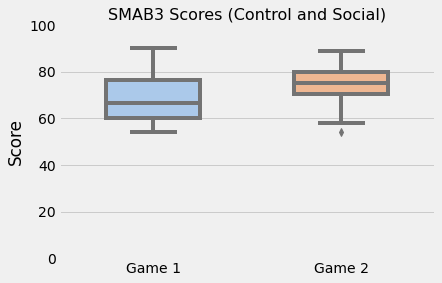

In [149]:
#working on now
smab3_scores_box = sns.boxplot( 
                 data=smab3_scores,
                 width=0.5,
                 palette="pastel")
smab3_scores_box.axes.set_title("SMAB3 Scores (Control and Social)",
                    fontsize=16)

plot_file_name="smab3_score_box.jpg"
 
plt.ylim(0, 100)
smab3_scores_box.axes.set(ylabel='Score')

# save as jpeg
smab3_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [150]:
#combnine all SMAB4 scores
c_scores = c_scores.rename(columns={"confederate_score_1": "Game 1", "confederate_score_2": "Game 2"})
m_scores = m_scores.rename(columns={"score_1": "Game 1", "score_2": "Game 2"})
smab4_scores = c_scores.append(m_scores)

In [151]:
smab4_scores

,Game 1,Game 2
participant,,
c02,74,85
c03,79,73
c05,61,72
c06,59,53
c09,61,44
c10,81,79
c11,69,82
c12,59,53
c13,64,68


In [152]:
c09

,game number,trial,player,arm,probability,time,P1 score,P2 score
0,1,1,1,3,60,4.451879,1,0
1,1,1,2,1,90,19.904118,1,0
2,1,2,1,3,60,3.973622,2,0
3,1,2,2,1,90,3.697111,2,1
4,1,3,1,1,90,4.381772,3,1
...,...,...,...,...,...,...,...,...
395,2,98,2,2,60,2.742179,43,58
396,2,99,1,1,60,3.965856,43,58
397,2,99,2,2,60,3.420303,43,59
398,2,100,1,2,90,3.423214,44,59


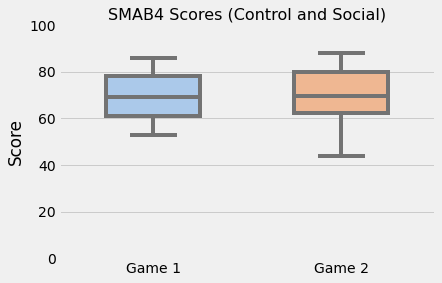

In [153]:
#working on now
smab4_scores_box = sns.boxplot( 
                 data=smab4_scores,
                 width=0.5,
                 palette="pastel")
smab4_scores_box.axes.set_title("SMAB4 Scores (Control and Social)",
                    fontsize=16)

plot_file_name="smab4_score_box.jpg"
 
plt.ylim(0, 100)
smab4_scores_box.axes.set(ylabel='Score')

# save as jpeg
smab4_scores_box.figure.savefig(plot_file_name,
                    format='jpeg')

In [154]:
smab4_scores_1_mean = smab4_scores['Game 1'].mean()
smab4_scores_1_std = smab4_scores['Game 1'].std()
smab4_scores_2_mean = smab4_scores['Game 2'].mean()
smab4_scores_2_std = smab4_scores['Game 2'].std()

In [155]:
smab4_scores_1_mean, smab4_scores_1_std, smab4_scores_2_mean, smab4_scores_2_std

(69.61538461538461, 10.020287113958057, 69.92307692307692, 11.872398500465108)

In [156]:
#add another column to scores indicating whether it's the single or multiplayer

subjects = scores.index.to_numpy()

condition = np.array([])

for i in subjects:
    if [i][0][0] == 's' or [i][0][0] == 'c':
        condition = np.append(condition,'control')
    elif [i][0][0] == 'm' or [i][0][0] == 'j':
        condition = np.append(condition,'social')

scores['condition'] = condition

In [157]:
#change 'variable' column to reflect game number

var = scores['variable'].to_numpy()

game = np.array([])

ii = 0

for i in var:
    length = len(var[ii])
    game = np.append(game,var[ii][length - 1])
    ii = ii + 1
    
scores['variable'] = game

In [158]:
print(scores)

            variable  value  experiment condition
participant                                      
s01                1     60         3.0   control
s03                1     63         3.0   control
s05                1     77         3.0   control
s06                1     82         3.0   control
s07                1     63         3.0   control
...              ...    ...         ...       ...
m11_p2             2     87         4.0    social
m13_p1             2     68         4.0    social
m13_p2             2     72         4.0    social
m14_p1             2     54         4.0    social
m14_p2             2     56         4.0    social

[120 rows x 4 columns]


In [159]:
scores = scores.reset_index()

In [160]:
scores

,participant,variable,value,experiment,condition
0,s01,1,60,3.0,control
1,s03,1,63,3.0,control
2,s05,1,77,3.0,control
3,s06,1,82,3.0,control
4,s07,1,63,3.0,control
...,...,...,...,...,...
115,m11_p2,2,87,4.0,social
116,m13_p1,2,68,4.0,social
117,m13_p2,2,72,4.0,social
118,m14_p1,2,54,4.0,social


In [161]:
scores.to_csv('scores.csv')

In [162]:
#NEED
#pg.mixed_anova(data=scores, dv='value', between=['experiment','condition'], within='variable', subject='participant')

In [163]:
#using statsmodels instead of pingouin
#sm.AnovaRM(scores, 'value', 'participant', within=within, between='experiment', aggregate_func=None)

In [164]:
'''Here we conduct a linear regression to compare the scores in games 1 and 2'''
outcome_1,predictors_1 = patsy.dmatrices("value ~ variable + experiment", scores)
mod_1 = sm.OLS(outcome_1,predictors_1)
res_1 = mod_1.fit()

print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.108
Date:                Thu, 03 Sep 2020   Prob (F-statistic):              0.126
Time:                        14:54:16   Log-Likelihood:                -448.56
No. Observations:                 120   AIC:                             903.1
Df Residuals:                     117   BIC:                             911.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        74.5894      6.646     11.223

In [165]:
'''Here we conduct a linear regression to compare the scores in games 1 and 2; condition is added!'''
outcome_1,predictors_1 = patsy.dmatrices("value ~ variable + experiment + condition", scores)
mod_1 = sm.OLS(outcome_1,predictors_1)
res_1 = mod_1.fit()

print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     1.407
Date:                Thu, 03 Sep 2020   Prob (F-statistic):              0.244
Time:                        14:54:16   Log-Likelihood:                -448.54
No. Observations:                 120   AIC:                             905.1
Df Residuals:                     116   BIC:                             916.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              74.8656    

In [166]:
scores = control_scores.append(social_scores)

# Test for differences looking at all the value counts data with the holes denoted by probability

In [167]:
#combine joint_counts and control_counts
counts = joint_counts.append(control_counts)

In [168]:
counts

,variable,value,game
m05_p1,30,11.0,1
m05_p2,30,13.0,1
m06_p1,30,35.0,1
m06_p2,30,31.0,1
m08_p1,30,13.0,1
...,...,...,...
c12,90,18.0,2
c13,90,47.0,2
c14,90,52.0,2
c16,90,70.0,2


In [169]:
#add another column to counts indicating whether it's the single or multiplayer

subjects = counts.index.to_numpy()

condition = np.array([])

for i in subjects:
    if [i][0][0] == 's' or [i][0][0] == 'c':
        condition = np.append(condition,'control')
    elif [i][0][0] == 'm' or [i][0][0] == 'j':
        condition = np.append(condition,'social')

counts['condition'] = condition

In [170]:
#add another column to counts indiciating whether it's SMAB 3 or 4

subjects = counts.index.to_numpy()


experiment = np.array([])

for i in subjects:
    if [i][0][0] == 's' or [i][0][0] == 'j':
        experiment = np.append(experiment,3)
    elif [i][0][0] == 'c' or [i][0][0] == 'm':
        experiment = np.append(experiment,4)
        
counts['experiment'] = experiment

In [171]:
#break up counts dataframe into 30,60,90
grouped = counts.groupby(counts.variable)
counts_30 = grouped.get_group("30")
counts_60 = grouped.get_group("60")
counts_90 = grouped.get_group("90")

In [172]:
counts_60

,variable,value,game,condition,experiment
m05_p1,60,26.0,1,social,4.0
m05_p2,60,31.0,1,social,4.0
m06_p1,60,35.0,1,social,4.0
m06_p2,60,31.0,1,social,4.0
m08_p1,60,27.0,1,social,4.0
...,...,...,...,...,...
c12,60,45.0,2,control,4.0
c13,60,32.0,2,control,4.0
c14,60,30.0,2,control,4.0
c16,60,24.0,2,control,4.0


In [173]:
#run 2x2 between measures ANOVA for the 90 hole
pg.anova(data=counts_90, dv='value', between=['experiment','condition'])

,Source,SS,DF,MS,F,p-unc,np2
0,experiment,325.862655,1.0,325.862655,0.651126,0.421362,0.005582
1,condition,53.489352,1.0,53.489352,0.106880,0.744313,0.000921
2,experiment * condition,383.003705,1.0,383.003705,0.765304,0.383482,0.006554
3,Residual,58053.344048,116.0,500.459862,NaN,NaN,NaN


In [174]:
#run 2x2 between measures ANOVA for the 60 hole
pg.anova(data=counts_60, dv='value', between=['experiment','condition'])

,Source,SS,DF,MS,F,p-unc,np2
0,experiment,31.089184,1.0,31.089184,0.173997,0.677361,0.001511
1,condition,13.024372,1.0,13.024372,0.072894,0.787653,0.000633
2,experiment * condition,66.770122,1.0,66.770122,0.373694,0.542204,0.003239
3,Residual,20547.753439,115.0,178.676117,NaN,NaN,NaN


In [175]:
import statsmodels

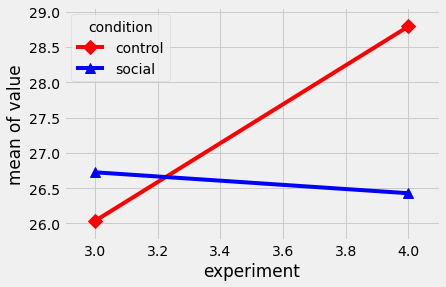

In [176]:
#plot interaction
int_60 = sm.graphics.interaction_plot(counts_60['experiment'], counts_60['condition'], counts_60['value'],
           colors=['red','blue'], markers=['D','^'], ms=10)

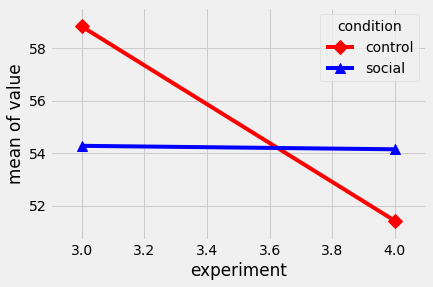

In [177]:
int_90 = sm.graphics.interaction_plot(counts_90['experiment'], counts_90['condition'], counts_90['value'],
           colors=['red','blue'], markers=['D','^'], ms=10)

In [178]:
m05_p1_g1_arm = m05_p1_g1['arm'].value_counts(sort=False)
m05_p1_g2_arm = m05_p1_g2['arm'].value_counts(sort=False)
m05_p2_g1_arm = m05_p2_g1['arm'].value_counts(sort=False)
m05_p2_g2_arm = m05_p2_g2['arm'].value_counts(sort=False)
m06_p1_g1_arm = m06_p1_g1['arm'].value_counts(sort=False)
m06_p1_g2_arm = m06_p1_g2['arm'].value_counts(sort=False)
m06_p2_g1_arm = m06_p2_g1['arm'].value_counts(sort=False)
m06_p2_g2_arm = m06_p2_g2['arm'].value_counts(sort=False)
m08_p1_g1_arm = m08_p1_g1['arm'].value_counts(sort=False)
m08_p1_g2_arm = m08_p1_g2['arm'].value_counts(sort=False)
m08_p2_g1_arm = m08_p2_g1['arm'].value_counts(sort=False)
m08_p2_g2_arm = m08_p2_g2['arm'].value_counts(sort=False)
m10_p1_g1_arm = m10_p1_g1['arm'].value_counts(sort=False)
m10_p1_g2_arm = m10_p1_g2['arm'].value_counts(sort=False)
m10_p2_g1_arm = m10_p2_g1['arm'].value_counts(sort=False)
m10_p2_g2_arm = m10_p2_g2['arm'].value_counts(sort=False)
m11_p1_g1_arm = m11_p1_g1['arm'].value_counts(sort=False)
m11_p1_g2_arm = m11_p1_g2['arm'].value_counts(sort=False)
m11_p2_g1_arm = m11_p2_g1['arm'].value_counts(sort=False)
m11_p2_g2_arm = m11_p2_g2['arm'].value_counts(sort=False)
m13_p1_g1_arm = m13_p1_g1['arm'].value_counts(sort=False)
m13_p1_g2_arm = m13_p1_g2['arm'].value_counts(sort=False)
m13_p2_g1_arm = m13_p2_g1['arm'].value_counts(sort=False)
m13_p2_g2_arm = m13_p2_g2['arm'].value_counts(sort=False)
m14_p1_g1_arm = m14_p1_g1['arm'].value_counts(sort=False)
m14_p1_g2_arm = m14_p1_g2['arm'].value_counts(sort=False)
m14_p2_g1_arm = m14_p2_g1['arm'].value_counts(sort=False)
m14_p2_g2_arm = m14_p2_g2['arm'].value_counts(sort=False)
j01_p1_g1_arm = j01_p1_g1['arm'].value_counts(sort=False)
j01_p1_g2_arm = j01_p1_g2['arm'].value_counts(sort=False)
j01_p2_g1_arm = j01_p2_g1['arm'].value_counts(sort=False)
j01_p2_g2_arm = j01_p2_g2['arm'].value_counts(sort=False)
j02_p1_g1_arm = j02_p1_g1['arm'].value_counts(sort=False)
j02_p1_g2_arm = j02_p1_g2['arm'].value_counts(sort=False)
j02_p2_g1_arm = j02_p2_g1['arm'].value_counts(sort=False)
j02_p2_g2_arm = j02_p2_g2['arm'].value_counts(sort=False)
j03_p1_g1_arm = j03_p1_g1['arm'].value_counts(sort=False)
j03_p1_g2_arm = j03_p1_g2['arm'].value_counts(sort=False)
j03_p2_g1_arm = j03_p2_g1['arm'].value_counts(sort=False)
j03_p2_g2_arm = j03_p2_g2['arm'].value_counts(sort=False)
j04_p1_g1_arm = j04_p1_g1['arm'].value_counts(sort=False)
j04_p1_g2_arm = j04_p1_g2['arm'].value_counts(sort=False)
j04_p2_g1_arm = j04_p2_g1['arm'].value_counts(sort=False)
j04_p2_g2_arm = j04_p2_g2['arm'].value_counts(sort=False)
j05_p1_g1_arm = j05_p1_g1['arm'].value_counts(sort=False)
j05_p1_g2_arm = j05_p1_g2['arm'].value_counts(sort=False)
j05_p2_g1_arm = j05_p2_g1['arm'].value_counts(sort=False)
j05_p2_g2_arm = j05_p2_g2['arm'].value_counts(sort=False)
j06_p1_g1_arm = j06_p1_g1['arm'].value_counts(sort=False)
j06_p1_g2_arm = j06_p1_g2['arm'].value_counts(sort=False)
j06_p2_g1_arm = j06_p2_g1['arm'].value_counts(sort=False)
j06_p2_g2_arm = j06_p2_g2['arm'].value_counts(sort=False)
j07_p1_g1_arm = j07_p1_g1['arm'].value_counts(sort=False)
j07_p1_g2_arm = j07_p1_g2['arm'].value_counts(sort=False)
j07_p2_g1_arm = j07_p2_g1['arm'].value_counts(sort=False)
j07_p2_g2_arm = j07_p2_g2['arm'].value_counts(sort=False)
j08_p1_g1_arm = j08_p1_g1['arm'].value_counts(sort=False)
j08_p1_g2_arm = j08_p1_g2['arm'].value_counts(sort=False)
j08_p2_g1_arm = j08_p2_g1['arm'].value_counts(sort=False)
j08_p2_g2_arm = j08_p2_g2['arm'].value_counts(sort=False)
j10_p1_g1_arm = j10_p1_g1['arm'].value_counts(sort=False)
j10_p1_g2_arm = j10_p1_g2['arm'].value_counts(sort=False)
j10_p2_g1_arm = j10_p2_g1['arm'].value_counts(sort=False)
j10_p2_g2_arm = j10_p2_g2['arm'].value_counts(sort=False)
j11_p1_g1_arm = j11_p1_g1['arm'].value_counts(sort=False)
j11_p1_g2_arm = j11_p1_g2['arm'].value_counts(sort=False)
j11_p2_g1_arm = j11_p2_g1['arm'].value_counts(sort=False)
j11_p2_g2_arm = j11_p2_g2['arm'].value_counts(sort=False)

In [179]:
# In[ ]:


social_arms_g1 = pd.DataFrame([j01_p1_g1_arm, j01_p2_g1_arm, j02_p1_g1_arm, j02_p2_g1_arm, j03_p1_g1_arm, 
              j03_p2_g1_arm, j04_p1_g1_arm, j04_p2_g1_arm, j05_p1_g1_arm, j05_p2_g1_arm, j06_p1_g1_arm, 
              j06_p2_g1_arm, j07_p1_g1_arm, j07_p2_g1_arm, j08_p1_g1_arm, j08_p2_g1_arm, 
              j10_p1_g1_arm, j10_p2_g1_arm, j11_p1_g1_arm, j11_p2_g1_arm, m05_p1_g1_arm, m05_p2_g1_arm, m06_p1_g1_arm, m06_p2_g1_arm, m08_p1_g1_arm, m08_p2_g1_arm, 
              m10_p1_g1_arm, m10_p2_g1_arm, m11_p1_g1_arm, m11_p2_g1_arm, m13_p1_g1_arm, m13_p2_g1_arm, 
              m14_p1_g1_arm, m14_p2_g1_arm],
                index = ['j01_p1_g1_arm', 'j01_p2_g1_arm', 'j02_p1_g1_arm', 'j02_p2_g1_arm', 
                 'j03_p1_g1_arm', 'j03_p2_g1_arm', 'j04_p1_g1_arm', 'j04_p2_g1_arm', 'j05_p1_g1_arm', 
                  'j05_p2_g1_arm', 'j06_p1_g1_arm', 'j06_p2_g1_arm', 'j07_p1_g1_arm', 
                    'j07_p2_g1_arm', 'j08_p1_g1_arm', 'j08_p2_g1_arm', 'j10_p1_g1_arm', 'j10_p2_g1_arm', 
                    'j11_p1_g1_arm', 'j11_p2_g1_arm', 'm05_p1_g1_arm', 'm05_p2_g1_arm', 'm06_p1_g1_arm', 'm06_p2_g1_arm',
                 'm08_p1_g1_arm', 'm08_p2_g1_arm', 'm10_p1_g1_arm', 'm10_p2_g1_arm', 'm11_p1_g1_arm', 
                'm11_p2_g1_arm', 'm13_p1_g1_arm', 'm13_p2_g1_arm', 'm14_p1_g1_arm', 'm14_p2_g1_arm'])


# In[ ]:


#How to prevent NaN: df = df.fillna(0)
social_arms_g1 = social_arms_g1.fillna(0)

#print
social_arms_g1


# In[ ]:


#export to excel
social_arms_g1.to_excel("output10.xlsx")  


# In[ ]:


social_arms_g2 = pd.DataFrame([j01_p1_g2_arm, j01_p2_g2_arm, j02_p1_g2_arm, j02_p2_g2_arm, j03_p1_g2_arm, 
              j03_p2_g2_arm, j04_p1_g2_arm, j04_p2_g2_arm, j05_p1_g2_arm, j05_p2_g2_arm, j06_p1_g2_arm, 
              j06_p2_g2_arm, j07_p1_g2_arm, j07_p2_g2_arm, j08_p1_g2_arm, j08_p2_g2_arm, 
              j10_p1_g2_arm, j10_p2_g2_arm, j11_p1_g2_arm, j11_p2_g2_arm, m05_p1_g2_arm, m05_p2_g2_arm, m06_p1_g2_arm, m06_p2_g2_arm, m08_p1_g2_arm, m08_p2_g2_arm, 
              m10_p1_g2_arm, m10_p2_g2_arm, m11_p1_g2_arm, m11_p2_g2_arm, m13_p1_g2_arm, m13_p2_g2_arm, 
              m14_p1_g2_arm, m14_p2_g2_arm],
                index = ['j01_p1_g2_arm', 'j01_p2_g2_arm', 'j02_p1_g2_arm', 'j02_p2_g2_arm', 
                 'j03_p1_g2_arm', 'j03_p2_g2_arm', 'j04_p1_g2_arm', 'j04_p2_g2_arm', 'j05_p1_g2_arm', 
                  'j05_p2_g2_arm', 'j06_p1_g2_arm', 'j06_p2_g2_arm', 'j07_p1_g2_arm', 
                    'j07_p2_g2_arm', 'j08_p1_g2_arm', 'j08_p2_g2_arm', 'j10_p1_g2_arm', 'j10_p2_g2_arm', 
                    'j11_p1_g2_arm', 'j11_p2_g2_arm', 'm05_p1_g2_arm', 'm05_p2_g2_arm', 'm06_p1_g2_arm', 'm06_p2_g2_arm',
                 'm08_p1_g2_arm', 'm08_p2_g2_arm', 'm10_p1_g2_arm', 'm10_p2_g2_arm', 'm11_p1_g2_arm', 
                'm11_p2_g2_arm', 'm13_p1_g2_arm', 'm13_p2_g2_arm', 'm14_p1_g2_arm', 'm14_p2_g2_arm'])


# In[ ]:


#How to prevent NaN: df = df.fillna(0)
social_arms_g2 = social_arms_g2.fillna(0)

#print
social_arms_g2


# In[ ]:


social_arms_g2.to_excel("output11.xlsx")  

In [180]:
social_arms_g1

,1,2,3
j01_p1_g1_arm,26.0,38.0,36.0
j01_p2_g1_arm,33.0,30.0,37.0
j02_p1_g1_arm,32.0,32.0,36.0
j02_p2_g1_arm,39.0,25.0,36.0
j03_p1_g1_arm,29.0,49.0,22.0
j03_p2_g1_arm,23.0,29.0,48.0
j04_p1_g1_arm,35.0,26.0,39.0
j04_p2_g1_arm,34.0,44.0,22.0
j05_p1_g1_arm,5.0,79.0,16.0
j05_p2_g1_arm,58.0,14.0,28.0


In [181]:
# # Total social counts (Multi & Joint)

# In[ ]:


social_counts_g1 = pd.DataFrame([j01_p1_g1_count, j01_p2_g1_count, j02_p1_g1_count, j02_p2_g1_count, j03_p1_g1_count, 
              j03_p2_g1_count, j04_p1_g1_count, j04_p2_g1_count, j05_p1_g1_count, j05_p2_g1_count, j06_p1_g1_count, 
              j06_p2_g1_count, j07_p1_g1_count, j07_p2_g1_count, j08_p1_g1_count, j08_p2_g1_count, 
              j10_p1_g1_count, j10_p2_g1_count, j11_p1_g1_count, j11_p2_g1_count, m05_p1_g1_count, m05_p2_g1_count, m06_p1_g1_count, m06_p2_g1_count, m08_p1_g1_count, m08_p2_g1_count, 
              m10_p1_g1_count, m10_p2_g1_count, m11_p1_g1_count, m11_p2_g1_count, m13_p1_g1_count, m13_p2_g1_count, 
              m14_p1_g1_count, m14_p2_g1_count],
                index = ['j01_p1_g1_count', 'j01_p2_g1_count', 'j02_p1_g1_count', 'j02_p2_g1_count', 
                 'j03_p1_g1_count', 'j03_p2_g1_count', 'j04_p1_g1_count', 'j04_p2_g1_count', 'j05_p1_g1_count', 
                  'j05_p2_g1_count', 'j06_p1_g1_count', 'j06_p2_g1_count', 'j07_p1_g1_count', 
                    'j07_p2_g1_count', 'j08_p1_g1_count', 'j08_p2_g1_count', 'j10_p1_g1_count', 'j10_p2_g1_count', 
                    'j11_p1_g1_count', 'j11_p2_g1_count', 'm05_p1_g1_count', 'm05_p2_g1_count', 'm06_p1_g1_count', 'm06_p2_g1_count',
                 'm08_p1_g1_count', 'm08_p2_g1_count', 'm10_p1_g1_count', 'm10_p2_g1_count', 'm11_p1_g1_count', 
                'm11_p2_g1_count', 'm13_p1_g1_count', 'm13_p2_g1_count', 'm14_p1_g1_count', 'm14_p2_g1_count'])


# In[ ]:


#How to prevent NaN: df = df.fillna(0)
social_counts_g1=social_counts_g1.fillna(0)


# In[ ]:


social_counts_g1


# In[ ]:


#export to excel
social_counts_g1.to_excel("output3.xlsx")  


# In[ ]:


social_counts_g1.sum(axis = 0, skipna = True)


# In[ ]:


social_counts_g1.mean(axis = 0)


# In[ ]:


social_counts_g1.sum(axis=1)


# In[ ]:


social_counts_g2 = pd.DataFrame([j01_p1_g2_count, j01_p2_g2_count, j02_p1_g2_count, j02_p2_g2_count, j03_p1_g2_count, 
              j03_p2_g2_count, j04_p1_g2_count, j04_p2_g2_count, j05_p1_g2_count, j05_p2_g2_count, j06_p1_g2_count, 
              j06_p2_g2_count, j07_p1_g2_count, j07_p2_g2_count, j08_p1_g2_count, j08_p2_g2_count, 
              j10_p1_g2_count, j10_p2_g2_count, j11_p1_g2_count, j11_p2_g2_count, m05_p1_g2_count, m05_p2_g2_count, m06_p1_g2_count, m06_p2_g2_count, m08_p1_g2_count, m08_p2_g2_count, 
              m10_p1_g2_count, m10_p2_g2_count, m11_p1_g2_count, m11_p2_g2_count, m13_p1_g2_count, m13_p2_g2_count, 
              m14_p1_g2_count, m14_p2_g2_count],
                index = ['j01_p1_g2_count', 'j01_p2_g2_count', 'j02_p1_g2_count', 'j02_p2_g2_count', 
                 'j03_p1_g2_count', 'j03_p2_g2_count', 'j04_p1_g2_count', 'j04_p2_g2_count', 'j05_p1_g2_count', 
                  'j05_p2_g2_count', 'j06_p1_g2_count', 'j06_p2_g2_count', 'j07_p1_g2_count', 
                    'j07_p2_g2_count', 'j08_p1_g2_count', 'j08_p2_g2_count', 'j10_p1_g2_count', 'j10_p2_g2_count', 
                    'j11_p1_g2_count', 'j11_p2_g2_count', 'm05_p1_g2_count', 'm05_p2_g2_count', 'm06_p1_g2_count', 'm06_p2_g2_count',
                 'm08_p1_g2_count', 'm08_p2_g2_count', 'm10_p1_g2_count', 'm10_p2_g2_count', 'm11_p1_g2_count', 
                'm11_p2_g2_count', 'm13_p1_g2_count', 'm13_p2_g2_count', 'm14_p1_g2_count', 'm14_p2_g2_count'])


# In[ ]:


#How to prevent NaN: df = df.fillna(0)
social_counts_g2=social_counts_g2.fillna(0)
social_counts_g2


# In[ ]:


#export to excel
social_counts_g2.to_excel("output4.xlsx")  


# In[ ]:


social_counts_g2.sum(axis=1)

j01_p1_g2_count    100.0
j01_p2_g2_count    100.0
j02_p1_g2_count    100.0
j02_p2_g2_count    100.0
j03_p1_g2_count    100.0
j03_p2_g2_count    100.0
j04_p1_g2_count    100.0
j04_p2_g2_count    100.0
j05_p1_g2_count    100.0
j05_p2_g2_count    100.0
j06_p1_g2_count    100.0
j06_p2_g2_count    100.0
j07_p1_g2_count    100.0
j07_p2_g2_count    100.0
j08_p1_g2_count    100.0
j08_p2_g2_count    100.0
j10_p1_g2_count    101.0
j10_p2_g2_count    100.0
j11_p1_g2_count    101.0
j11_p2_g2_count    100.0
m05_p1_g2_count    100.0
m05_p2_g2_count    100.0
m06_p1_g2_count    101.0
m06_p2_g2_count    100.0
m08_p1_g2_count    101.0
m08_p2_g2_count    100.0
m10_p1_g2_count    101.0
m10_p2_g2_count    100.0
m11_p1_g2_count    101.0
m11_p2_g2_count    100.0
m13_p1_g2_count    101.0
m13_p2_g2_count    100.0
m14_p1_g2_count    101.0
m14_p2_g2_count    100.0
dtype: float64

In [182]:
social_counts_g1

,30,60,90
j01_p1_g1_count,38.0,36.0,26.0
j01_p2_g1_count,33.0,37.0,30.0
j02_p1_g1_count,36.0,32.0,32.0
j02_p2_g1_count,25.0,39.0,36.0
j03_p1_g1_count,22.0,29.0,49.0
j03_p2_g1_count,29.0,23.0,48.0
j04_p1_g1_count,26.0,39.0,35.0
j04_p2_g1_count,34.0,22.0,44.0
j05_p1_g1_count,5.0,16.0,79.0
j05_p2_g1_count,14.0,28.0,58.0


In [183]:
#'''Here we combine all of the hole counts identifying them by probability (all games, confed and multiplayer, SMAB 3 and 4)'''
scores = control_scores.append(social_scores)

In [184]:
# # Maximizing/Matching SOCIAL

# In[ ]:


from scipy import stats


# In[ ]:


#Optional: Idealized probability distributions to use for comparison. These assume a social strategy in which the probability
#distributions of both partners in a joint session are averaged (all holes reward at a 60% rate)

#social_max = [0, 0, 100]
#social_match = [30/180 * 100,60/180 * 100, 90/180 * 100]


# In[ ]:


#Calls jsd with the social distributions.
#def call_jsd_social(counts):
   # maxi = jsd(counts,social_max)
   # matchi = jsd(counts,social_match)
    #return maxi,matchi


# In[ ]:


j01_p1_g1_max,j01_p1_g1_match,j01_p1_g1_rand,j01_p1_g1_soc = call_jsd(j01_p1_g1_count)
j01_p1_g2_max,j01_p1_g2_match,j01_p1_g2_rand,j01_p1_g2_soc = call_jsd(j01_p1_g2_count)
j01_p2_g1_max,j01_p2_g1_match,j01_p2_g1_rand,j01_p2_g1_soc = call_jsd(j01_p2_g1_count)
j01_p2_g2_max,j01_p2_g2_match,j01_p2_g2_rand,j01_p2_g2_soc = call_jsd(j01_p2_g2_count)
j02_p1_g1_max,j02_p1_g1_match,j02_p1_g1_rand,j02_p1_g1_soc = call_jsd(j02_p1_g1_count)
j02_p1_g2_max,j02_p1_g2_match,j02_p1_g2_rand,j02_p1_g2_soc = call_jsd(j02_p1_g2_count)
j02_p2_g1_max,j02_p2_g1_match,j02_p2_g1_rand,j02_p2_g1_soc = call_jsd(j02_p2_g1_count)
j02_p2_g2_max,j02_p2_g2_match,j02_p2_g2_rand,j02_p2_g2_soc = call_jsd(j02_p2_g2_count)
j03_p1_g1_max,j03_p1_g1_match,j03_p1_g1_rand,j03_p1_g1_soc = call_jsd(j03_p1_g1_count)
j03_p1_g2_max,j03_p1_g2_match,j03_p1_g2_rand,j03_p1_g2_soc = call_jsd(j03_p1_g2_count)
j03_p2_g1_max,j03_p2_g1_match,j03_p2_g1_rand,j03_p2_g1_soc  = call_jsd(j03_p2_g1_count)
j03_p2_g2_max,j03_p2_g2_match,j03_p2_g2_rand,j03_p2_g2_soc = call_jsd(j03_p2_g2_count)
j04_p1_g1_max,j04_p1_g1_match,j04_p1_g1_rand,j04_p1_g1_soc = call_jsd(j04_p1_g1_count)
j04_p1_g2_max,j04_p1_g2_match,j04_p1_g2_rand,j04_p1_g2_soc = call_jsd(j04_p1_g2_count)
j04_p2_g1_max,j04_p2_g1_match,j04_p2_g1_rand,j04_p2_g1_soc  = call_jsd(j04_p2_g1_count)
j04_p2_g2_max,j04_p2_g2_match,j04_p2_g2_rand,j04_p2_g2_soc = call_jsd(j04_p2_g2_count)
j05_p1_g1_max,j05_p1_g1_match,j05_p1_g1_rand,j05_p1_g1_soc = call_jsd(j05_p1_g1_count)
j05_p1_g2_max,j05_p1_g2_match,j05_p1_g2_rand,j05_p1_g2_soc = call_jsd(j05_p1_g2_count)
j05_p2_g1_max,j05_p2_g1_match,j05_p2_g1_rand,j05_p2_g1_soc = call_jsd(j05_p2_g1_count)
j05_p2_g2_max,j05_p2_g2_match,j05_p2_g2_rand,j05_p2_g2_soc = call_jsd(j05_p2_g2_count)
j06_p1_g1_max,j06_p1_g1_match,j06_p1_g1_rand,j06_p1_g1_soc = call_jsd(j06_p1_g1_count)
j06_p1_g2_max,j06_p1_g2_match,j06_p1_g2_rand,j06_p1_g2_soc = call_jsd(j06_p1_g2_count)
j06_p2_g1_max,j06_p2_g1_match,j06_p2_g1_rand,j06_p2_g1_soc = call_jsd(j06_p2_g1_count)
j06_p2_g2_max,j06_p2_g2_match,j06_p2_g2_rand,j06_p2_g2_soc = call_jsd(j06_p2_g2_count)
j07_p1_g1_max,j07_p1_g1_match,j07_p1_g1_rand,j07_p1_g1_soc = call_jsd(j07_p1_g1_count)
j07_p1_g2_max,j07_p1_g2_match,j07_p1_g2_rand,j07_p1_g2_soc = call_jsd(j07_p1_g2_count)
j07_p2_g1_max,j07_p2_g1_match,j07_p2_g1_rand,j07_p2_g1_soc = call_jsd(j07_p2_g1_count)
j07_p2_g2_max,j07_p2_g2_match,j07_p2_g2_rand,j07_p2_g2_soc = call_jsd(j07_p2_g2_count)
j08_p1_g1_max,j08_p1_g1_match,j08_p1_g1_rand,j08_p1_g1_soc = call_jsd(j08_p1_g1_count)
j08_p1_g2_max,j08_p1_g2_match,j08_p1_g2_rand,j08_p1_g2_soc = call_jsd(j08_p1_g2_count)
j08_p2_g1_max,j08_p2_g1_match,j08_p2_g1_rand,j08_p2_g1_soc = call_jsd(j08_p2_g1_count)
j08_p2_g2_max,j08_p2_g2_match,j08_p2_g2_rand,j08_p2_g2_soc = call_jsd(j08_p2_g2_count)
j10_p1_g1_max,j10_p1_g1_match,j10_p1_g1_rand,j10_p1_g1_soc = call_jsd(j10_p1_g1_count)
j10_p1_g2_max,j10_p1_g2_match,j10_p1_g2_rand,j10_p1_g2_soc = call_jsd(j10_p1_g2_count)
j10_p2_g1_max,j10_p2_g1_match,j10_p2_g1_rand,j10_p2_g1_soc = call_jsd(j10_p2_g1_count)
j10_p2_g2_max,j10_p2_g2_match,j10_p2_g2_rand,j10_p2_g2_soc = call_jsd(j10_p2_g2_count)
j11_p1_g1_max,j11_p1_g1_match,j11_p1_g1_rand,j11_p1_g1_soc = call_jsd([0,40,60])
j11_p1_g2_max,j11_p1_g2_match,j11_p1_g2_rand,j11_p1_g2_soc = call_jsd([0,22,78])
j11_p2_g1_max,j11_p2_g1_match,j11_p2_g1_rand,j11_p2_g1_soc = call_jsd(j11_p2_g1_count)
j11_p2_g2_max,j11_p2_g2_match,j11_p2_g2_rand,j11_p2_g2_soc = call_jsd([0,1,99])
m05_p1_g1_max,m05_p1_g1_match,m05_p1_g1_rand,m05_p1_g1_soc = call_jsd(m05_p1_g1_count)
m05_p1_g2_max,m05_p1_g2_match,m05_p1_g2_rand,m05_p1_g2_soc = call_jsd(m05_p1_g2_count)
m05_p2_g1_max,m05_p2_g1_match,m05_p2_g1_rand,m05_p2_g1_soc = call_jsd(m05_p2_g1_count)
m05_p2_g2_max,m05_p2_g2_match,m05_p2_g2_rand,m05_p2_g2_soc = call_jsd(m05_p2_g2_count)
m06_p1_g1_max,m06_p1_g1_match,m06_p1_g1_rand,m06_p1_g1_soc = call_jsd(m06_p1_g1_count)
m06_p1_g2_max,m06_p1_g2_match,m06_p1_g2_rand,m06_p1_g2_soc = call_jsd(m06_p1_g2_count)
m06_p2_g1_max,m06_p2_g1_match,m06_p2_g1_rand,m06_p2_g1_soc = call_jsd(m06_p2_g1_count)
m06_p2_g2_max,m06_p2_g2_match,m06_p2_g2_rand,m06_p2_g2_soc = call_jsd(m06_p2_g2_count)
m08_p1_g1_max,m08_p1_g1_match,m08_p1_g1_rand,m08_p1_g1_soc = call_jsd(m08_p1_g1_count)
m08_p1_g2_max,m08_p1_g2_match,m08_p1_g2_rand,m08_p1_g2_soc = call_jsd(m08_p1_g2_count)
m08_p2_g1_max,m08_p2_g1_match,m08_p2_g1_rand,m08_p2_g1_soc = call_jsd(m08_p2_g1_count)
m08_p2_g2_max,m08_p2_g2_match,m08_p2_g2_rand,m08_p2_g2_soc = call_jsd(m08_p2_g2_count)
m10_p1_g1_max,m10_p1_g1_match,m10_p1_g1_rand,m10_p1_g1_soc = call_jsd(m10_p1_g1_count)
m10_p1_g2_max,m10_p1_g2_match,m10_p1_g2_rand,m10_p1_g2_soc = call_jsd(m10_p1_g2_count)
m10_p2_g1_max,m10_p2_g1_match,m10_p2_g1_rand,m10_p2_g1_soc = call_jsd(m10_p2_g1_count)
m10_p2_g2_max,m10_p2_g2_match,m10_p2_g2_rand,m10_p2_g2_soc = call_jsd(m10_p2_g2_count)
m11_p1_g1_max,m11_p1_g1_match,m11_p1_g1_rand,m11_p1_g1_soc = call_jsd(m11_p1_g1_count)
m11_p1_g2_max,m11_p1_g2_match,m11_p1_g2_rand,m11_p1_g2_soc = call_jsd([0,1,99])
m11_p2_g1_max,m11_p2_g1_match,m11_p2_g1_rand,m11_p2_g1_soc = call_jsd(m11_p2_g1_count)
m11_p2_g2_max,m11_p2_g2_match,m11_p2_g2_rand,m11_p2_g2_soc = call_jsd([0,0,100])
m13_p1_g1_max,m13_p1_g1_match,m13_p1_g1_rand,m13_p1_g1_soc = call_jsd(m13_p1_g1_count)
m13_p1_g2_max,m13_p1_g2_match,m13_p1_g2_rand,m13_p1_g2_soc = call_jsd(m13_p1_g2_count)
m13_p2_g1_max,m13_p2_g1_match,m13_p2_g1_rand,m13_p2_g1_soc = call_jsd(m13_p2_g1_count)
m13_p2_g2_max,m13_p2_g2_match,m13_p2_g2_rand,m13_p2_g2_soc = call_jsd(m13_p2_g2_count)
m14_p1_g1_max,m14_p1_g1_match,m14_p1_g1_rand,m14_p1_g1_soc = call_jsd(m14_p1_g1_count)
m14_p1_g2_max,m14_p1_g2_match,m14_p1_g2_rand,m14_p1_g2_soc = call_jsd(m14_p1_g2_count)
m14_p2_g1_max,m14_p2_g1_match,m14_p2_g1_rand,m14_p2_g1_soc = call_jsd(m14_p2_g1_count)
m14_p2_g2_max,m14_p2_g2_match,m14_p2_g2_rand,m14_p2_g2_soc = call_jsd(m14_p2_g2_count)

In [185]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
social_jsd_g1 = pd.DataFrame({'max':[j01_p1_g1_max,j01_p2_g1_max,j02_p1_g1_max,j02_p2_g1_max,j03_p1_g1_max,j03_p2_g1_max,
                             j04_p1_g1_max,j04_p2_g1_max,j05_p1_g1_max,j05_p2_g1_max,j06_p1_g1_max,j06_p2_g1_max,
                             j07_p1_g1_max,j07_p2_g1_max,j08_p1_g1_max,j08_p2_g1_max, j10_p1_g1_max, j10_p2_g1_max,
                               j11_p1_g1_max, j11_p2_g1_max, m05_p1_g1_max, m05_p2_g1_max, m06_p1_g1_max, m06_p2_g1_max,
                                   m08_p1_g1_max, m08_p2_g1_max, m10_p1_g1_max, m10_p2_g1_max, m11_p1_g1_max, m11_p2_g1_max,
                                    m13_p1_g1_max, m13_p2_g1_max, m14_p1_g1_max, m14_p2_g1_max],
                    'match':[j01_p1_g1_match,j01_p2_g1_match,j02_p1_g1_match, j02_p2_g1_match,j03_p1_g1_match,j03_p2_g1_match,
                               j04_p1_g1_match,j04_p2_g1_match,j05_p1_g1_match,
                               j05_p2_g1_match,j06_p1_g1_match,j06_p2_g1_match,
                               j07_p1_g1_match,j07_p2_g1_match,j08_p1_g1_match,j08_p2_g1_match, j10_p1_g1_match,
                               j10_p2_g1_match, j11_p1_g1_match, j11_p2_g1_match, m05_p1_g1_match, m05_p2_g1_match,
                               m06_p1_g1_match, m06_p2_g1_match, m08_p1_g1_match, m08_p2_g1_match, m10_p1_g1_match,
                               m10_p2_g1_match, m11_p1_g1_match, m11_p2_g1_match, m13_p1_g1_match, m13_p2_g1_match,
                               m14_p1_g1_match, m14_p2_g1_match],
                    'rand':[j01_p1_g1_rand,j01_p2_g1_rand,j02_p1_g1_rand,j02_p2_g1_rand,j03_p1_g1_rand,j03_p2_g1_rand,
                             j04_p1_g1_rand,j04_p2_g1_rand,j05_p1_g1_rand,j05_p2_g1_rand,j06_p1_g1_rand,j06_p2_g1_rand,
                             j07_p1_g1_rand,j07_p2_g1_rand,j08_p1_g1_rand,j08_p2_g1_rand, j10_p1_g1_rand, j10_p2_g1_rand,
                               j11_p1_g1_rand, j11_p2_g1_rand, m05_p1_g1_rand, m05_p2_g1_rand, m06_p1_g1_rand, m06_p2_g1_rand,
                                   m08_p1_g1_rand, m08_p2_g1_rand, m10_p1_g1_rand, m10_p2_g1_rand, m11_p1_g1_rand, m11_p2_g1_rand,
                                    m13_p1_g1_rand, m13_p2_g1_rand, m14_p1_g1_rand, m14_p2_g1_rand],
                    'soc':[j01_p1_g1_soc,j01_p2_g1_soc,j02_p1_g1_soc, j02_p2_g1_soc,j03_p1_g1_soc,j03_p2_g1_soc,
                               j04_p1_g1_soc,j04_p2_g1_soc,j05_p1_g1_soc,
                               j05_p2_g1_soc,j06_p1_g1_soc,j06_p2_g1_soc,
                               j07_p1_g1_soc,j07_p2_g1_soc,j08_p1_g1_soc,j08_p2_g1_soc, j10_p1_g1_soc,
                               j10_p2_g1_soc, j11_p1_g1_soc, j11_p2_g1_soc, m05_p1_g1_soc, m05_p2_g1_soc,
                               m06_p1_g1_soc, m06_p2_g1_soc, m08_p1_g1_soc, m08_p2_g1_soc, m10_p1_g1_soc,
                               m10_p2_g1_soc, m11_p1_g1_soc, m11_p2_g1_soc, m13_p1_g1_soc, m13_p2_g1_soc,
                               m14_p1_g1_soc, m14_p2_g1_soc]},
                         index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04',
                                'j04','j05', 'j05', 'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11','m05','m05','m06', 'm06', 'm08', 'm08', 'm10', 'm10', 'm11', 'm11', 'm13','m13', 'm14', 'm14'])


# In[ ]:


#to print wothout truncation
pd.set_option('display.max_rows', None)


# In[ ]:


social_jsd_g1


# In[ ]:


#export to excel
social_jsd_g1.to_excel("output1.xlsx")  


# In[ ]:


# get the column name of min values in every row
strategy_social_jsd_g1 = social_jsd_g1.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_social_jsd_g1)


# In[ ]:


strategy_social_jsd_g1.value_counts()


# In[ ]:


#social_types_g1 = check_type(social_jsd_g1)


# In[ ]:


#social_types_g1.drop([0])


# In[ ]:


#(social_types_g1 == 'maxi').sum()

min values of row are at following columns :
j01     rand
j01     rand
j02     rand
j02     rand
j03    match
j03     rand
j04     rand
j04     rand
j05    match
j05    match
j06     rand
j06     rand
j07    match
j07    match
j08     rand
j08     rand
j10    match
j10    match
j11    match
j11      max
m05    match
m05    match
m06     rand
m06     rand
m08    match
m08    match
m10    match
m10     rand
m11      max
m11      max
m13     rand
m13     rand
m14    match
m14     rand
dtype: object


rand     17
match    14
max       3
dtype: int64

In [186]:

#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
social_jsd_g2 = pd.DataFrame({'max':[j01_p1_g2_max,j01_p2_g2_max,j02_p1_g2_max,j02_p2_g2_max,j03_p1_g2_max,j03_p2_g2_max,
                             j04_p1_g2_max,j04_p2_g2_max,j05_p1_g2_max,j05_p2_g2_max,j06_p1_g2_max,j06_p2_g2_max,
                             j07_p1_g2_max,j07_p2_g2_max,j08_p1_g2_max,j08_p2_g2_max, j10_p1_g2_max, j10_p2_g2_max,
                               j11_p1_g2_max, j11_p2_g2_max, m05_p1_g2_max, m05_p2_g2_max, m06_p1_g2_max, m06_p2_g2_max,
                                   m08_p1_g2_max, m08_p2_g2_max, m10_p1_g2_max, m10_p2_g2_max, m11_p1_g2_max, m11_p2_g2_max,
                                    m13_p1_g2_max, m13_p2_g2_max, m14_p1_g2_max, m14_p2_g2_max],
                    'match':[j01_p1_g2_match,j01_p2_g2_match,j02_p1_g2_match, j02_p2_g2_match,j03_p1_g2_match,j03_p2_g2_match,
                               j04_p1_g2_match,j04_p2_g2_match,j05_p1_g2_match,
                               j05_p2_g2_match,j06_p1_g2_match,j06_p2_g2_match,
                               j07_p1_g2_match,j07_p2_g2_match,j08_p1_g2_match,j08_p2_g2_match, j10_p1_g2_match,
                               j10_p2_g2_match, j11_p1_g2_match, j11_p2_g2_match, m05_p1_g2_match, m05_p2_g2_match,
                               m06_p1_g2_match, m06_p2_g2_match, m08_p1_g2_match, m08_p2_g2_match, m10_p1_g2_match,
                               m10_p2_g2_match, m11_p1_g2_match, m11_p2_g2_match, m13_p1_g2_match, m13_p2_g2_match,
                               m14_p1_g2_match, m14_p2_g2_match],
                    'rand':[j01_p1_g2_rand,j01_p2_g2_rand,j02_p1_g2_rand,j02_p2_g2_rand,j03_p1_g2_rand,j03_p2_g2_rand,
                             j04_p1_g2_rand,j04_p2_g2_rand,j05_p1_g2_rand,j05_p2_g2_rand,j06_p1_g2_rand,j06_p2_g2_rand,
                             j07_p1_g2_rand,j07_p2_g2_rand,j08_p1_g2_rand,j08_p2_g2_rand, j10_p1_g2_rand, j10_p2_g2_rand,
                               j11_p1_g2_rand, j11_p2_g2_rand, m05_p1_g2_rand, m05_p2_g2_rand, m06_p1_g2_rand, m06_p2_g2_rand,
                                   m08_p1_g2_rand, m08_p2_g2_rand, m10_p1_g2_rand, m10_p2_g2_rand, m11_p1_g2_rand, m11_p2_g2_rand,
                                    m13_p1_g2_rand, m13_p2_g2_rand, m14_p1_g2_rand, m14_p2_g2_rand],
                    'soc':[j01_p1_g2_soc,j01_p2_g2_soc,j02_p1_g2_soc, j02_p2_g2_soc,j03_p1_g2_soc,j03_p2_g2_soc,
                               j04_p1_g2_soc,j04_p2_g2_soc,j05_p1_g2_soc,
                               j05_p2_g2_soc,j06_p1_g2_soc,j06_p2_g2_soc,
                               j07_p1_g2_soc,j07_p2_g2_soc,j08_p1_g2_soc,j08_p2_g2_soc, j10_p1_g2_soc,
                               j10_p2_g2_soc, j11_p1_g2_soc, j11_p2_g2_soc, m05_p1_g2_soc, m05_p2_g2_soc,
                               m06_p1_g2_soc, m06_p2_g2_soc, m08_p1_g2_soc, m08_p2_g2_soc, m10_p1_g2_soc,
                               m10_p2_g2_soc, m11_p1_g2_soc, m11_p2_g2_soc, m13_p1_g2_soc, m13_p2_g2_soc,
                               m14_p1_g2_soc, m14_p2_g2_soc]},
                         index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04',
                                'j04','j05', 'j05', 'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11','m05','m05','m06', 'm06', 'm08', 'm08', 'm10', 'm10', 'm11', 'm11', 'm13','m13', 'm14', 'm14'])


# In[ ]:


social_jsd_g2


# In[ ]:


#export to excel
social_jsd_g2.to_excel("output2.xlsx")


# In[ ]:


# get the column name of min values in every row
strategy_social_jsd_g2 = social_jsd_g2.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_social_jsd_g2)


# In[ ]:


strategy_social_jsd_g2.value_counts()


# In[ ]:


social_jsd_g1.mean()


# In[ ]:


social_jsd_g2.mean()


# # Social strategy stats 

# # Max strategy

# In[ ]:


social_max_g1 = social_jsd_g1.loc[ : , 'max' ]


# In[ ]:


social_max_g1


# In[ ]:


social_max_g2 = social_jsd_g2.loc[ : , 'max' ]


# In[ ]:


social_max_g2


# In[ ]:


social_max_g1_mean = social_max_g1.mean()


# In[ ]:


social_max_g1_mean


# In[ ]:


social_max_g1_std = social_max_g1.std()


# In[ ]:


social_max_g1_std


# In[ ]:


social_max_g2_mean = social_max_g2.mean()


# In[ ]:


social_max_g2_mean


# In[ ]:


social_max_g2_std = social_max_g2.std()
social_max_g2_std


# In[ ]:


social_max_p = sp.stats.ttest_rel(social_max_g1,social_max_g2)


# In[ ]:


social_max_p


# # Match strategy

# In[ ]:


social_match_g1 = social_jsd_g1.loc[ : , 'match' ]


# In[ ]:


social_match_g1


# In[ ]:


social_match_g2 = social_jsd_g2.loc[ : , 'match' ]


# In[ ]:


social_match_g2


# In[ ]:


social_match_g1_mean = social_match_g1.mean()


# In[ ]:


social_match_g1_mean


# In[ ]:


social_match_g1_std = social_match_g1.std()


# In[ ]:


social_match_g1_std


# In[ ]:


social_match_g2_mean = social_match_g2.mean()


# In[ ]:


social_match_g2_mean


# In[ ]:


social_match_g2_std = social_match_g2.std()


# In[ ]:


social_match_g2_std


# In[ ]:


social_match_p = sp.stats.ttest_rel(social_match_g1,social_match_g2)


# In[ ]:


social_match_p


# # Random strategy

# In[ ]:


social_rand_g1 = social_jsd_g1.loc[ : , 'rand' ]


# In[ ]:


social_rand_g1


# In[ ]:


social_rand_g2 = social_jsd_g2.loc[ : , 'rand' ]


# In[ ]:


social_rand_g2


# In[ ]:


social_rand_g1_mean = social_rand_g1.mean()


# In[ ]:


social_rand_g1_mean


# In[ ]:


social_rand_g1_std = social_rand_g1.std()


# In[ ]:


social_rand_g1_std


# In[ ]:


social_rand_g2_mean = social_rand_g2.mean()


# In[ ]:


social_rand_g2_mean


# In[ ]:


social_rand_g2_std = social_rand_g2.std()


# In[ ]:


social_rand_g2_std


# In[ ]:


social_rand_p = sp.stats.ttest_rel(social_rand_g1,social_rand_g2)


# In[ ]:


social_rand_p


# # Social strategy

# In[ ]:


social_soc_g1 = social_jsd_g1.loc[ : , 'soc' ]


# In[ ]:


social_soc_g1


# In[ ]:


social_soc_g2 = social_jsd_g2.loc[ : , 'soc' ]


# In[ ]:


social_soc_g2


# In[ ]:


social_soc_g1_mean = social_soc_g1.mean()


# In[ ]:


social_soc_g1_mean


# In[ ]:


social_soc_g1_std = social_soc_g1.std()


# In[ ]:


social_soc_g1_std


# In[ ]:


social_soc_g2_mean = social_soc_g2.mean()


# In[ ]:


social_soc_g2_mean


# In[ ]:


social_soc_g2_std = social_soc_g2.std()


# In[ ]:


social_soc_g2_std


# In[ ]:


social_soc_p = sp.stats.ttest_rel(social_soc_g1,social_soc_g2)


# In[ ]:


social_soc_p


# In[ ]:


#social_types_g2 = check_type(social_jsd_g2)


# In[ ]:


#social_types_g2.drop([0])


# In[ ]:


#(social_types_g2 == 'maxi').sum()


# In[ ]:


import matplotlib.lines as mlines


# In[ ]:


#colors_jsd = [['lightcoral','red','lightcoral','red','bisque','orange','bisque','orange','palegreen','green','palegreen','green',
              #'lightblue','blue','lightblue','blue','mediumslateblue','indigo','mediumslateblue','indigo','lightpink','deeppink',
              #'lightpink','deeppink','yellow','gold','yellow','gold','lightgray','gray','lightgray','gray']              

min values of row are at following columns :
j01    match
j01     rand
j02    match
j02    match
j03    match
j03      max
j04     rand
j04     rand
j05    match
j05    match
j06    match
j06    match
j07      max
j07    match
j08      max
j08    match
j10    match
j10    match
j11    match
j11      max
m05    match
m05      max
m06     rand
m06     rand
m08    match
m08      max
m10     rand
m10    match
m11      max
m11      max
m13    match
m13    match
m14     rand
m14     rand
dtype: object


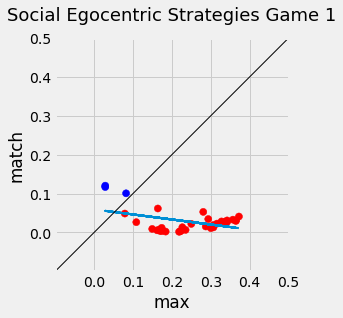

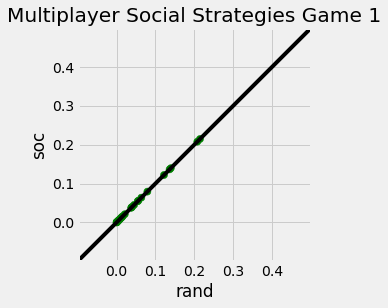

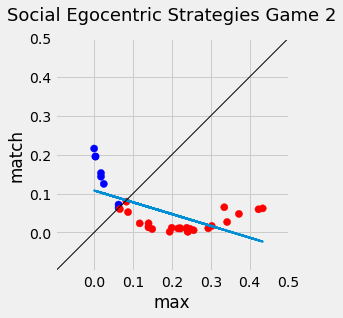

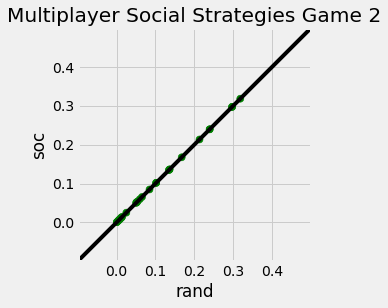

Ttest_relResult(statistic=-1.0233935411920019, pvalue=0.31592322703989784)

In [187]:
# In[ ]:


import itertools


# In[ ]:


#Here I think I tried to create colors for each subject in each condition for use in graphs. I DON'T think this is 
#a good way to do this.'''
#colors_jsd_j = ['red','lightcoral','red','darkred','green','red',
             # 'blue','darkblue','hotblue','blue','purple','plum','peru','saddlebrown','gray','lightgray']
colors_jsd_social_g1_egocentric = ['red','red','red','red','red','red','red',
                        'red','red','red', 'red','red','red','red',
              'red', 'red','red', 'red','red', 'blue','red','red',
                        'red','red','red','red', 'red', 'red','blue', 
                        'blue','red','red','red','red']


colors_jsd_social_g2_egocentric = ['red','red','red','red','red','blue','red',
                        'red','red','red', 'red','red','blue','red',
             'blue', 'red','red', 'red','red', 'blue','red','blue',
                        'red','red','red','blue', 'red', 'red','blue', 
                        'blue','red','red','red','red']


colors_jsd_social_g1_joint = ['green','green','green','green','green','green','green','green'
                              ,'green','green', 'green','green','green','green',
              'green','green','green','green','green','green','green','green','green'
                              ,'green','green','green','green', 'green','green', 
                        'green','green','green','green','green']




colors_jsd_social_g2_joint = ['green','green','green','green','green','green','green','green'
                              ,'green','green', 'green','green','green','green',
              'green','green','green','green','green','green','green','green','green'
                              ,'green','green','green','green', 'green','green', 
                        'green','green','green','green','green']



#markers_jsd = ['o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v'
         # 'o','v','o','v','o','v','o','v']
colors


# In[ ]:


#Here I print the means of the JSD values in each condition, just to see what they are.'''


# In[ ]:


#run t test to see sig between max and match per game
#put in box plot
social_jsd_g1.mean()


# In[ ]:


social_jsd_g2.mean()


# In[ ]:


import matplotlib.patches as mpatches


# # Graphs

# In[ ]:


#Here I try to plot the JSD Values. Continued below under 'JSD with gender.


# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(social_jsd_g1['max'], social_jsd_g1['match'], 1)

social_ego_jsd_g1_plot = social_jsd_g1.plot.scatter(x='max',y='match',s=50,color=colors_jsd_social_g1_egocentric)
plt.title('Social Egocentric Strategies Game 1', fontsize=18, y=1.05)
social_ego_jsd_g1_plot.plot(social_jsd_g1['max'], m*social_jsd_g1['max'] + b, linewidth=2)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)

#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])

line1 = mlines.Line2D([-1, .5],[-1, .5], color='black', linewidth=1)
social_ego_jsd_g1_plot.add_line(line1)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('social_ego_jsd_1.eps',format='eps',bbox_inches='tight',dpi=1000)
plt.show()



# In[ ]:


#under line = matching (closer to 0)
#plots of atual jsd values
social_joint_jsd_g1_plot = social_jsd_g1.plot.scatter(x='rand',y='soc',s=50,color=colors_jsd_social_g1_joint,title='Multiplayer Social Strategies Game 1')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

#make axes equal length
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()


#add legend FIX
#from numpy.random import randn
#z = randn(100)
#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)
#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])



#add line
line1 = mlines.Line2D([-1, .5],[-1, .5], color='black')
social_joint_jsd_g1_plot.add_line(line1)



plt.savefig('social_joint_jsd_1.eps',format='eps',dpi=1000)
plt.show()

# save as jpeg
social_joint_jsd_g1_plot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)


# In[ ]:


#under line = matching (closer to 0)
#plots of actual jsd values

m, b = np.polyfit(social_jsd_g2['max'], social_jsd_g2['match'], 1)

social_ego_jsd_g2_plot = social_jsd_g2.plot.scatter(x='max',y='match',s=50,color=colors_jsd_social_g2_egocentric)
plt.title('Social Egocentric Strategies Game 2', fontsize=18, y=1.05)
social_ego_jsd_g2_plot.plot(social_jsd_g2['max'], m*social_jsd_g2['max'] + b, linewidth=2)
plt.xticks(np.arange(0, 1, step=0.1))
plt.yticks(np.arange(0, 1, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

#plt.xlabel('Match')
#plt.ylabel('Maximize')

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

plt.gca().set_aspect('equal', adjustable='box')
plt.draw()

#add legend (NEEDS TO BE FIXED)
from numpy.random import randn

z = randn(100)

#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)

#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])

line1 = mlines.Line2D([-1, .5],[-1, .5], color='black', linewidth=1)
social_ego_jsd_g2_plot.add_line(line1)

#s_jsd_g2_plot.add_line(line2)
plt.savefig('social_ego_jsd_2.eps',format='eps',bbox_inches='tight',dpi=1000)
plt.show()


# In[ ]:


#under line = matching (closer to 0)
#plots of atual jsd values
social_joint_jsd_g2_plot = social_jsd_g2.plot.scatter(x='rand',y='soc',s=50,color=colors_jsd_social_g2_joint,title='Multiplayer Social Strategies Game 2')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

plt.ylim(-.1, .5)
plt.xlim(-.1, .5)

#make axes equal length
plt.gca().set_aspect('equal', adjustable='box')
plt.draw()


#add legend FIX
#from numpy.random import randn
#z = randn(100)
#blue_dot, = plt.plot(z, "bo", markersize=10)
#red_dot, = plt.plot(z, "ro", markersize=10)
#plt.legend([blue_dot, red_dot], ["Maximize", "Match"])



#add line
line1 = mlines.Line2D([-1, .5],[-1, .5], color='black')
social_joint_jsd_g2_plot.add_line(line1)



plt.savefig('social_joint_jsd_2.eps',format='eps',dpi=1000)
plt.show()

# save as jpeg
social_joint_jsd_g2_plot.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)


# # CONTROL (total) scores in G1 and G2

# In[ ]:


#list out all the scores in game 1 by participant
control_scores_1 = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20','c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'control_score_1':
     [s01_p1_g1_score, s03_p1_g1_score, s05_p1_g1_score,
      s06_p1_g1_score, s07_p1_g1_score, s08_p1_g1_score, s09_p1_g1_score, s11_p1_g1_score, s12_p1_g1_score, s15_p1_g1_score, s16_p1_g1_score, s17_p1_g1_score, s19_p1_g1_score, s20_p1_g1_score, c02_p1_g1_score, c03_p1_g1_score,
      c05_p1_g1_score, c06_p1_g1_score, c09_p1_g1_score, c10_p1_g1_score, c11_p1_g1_score, c12_p1_g1_score, c13_p1_g1_score, c14_p1_g1_score, c16_p1_g1_score, c17_p1_g1_score]})
#to prevent an extra column that numbers each row:
control_scores_1.set_index('participant', inplace=True, drop=True)

#print
control_scores_1


# In[ ]:


#list out all the scores in game 2 by participant
control_scores_2 = pd.DataFrame({'participant':['s01', 's03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20','c02', 'c03', 
                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'control_score_2':
        [s01_p1_g2_score, s03_p1_g2_score, s05_p1_g2_score, 
s06_p1_g2_score, s07_p1_g2_score, s08_p1_g2_score, s09_p1_g2_score, s11_p1_g2_score, s12_p1_g2_score, s15_p1_g2_score, s16_p1_g2_score, s17_p1_g2_score, s19_p1_g2_score, s20_p1_g2_score, 
         c02_p1_g2_score, c03_p1_g2_score, c05_p1_g2_score, c06_p1_g2_score, c09_p1_g2_score, c10_p1_g2_score, c11_p1_g2_score, c12_p1_g2_score, c13_p1_g2_score, c14_p1_g2_score, c16_p1_g2_score, c17_p1_g2_score]})

#to prevent an extra column that numbers each row:
control_scores_2.set_index('participant', inplace=True, drop=True)
#s_scores_1 = pd.DataFrame(data = d1)
#s_scores_2 = pd.DataFrame(data = d2)

#print
control_scores_2


# In[ ]:


#merge both games by participant:
control_scores = pd.merge(control_scores_1, control_scores_2, on = 'participant')


# In[ ]:


#label columns
control_scores.columns=['Game 1','Game 2']


# In[ ]:


control_scores


# In[ ]:


control_scores_1_mean = control_scores_1.mean()


# In[ ]:


control_scores_1_mean


# In[ ]:


control_scores_1_std = control_scores_1.std()


# In[ ]:


control_scores_1_std


# In[ ]:


control_scores_2_mean = control_scores_2.mean()


# In[ ]:


control_scores_2_mean


# In[ ]:


control_scores_2_std = control_scores_2.std()


# In[ ]:


control_scores_2_std


# In[ ]:


control_scores_med = control_scores.median()
control_scores_med


# In[ ]:


control_scores_p = sp.stats.ttest_rel(control_scores['Game 1'],control_scores['Game 2'])


# In[ ]:


control_scores_p


# In[ ]:





# # End of SMAB3 analysis

In [188]:
# In[ ]:


#hypothesis: scores lower for same gender pairs: male-male
'''here i compared scores of pairs of mixed gender and same gender pairs. there are a lot of different types of analyses you can
do on the choice data, and you can group the data by demographics, questionnaire responses, etc.'''


# In[ ]:





# In[ ]:


scores_f = pd.DataFrame([j03_p1_g1_score,j03_p1_g2_score,j03_p2_g1_score,j03_p2_g2_score,j04_p1_g1_score,
            j04_p1_g2_score,j04_p2_g1_score,j04_p2_g2_score,j07_p1_g1_score,j07_p1_g2_score,j07_p2_g1_score,
            j07_p2_g2_score,j08_p1_g1_score,j08_p1_g2_score,j08_p2_g1_score,j08_p2_g2_score])


# In[ ]:


scores_mix = pd.DataFrame([j01_p1_g1_score,j01_p1_g2_score,j01_p2_g1_score,j01_p2_g2_score,j02_p1_g1_score,
            j02_p1_g2_score,j02_p2_g1_score,j02_p2_g2_score,j05_p1_g1_score,j05_p1_g2_score,j05_p2_g1_score,
            j05_p2_g2_score,j05_p1_g1_score,j05_p1_g2_score,j05_p2_g1_score,j05_p2_g2_score,j06_p1_g1_score,
            j06_p1_g2_score,j06_p2_g1_score,j06_p2_g2_score])


# In[ ]:


#m_mean=scores_m.mean()
f_mean=scores_f.mean()
mix_mean=scores_mix.mean()


# In[ ]:


#m_mean


# In[ ]:


f_mean


# In[ ]:


mix_mean


# In[ ]:


j_combo = j_combo.sort_values(by=['participant'])


# In[ ]:


#j_combo_bar = j_combo.plot(kind='bar',color=colors)


# In[ ]:


j_score_diff = pd.DataFrame({'participant':['j01_p1','j01_p2','j02_p1','j02_p2','j03_p1','j03_p2','j04_p1','j04_p2',
                                          'j05_p1','j05_p2','j06_p1','j06_p2','j07_p1','j07_p2','j06_p1','j06_p2'], 'score_diff':
     [j01_p1_diff,j01_p2_diff,j02_p1_diff,j02_p2_diff,j03_p1_diff,j03_p2_diff,j04_p1_diff,j04_p2_diff,
     j05_p1_diff,j05_p2_diff,j06_p1_diff,j06_p2_diff,j07_p1_diff,j07_p2_diff,j08_p1_diff,j08_p2_diff]})


# In[ ]:


j_score_diff


# In[ ]:


#impairs learning?


# In[ ]:


#pattern within sessions for score_diff?
#5 ppl did worse second time; joint interfered with learning


# In[ ]:


j_score_diff_mean = j_score_diff['score_diff'].mean()


# In[ ]:


j_score_diff_mean

8.375

In [189]:
# In[ ]:


j01_p1_g1, j01_p1_g2, j01_p2_g1, j01_p2_g2 = separate_df(j01, 'j')
j02_p1_g1, j02_p1_g2, j02_p2_g1, j02_p2_g2 = separate_df(j02, 'j')
j03_p1_g1, j03_p1_g2, j03_p2_g1, j03_p2_g2 = separate_df(j03, 'j')
j04_p1_g1, j04_p1_g2, j04_p2_g1, j04_p2_g2 = separate_df(j04, 'j')
j05_p1_g1, j05_p1_g2, j05_p2_g1, j05_p2_g2 = separate_df(j05, 'j')
j06_p1_g1, j06_p1_g2, j06_p2_g1, j06_p2_g2 = separate_df(j06, 'j')
j07_p1_g1, j07_p1_g2, j07_p2_g1, j07_p2_g2 = separate_df(j07, 'j')
j08_p1_g1, j08_p1_g2, j08_p2_g1, j08_p2_g2 = separate_df(j08, 'j')


# In[ ]:


#social matching


# In[ ]:


j_g2_counts = pd.DataFrame([j01_p1_g2_count, j01_p2_g2_count, j02_p1_g2_count, j02_p2_g2_count, 
                            j03_p1_g2_count, j03_p2_g2_count, j04_p1_g2_count, j04_p2_g2_count,
                           j05_p1_g2_count,j05_p2_g2_count, j06_p1_g2_count, j06_p2_g2_count, j07_p1_g2_count, 
                            j07_p2_g2_count, j08_p1_g2_count, j08_p2_g2_count],
                          index=['j01_p1_g2_count', 'j01_p2_g2_count', 'j02_p1_g2_count', 'j02_p2_g2_count', 
                            'j03_p1_g2_count', 'j03_p2_g2_count', 'j04_p1_g2_count', 'j04_p2_g2_count',
                           'j05_p1_g2_count','j05_p2_g2_count', 'j06_p1_g2_count', 'j06_p2_g2_count', 'j07_p1_g2_count', 
                            'j07_p2_g2_count', 'j08_p1_g2_count', 'j08_p2_g2_count'])


# In[ ]:


j_g2_counts


# In[ ]:


j_60_p = sp.stats.ttest_rel(j_g1_counts.iloc[:,1],j_g2_counts.iloc[:,1])


# In[ ]:


j_60_p


# In[ ]:


j_30_p = sp.stats.ttest_rel(j_g1_counts.iloc[:,0],j_g2_counts.iloc[:,0])


# In[ ]:


j_30_p


# In[ ]:


j_g2_low = np.mean(j_g2_counts.iloc[:,0])
j_g2_med = np.mean(j_g2_counts.iloc[:,1])
j_g2_high = np.mean(j_g2_counts.iloc[:,2])

j_g2_low_std = np.std(j_g2_counts.iloc[:,0])
j_g2_med_std = np.std(j_g2_counts.iloc[:,1])
j_g2_high_std = np.std(j_g2_counts.iloc[:,2])


# In[ ]:


j_g2_low


# In[ ]:


j_g2_med


# In[ ]:


j_g2_high


# In[ ]:


j_g1_counts_bar = j_g1_counts.plot.bar()


# In[ ]:


j_g2_counts_bar = j_g2_counts.plot.bar()


# In[ ]:


j_g1_counts_box = sns.boxplot( 
                 data=j_g1_counts, 
                 width=0.5,
                 palette="pastel")
j_g1_counts_box.axes.set_title("Multiplayer Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="j_g1_counts_box.jpg"

plt.ylim(0, 100)
j_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)


# In[ ]:


j_g2_counts_box = sns.boxplot( 
                 data=j_g2_counts, 
                 width=0.5,
                 palette="pastel")
j_g2_counts_box.axes.set_title("Multiplayer Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="j_g2_counts_box.jpg"

plt.ylim(0, 100)
j_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)


# In[ ]:

/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:52: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/baryosef/anaconda3/lib/python3.7/site-packages/ipykernel_

ValueError: unequal length arrays

# Maximizing and Matching Strategies

In [ ]:
#Here we compare the choice distributions to idealized models of two decision-making strategies: 
#matching and maximizing. Matching would be choosing each each hole proportionally to its reward rate, 
#and maximizing would be always choosing the high reward hole.


# In[ ]:


s_g1_counts


# In[ ]:


s_g1_counts


# In[ ]:


j_g1_counts


# In[ ]:


j_g2_counts


# In[ ]:


#JSD: Jensen Shannon Divergence. Measures the similarity between two probability distributions. Taken from 
#https://urldefense.com/v3/__https://gist.github.com/zhiyzuo/f80e2b1cfb493a5711330d271a228a3d__;!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX94Xg7JRI$ . *Note: probability distributions need to be
#normalized.'''
#parameters: p and q are the two probability distributions to be compared.

def jsd(p, q, base=np.e):
    
    
    #Implementation of pairwise `jsd` based on https://urldefense.com/v3/__https://en.wikipedia.org/wiki/Jensen**BShannon_divergence__;4oCT!!Mih3wA!SwZbl3yG75UWaB_c9Pq_T5wxVHgFZMbUZ5HHf5pZDf119g1JHaZr-dX9SSBIvMc$ 
    # convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    # normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    return sp.stats.entropy(p,m, base=base)/2. +  sp.stats.entropy(q, m, base=base)/2.


# In[ ]:


#Are ppl using a strategy similar to their partner's? This functions calls jsd for p1 and for p2. *UNFINISHED* 
#DO NOT USE.
#calls jsd for p1 and p2 and for p1 and p2 with the mean
#def compare_strat(p1,p2):
    #strat = jsd(p1,p2)
   # comp_1 = jsd(p1,[j_g1_low,j_g1_med,j_g1_high])
    #comp_2 = jsd(p2,[j_g1_low,j_g1_med,j_g1_high])
    #return strat, comp_1, comp_2


# In[ ]:


#Idealized probability distributions to use for comparison. You can change these or add more models.
maximize = [0,0,100]
match = [30/180 * 100,60/180 * 100,50]


# In[ ]:


#This function calls jsd. 
#Input: counts- a player's choice distributions in a particular game (ex. s01_p1_g1_counts)
#Output: maxi- JSD score for the maximizing strategy
        #matchi- JSD score for the matching strategy
def call_jsd(counts):
    maxi = jsd(counts,maximize)
    matchi = jsd(counts,match)
    return maxi,matchi


# In[ ]:


j01_p1_g1_count


# In[ ]:


#Optional: Idealized probability distributions to use for comparison. These assume a social strategy in which the probability
#distributions of both partners in a joint session are averaged (all holes reward at a 60% rate.

social_max = [0, 100, 0]
social_match = [30/180 * 100,30/180 * 100, 30/180 * 100]


# In[ ]:


#Calls jsd with the social distributions.
def call_jsd_social(counts):
    maxi = jsd(counts,social_max)
    matchi = jsd(counts,social_match)
    return maxi,matchi


# In[ ]:


s01_p1_g1_count


# In[ ]:


from scipy import stats


# In[ ]:


#if same, 0
test = jsd(maximize,match)


# In[ ]:


test


# In[ ]:


s01 = 'match'


# In[ ]:


s05_p1_g2_count


# In[ ]:


s05_p1_g2_count = [11,0,89]


# In[ ]:


# some add to 80, some add to 81??
s_g1_counts


# In[ ]:


s_g2_counts

In [ ]:
# In[ ]:


#Call 'call_jsd' for each participant for each game in the single player sessions.
#with 0, put in actual probabilities in brackets

s01_g1_max,s01_g1_match = call_jsd(s01_p1_g1_count)
s01_g2_max,s01_g2_match = call_jsd(s01_p1_g2_count)
s03_g1_max,s03_g1_match = call_jsd(s03_p1_g1_count)
s03_g2_max,s03_g2_match = call_jsd(s03_p1_g2_count)
s05_g1_max,s05_g1_match = call_jsd(s05_p1_g1_count)
s05_g2_max,s05_g2_match = call_jsd(s05_p1_g2_count)
s06_g1_max,s06_g1_match = call_jsd(s06_p1_g1_count)
s06_g2_max,s06_g2_match = call_jsd(s06_p1_g1_count)
s07_g1_max,s07_g1_match = call_jsd(s07_p1_g1_count)
s07_g2_max,s07_g2_match = call_jsd(s07_p1_g2_count)
s08_g1_max,s08_g1_match = call_jsd(s08_p1_g1_count)
s08_g2_max,s08_g2_match = call_jsd(s08_p1_g2_count)
s09_g1_max,s09_g1_match = call_jsd(s09_p1_g1_count)
s09_g2_max,s09_g2_match = call_jsd(s09_p1_g2_count)
s11_g1_max,s11_g1_match = call_jsd(s11_p1_g1_count)
s11_g2_max,s11_g2_match = call_jsd(s11_p1_g2_count)
s12_g1_max,s12_g1_match = call_jsd(s12_p1_g1_count)
s12_g2_max,s12_g2_match = call_jsd(s12_p1_g2_count)
s15_g1_max,s15_g1_match = call_jsd(s15_p1_g1_count)
s15_g2_max,s15_g2_match = call_jsd(s15_p1_g2_count)
s16_g1_max,s16_g1_match = call_jsd(s16_p1_g1_count)
s16_g2_max,s16_g2_match = call_jsd(s16_p1_g2_count)
s17_g1_max,s17_g1_match = call_jsd([0.0, 3.0, 78.0])
s17_g2_max,s17_g2_match = call_jsd([0, 19, 62])
s19_g1_max,s19_g1_match = call_jsd(s19_p1_g1_count)
s19_g2_max,s19_g2_match = call_jsd(s19_p1_g2_count)
s20_g1_max,s20_g1_match = call_jsd(s20_p1_g1_count)
s20_g2_max,s20_g2_match = call_jsd(s20_p1_g2_count)


# In[ ]:


s17_p1_g1_count


# In[ ]:


s17_p1_g2_count


# In[ ]:


#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
s_jsd_g1 = pd.DataFrame({'max':[s01_g1_max,s03_g1_max,s05_g1_max,s06_g1_max,s07_g1_max,s08_g1_max,
                                s09_g1_max, s11_g1_max, s12_g1_max, s15_g1_max, s16_g1_max, s17_g1_max, s19_g1_max, s20_g1_max],
                      'match':[s01_g1_match,s03_g1_match,s05_g1_match
                               ,s06_g1_match,s07_g1_match,s08_g1_match,s09_g1_match, s11_g1_match, s12_g1_match, s15_g1_match, s16_g1_match, s17_g1_match, s19_g1_match, s20_g1_match]},
                        index=['s01', 's03','s05','s06','s07','s08','s09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'])


# In[ ]:


#closer to 0 = closer to that pure strategy
s_jsd_g1


# In[ ]:


#Create a dataframe for single player game 2 jsd scores, with a column for each strategy.'''
s_jsd_g2 = pd.DataFrame({'max':[s01_g2_max,s03_g2_max,s05_g2_max,s06_g2_max,s07_g2_max,s08_g2_max,
                                s09_g2_max, s11_g2_max, s12_g2_max, s15_g2_max, s16_g2_max, s17_g2_max, s19_g2_max, s20_g2_max],
                      'match':[s01_g2_match,s03_g2_match,s05_g2_match
                               ,s06_g2_match,s07_g2_match,s08_g2_match,s09_g2_match, s11_g2_match, s12_g2_match, s15_g2_match, s16_g2_match, s17_g2_match, s19_g2_match, s20_g2_match]},
                        index=['s01', 's03','s05','s06','s07','s08','s09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'])

In [ ]:
# In[ ]:


def check_type(df,*social):
    types = pd.DataFrame(index=['type'])
    for index,row in df.iterrows():
        maxi = row["max"]
        matchi = row["match"]
        print(index,maxi,matchi)
        if maxi < matchi:
            print('maxi')
            types = types.append({'type' : 'maxi'},ignore_index=True)
            #types[index,'type'] = 'max'
            num = maxi
        elif matchi < maxi:
            print('matchi')
            types = types.append({'type' : 'matchi'},ignore_index=True)
            num = matchi
        else:
            types = types.append({'type' : 'neither'},ignore_index=True)
            num = 1
        if social == True:
            if num >= jsd(social_max,social_match):
                types = types.append({'type' : 'neither'},ignore_index=True)
        else:
            if num >= jsd(maximize,match):
                types = types.append({'type' : 'neither'},ignore_index=True)
    return types


# In[ ]:


s_types_g1 = check_type(s_jsd_g1)


# In[ ]:


s_types_g2 = check_type(s_jsd_g2)


# In[ ]:


#add label, make sure in correct order
s_types_g1.drop([0])


# In[ ]:


s_types_g2.drop([0])


# In[ ]:


#how different max and match dists are from eachother
#neither max or match(?)
threshold = jsd(maximize,match)


# In[ ]:


threshold


# In[ ]:


s_jsd_g1


# In[ ]:


s_jsd_g2

In [ ]:
# In[ ]:


#Call 'call_jsd' for each participant for each game in the joint sessions.'''
j01_p1_g1_max,j01_p1_g1_match = call_jsd(j01_p1_g1_count)
j01_p1_g2_max,j01_p1_g2_match = call_jsd(j01_p1_g2_count)
j01_p2_g1_max,j01_p2_g1_match = call_jsd(j01_p2_g1_count)
j01_p2_g2_max,j01_p2_g2_match = call_jsd(j01_p2_g2_count)
j02_p1_g1_max,j02_p1_g1_match = call_jsd(j02_p1_g1_count)
j02_p1_g2_max,j02_p1_g2_match = call_jsd(j02_p1_g2_count)
j02_p2_g1_max,j02_p2_g1_match = call_jsd(j02_p2_g1_count)
j02_p2_g2_max,j02_p2_g2_match = call_jsd(j02_p2_g2_count)
j03_p1_g1_max,j03_p1_g1_match = call_jsd(j03_p1_g1_count)
j03_p1_g2_max,j03_p1_g2_match = call_jsd(j03_p1_g2_count)
j03_p2_g1_max,j03_p2_g1_match = call_jsd(j03_p2_g1_count)
j03_p2_g2_max,j03_p2_g2_match = call_jsd(j03_p2_g2_count)
j04_p1_g1_max,j04_p1_g1_match = call_jsd(j04_p1_g1_count)
j04_p1_g2_max,j04_p1_g2_match = call_jsd(j04_p1_g2_count)
j04_p2_g1_max,j04_p2_g1_match = call_jsd(j04_p2_g1_count)
j04_p2_g2_max,j04_p2_g2_match = call_jsd(j04_p2_g2_count)
j05_p1_g1_max,j05_p1_g1_match = call_jsd(j05_p1_g1_count)
j05_p1_g2_max,j05_p1_g2_match = call_jsd(j05_p1_g2_count)
j05_p2_g1_max,j05_p2_g1_match = call_jsd(j05_p2_g1_count)
j05_p2_g2_max,j05_p2_g2_match = call_jsd(j05_p2_g2_count)
j06_p1_g1_max,j06_p1_g1_match = call_jsd(j06_p1_g1_count)
j06_p1_g2_max,j06_p1_g2_match = call_jsd(j06_p1_g2_count)
j06_p2_g1_max,j06_p2_g1_match = call_jsd(j06_p2_g1_count)
j06_p2_g2_max,j06_p2_g2_match = call_jsd(j06_p2_g2_count)
j07_p1_g1_max,j07_p1_g1_match = call_jsd(j07_p1_g1_count)
j07_p1_g2_max,j07_p1_g2_match = call_jsd(j07_p1_g2_count)
j07_p2_g1_max,j07_p2_g1_match = call_jsd(j07_p2_g1_count)
j07_p2_g2_max,j07_p2_g2_match = call_jsd(j07_p2_g2_count)
j08_p1_g1_max,j08_p1_g1_match = call_jsd(j08_p1_g1_count)
j08_p1_g2_max,j08_p1_g2_match = call_jsd(j08_p1_g2_count)
j08_p2_g1_max,j08_p2_g1_match = call_jsd(j08_p2_g1_count)
j08_p2_g2_max,j08_p2_g2_match = call_jsd(j08_p2_g2_count)
j10_p1_g1_max,j10_p1_g1_match = call_jsd(j10_p1_g1_count)
j10_p1_g2_max,j10_p1_g2_match = call_jsd(j10_p1_g2_count)
j10_p2_g1_max,j10_p2_g1_match = call_jsd(j10_p2_g1_count)
j10_p2_g2_max,j10_p2_g2_match = call_jsd(j10_p2_g2_count)
j11_p1_g1_max,j11_p1_g1_match = call_jsd([0,6,74])
j11_p1_g2_max,j11_p1_g2_match = call_jsd([0,6,74])
j11_p2_g1_max,j11_p2_g1_match = call_jsd([0,6,74])
j11_p2_g2_max,j11_p2_g2_match = call_jsd([0,6,74])


# In[ ]:


#Create a dataframe for joint game 1 jsd scores, with a column for each strategy.'''
j_jsd_g1 = pd.DataFrame({'max':[j01_p1_g1_max,j01_p2_g1_max,j02_p1_g1_max,j02_p2_g1_max,j03_p1_g1_max,j03_p2_g1_max,
                             j04_p1_g1_max,j04_p2_g1_max,j05_p1_g1_max,j05_p2_g1_max,j06_p1_g1_max,j06_p2_g1_max,
                             j07_p1_g1_max,j07_p2_g1_max,j08_p1_g1_max,j08_p2_g1_max,j10_p1_g1_max,j10_p2_g1_max,
                               j11_p1_g1_max, j11_p2_g1_max],
                      'match':[j01_p1_g1_match,j01_p2_g1_match,j02_p1_g1_match,
                               j02_p2_g1_match,j03_p1_g1_match,j03_p2_g1_match,
                               j04_p1_g1_match,j04_p2_g1_match,j05_p1_g1_match,
                               j05_p2_g1_match,j06_p1_g1_match,j06_p2_g1_match,
                               j07_p1_g1_match,j07_p2_g1_match,j08_p1_g1_match,j08_p2_g1_match, j10_p1_g1_match,
                              j10_p2_g1_match, j11_p1_g1_match, j11_p2_g1_match]}, 
                        index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04', 'j04','j05', 'j05',
                               'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11'])


# In[ ]:


#Create a dataframe for joint game 2 jsd scores, with a column for each strategy.'''
j_jsd_g2 = pd.DataFrame({'max':[j01_p1_g2_max,j01_p2_g2_max,j02_p1_g2_max,j02_p2_g2_max,j03_p1_g2_max,j03_p2_g2_max,
                             j04_p1_g2_max,j04_p2_g2_max,j05_p1_g2_max,j05_p2_g2_max,j06_p1_g2_max,j06_p2_g2_max,
                             j07_p1_g2_max,j07_p2_g2_max,j08_p1_g2_max,j08_p2_g2_max,j10_p1_g2_max,j10_p2_g2_max,
                               j11_p1_g2_max, j11_p2_g2_max],
                      'match':[j01_p1_g2_match,j01_p2_g2_match,j02_p1_g2_match,
                               j02_p2_g2_match,j03_p1_g2_match,j03_p2_g2_match,
                               j04_p1_g2_match,j04_p2_g2_match,j05_p1_g2_match,
                               j05_p2_g2_match,j06_p1_g2_match,j06_p2_g2_match,
                               j07_p1_g2_match,j07_p2_g2_match,j08_p1_g2_match,j08_p2_g2_match,j10_p1_g2_match,
                              j10_p2_g2_match, j11_p1_g2_match, j11_p2_g2_match]}, 
                        index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04', 'j04','j05', 'j05',
                               'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11'])


# In[ ]:


j_types_g1 = check_type(j_jsd_g1)


# In[ ]:


j_types_g2 = check_type(j_jsd_g2)


# In[ ]:


j_types_g1.drop([0])


# In[ ]:


j_types_g2.drop([0])


# In[ ]:


j_jsd_g1


# In[ ]:


j_jsd_g2


# In[ ]:


#same for joint using "social"

In [ ]:
# In[ ]:


#Call 'call_jsd_social' for each participant for each game in the joint sessions.'''
j01_p1_g1_max,j01_p1_g1_match = call_jsd_social(j01_p1_g1_count)
j01_p1_g2_max,j01_p1_g2_match = call_jsd_social(j01_p1_g2_count)
j01_p2_g1_max,j01_p2_g1_match = call_jsd_social(j01_p2_g1_count)
j01_p2_g2_max,j01_p2_g2_match = call_jsd_social(j01_p2_g2_count)
j02_p1_g1_max,j02_p1_g1_match = call_jsd_social(j02_p1_g1_count)
j02_p1_g2_max,j02_p1_g2_match = call_jsd_social(j02_p1_g2_count)
j02_p2_g1_max,j02_p2_g1_match = call_jsd_social(j02_p2_g1_count)
j02_p2_g2_max,j02_p2_g2_match = call_jsd_social(j02_p2_g2_count)
j03_p1_g1_max,j03_p1_g1_match = call_jsd_social(j03_p1_g1_count)
j03_p1_g2_max,j03_p1_g2_match = call_jsd_social(j03_p1_g2_count)
j03_p2_g1_max,j03_p2_g1_match = call_jsd_social(j03_p2_g1_count)
j03_p2_g2_max,j03_p2_g2_match = call_jsd_social(j03_p2_g2_count)
j04_p1_g1_max,j04_p1_g1_match = call_jsd_social(j04_p1_g1_count)
j04_p1_g2_max,j04_p1_g2_match = call_jsd_social(j04_p1_g2_count)
j04_p2_g1_max,j04_p2_g1_match = call_jsd_social(j04_p2_g1_count)
j04_p2_g2_max,j04_p2_g2_match = call_jsd_social(j04_p2_g2_count)
j05_p1_g1_max,j05_p1_g1_match = call_jsd_social(j05_p1_g1_count)
j05_p1_g2_max,j05_p1_g2_match = call_jsd_social(j05_p1_g2_count)
j05_p2_g1_max,j05_p2_g1_match = call_jsd_social(j05_p2_g1_count)
j05_p2_g2_max,j05_p2_g2_match = call_jsd_social(j05_p2_g2_count)
j06_p1_g1_max,j06_p1_g1_match = call_jsd_social(j06_p1_g1_count)
j06_p1_g2_max,j06_p1_g2_match = call_jsd_social(j06_p1_g2_count)
j06_p2_g1_max,j06_p2_g1_match = call_jsd_social(j06_p2_g1_count)
j06_p2_g2_max,j06_p2_g2_match = call_jsd_social(j06_p2_g2_count)
j07_p1_g1_max,j07_p1_g1_match = call_jsd_social(j07_p1_g1_count)
j07_p1_g2_max,j07_p1_g2_match = call_jsd_social(j07_p1_g2_count)
j07_p2_g1_max,j07_p2_g1_match = call_jsd_social(j07_p2_g1_count)
j07_p2_g2_max,j07_p2_g2_match = call_jsd_social(j07_p2_g2_count)
j08_p1_g1_max,j08_p1_g1_match = call_jsd_social(j08_p1_g1_count)
j08_p1_g2_max,j08_p1_g2_match = call_jsd_social(j08_p1_g2_count)
j08_p2_g1_max,j08_p2_g1_match = call_jsd_social(j08_p2_g1_count)
j08_p2_g2_max,j08_p2_g2_match = call_jsd_social(j08_p2_g2_count)
j10_p1_g1_max,j10_p1_g1_match = call_jsd_social(j10_p1_g1_count)
j10_p1_g2_max,j10_p1_g2_match = call_jsd_social(j10_p1_g2_count)
j10_p2_g1_max,j10_p2_g1_match = call_jsd_social(j10_p2_g1_count)
j10_p2_g2_max,j10_p2_g2_match = call_jsd_social(j10_p2_g2_count)
j11_p1_g1_max,j11_p1_g1_match = call_jsd_social(j11_p1_g1_count)
j11_p1_g2_max,j11_p1_g2_match = call_jsd_social(j11_p1_g2_count)
j11_p2_g1_max,j11_p2_g1_match = call_jsd_social(j11_p2_g1_count)
j11_p2_g2_max,j11_p2_g2_match = call_jsd_social(j11_p2_g2_count)


# In[ ]:


#Create a dataframe for joint game 1 social jsd scores, with a column for each strategy.'''
j_jsd_g1_social = pd.DataFrame({'max':[j01_p1_g1_max,j01_p2_g1_max,j02_p1_g1_max,j02_p2_g1_max,j03_p1_g1_max,j03_p2_g1_max,
                             j04_p1_g1_max,j04_p2_g1_max,j05_p1_g1_max,j05_p2_g1_max,j06_p1_g1_max,j06_p2_g1_max,
                             j07_p1_g1_max,j07_p2_g1_max,j08_p1_g1_max,j08_p2_g1_max, j10_p2_g1_max,
                               j11_p1_g1_max, j11_p2_g1_max],
                      'match':[j01_p1_g1_match,j01_p2_g1_match,j02_p1_g1_match,
                               j02_p2_g1_match,j03_p1_g1_match,j03_p2_g1_match,
                               j04_p1_g1_match,j04_p2_g1_match,j05_p1_g1_match,
                               j05_p2_g1_match,j06_p1_g1_match,j06_p2_g1_match,
                               j07_p1_g1_match,j07_p2_g1_match,j08_p1_g1_match,j08_p2_g1_match, j10_p1_g1_match,
                              j10_p2_g1_match, j11_p1_g1_match, j11_p2_g1_match]}, 
                        index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04', 'j04','j05', 'j05',
                               'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11'])


# In[ ]:


#Create a dataframe for joint game 2 social jsd scores, with a column for each strategy.'''
j_jsd_g2_social = pd.DataFrame({'max':[j01_p1_g2_max,j01_p2_g2_max,j02_p1_g2_max,j02_p2_g2_max,j03_p1_g2_max,j03_p2_g2_max,
                             j04_p1_g2_max,j04_p2_g2_max,j05_p1_g2_max,j05_p2_g2_max,j06_p1_g2_max,j06_p2_g2_max,
                             j07_p1_g2_max,j07_p2_g2_max,j08_p1_g2_max,j08_p2_g2_max],
                      'match':[j01_p1_g2_match,j01_p2_g2_match,j02_p1_g2_match,
                               j02_p2_g2_match,j03_p1_g2_match,j03_p2_g2_match,
                               j04_p1_g2_match,j04_p2_g2_match,j05_p1_g2_match,
                               j05_p2_g2_match,j06_p1_g2_match,j06_p2_g2_match,
                               j07_p1_g2_match,j07_p2_g2_match,j08_p1_g2_match,j08_p2_g2_match]}, 
                        index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04', 'j04','j05', 'j05',
                               'j06', 'j06','j07','j07','j08','j08'])


# In[ ]:


j_jsd_g1_social = check_type(j_jsd_g1_social,True)


# In[ ]:


j_jsd_g2_social = check_type(j_jsd_g2_social,True)


# In[ ]:


#j_jsd_g1_social.drop([0])

j_jsd_g1_social


# In[ ]:


j_jsd_g2_social


# In[ ]:


threshold


# In[ ]:


import matplotlib.lines as mlines


# In[ ]:


#colors_jsd = [['lightcoral','red','lightcoral','red','bisque','orange','bisque','orange','palegreen','green','palegreen','green',
              #'lightblue','blue','lightblue','blue','mediumslateblue','indigo','mediumslateblue','indigo','lightpink','deeppink',
              #'lightpink','deeppink','yellow','gold','yellow','gold','lightgray','gray','lightgray','gray']              


# In[ ]:


import itertools


# In[ ]:


#Here I think I tried to create colors for each subject in each condition for use in graphs. I DON'T think this is 
#a good way to do this.'''
colors_jsd_j = ['red','lightcoral','orange','darkorange','green','palegreen',
              'blue','darkblue','hotpink','pink','purple','plum','peru','saddlebrown','gray','lightgray']
colors_jsd_s_g1 = ['red','orange','green','blue','pink','purple','peru','cyan', 'red','lightcoral','orange','darkorange','green','palegreen',
              'blue']
colors_jsd_s_g2 = ['red','green','blue','pink','purple','peru','cyan', 'red','lightcoral','orange','darkorange','green','palegreen',
              'blue']
markers_jsd = ['o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v'
          'o','v','o','v','o','v','o','v']
colors


# In[ ]:


#Here I print the means of the JSD values in each condition, just to see what they are.'''


# In[ ]:


#run t test to see sig between max and match per game
#put in box plot
s_jsd_g1.mean()


# In[ ]:


s_jsd_g2.mean()


# In[ ]:


j_jsd_g1.mean()


# In[ ]:


j_jsd_g2.mean()


# In[ ]:


import matplotlib.patches as mpatches


# In[ ]:


#create proxy artist for legend
patches = []
for index,row in j_jsd_g1.iterrows():
    for i in colors_jsd_j:
        patches.append(mpatches.Patch(color=i, label=index))


# # legend not working

# In[ ]:


#Here I try to plot the JSD Values. Continued below under 'JSD with gender.


# In[ ]:


#j_jsd_plot = j_jsd.plot.scatter(x='max',y='match',title='Multi Player JSD Values')
#line = mlines.Line2D([0.2148, 0], [0.2148, 1], color='red')
#j_jsd_plot.add_line(line)
#plt.show()
#fig, j_jsd_g1_plot = plt.subplots()

j_jsd_g1_plot = j_jsd_g1.plot.scatter(x='max',y='match',s=100,c=colors_jsd_j,title='Multiplayer JSD Values Game 1')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])
#line2 = mlines.Line2D([0, 0.4],[0.2148, 0.2148], color='red')


line2 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
line3 = mlines.Line2D([-0.03,0.8],[0.2148,0.2148])

#transform = ax.transAxes
#line2 doesn't show up; all below it?
#line.set_transform(transform)
j_jsd_g1_plot.add_line(line1)
#j_jsd_g1_plot.add_line(line2)
#j_jsd_g1_plot.add_line(line3)

#plt.legend(handles=patches)
plt.savefig('j_jsd_1.eps',format='eps',dpi=1000)
plt.show()




#color code pairs together


# In[ ]:


#j_jsd_plot = j_jsd.plot.scatter(x='max',y='match',title='Multi Player JSD Values')
#line = mlines.Line2D([0.2148, 0], [0.2148, 1], color='red')
#j_jsd_plot.add_line(line)
#plt.show()
#fig, j_jsd_g2_plot = plt.subplots()


j_jsd_g2_plot = j_jsd_g2.plot.scatter(x='max',y='match',s=100,c=colors_jsd_j,title='Multiplayer JSD Values Game 2')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([-0.03,0.8],[0.2148,0.2148])
#line2 = mlines.Line2D([0, 0.4],[0.2148, 0.2148], color='red')
line1 = mlines.Line2D([-1, 0.4],[-1, 0.4], color='red')
#transform = ax.transAxes
#line2 doesn't show up; all below it?
#line.set_transform(transform)
j_jsd_g2_plot.add_line(line1)
#j_jsd_g2_plot.add_line(line2)
plt.savefig('j_jsd_2.eps',format='eps',dpi=1000)
plt.show()


#color code pairs together


# In[ ]:


#under line = matching (closer to 0)
#plots of atual jsd values
s_jsd_g1_plot = s_jsd_g1.plot.scatter(x='max',y='match',s=100,colors=colors_jsd_s_g2,title='Single Player JSD Values Game 1')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')

s_jsd_g1_plot.add_line(line1)
#s_jsd_g2_plot.add_line(line2)
plt.savefig('s_jsd_2.eps',format='eps',dpi=1000)
plt.show()


# In[ ]:


s_jsd_g2_plot = s_jsd_g2.plot.scatter(x='max',y='match',s=100,colors=colors_jsd_s_g2,title='Single Player JSD Values Game 2')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))

#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')

s_jsd_g2_plot.add_line(line1)
#s_jsd_g2_plot.add_line(line2)
plt.savefig('s_jsd_2.eps',format='eps',dpi=1000)


# In[ ]:


threshold_social = jsd(social_max,social_match)


# In[ ]:


threshold_social


# In[ ]:


j_jsd_g1_social_plot = j_jsd_g1_social.plot.scatter(x='max',y='match',s=100,c=colors_jsd_j,title='Multi Player JSD Social Values Game 1')
plt.xticks(np.arange(0, 0.6, step=0.1))
plt.yticks(np.arange(0, 0.6, step=0.1))
#line1 = mlines.Line2D([0.3183, 0.3183],[-0.03, 0.55], color='red')
#line2 = mlines.Line2D([0, 0.8],[0.3183, 0.3183])
#j_jsd_g1_social_plot.add_line(line1)
#j_jsd_g1_social_plot.add_line(line2)

line1 = mlines.Line2D([0, 0.55],[0, 0.55], color='red')

j_jsd_g1_social_plot.add_line(line1)
plt.savefig('j_jsd_social_1.eps',format='eps',dpi=1000)
#everyone could be classified as a matcher. everyone to the left of the red line could be using both
#NEED TO: color differently those who were more of maximizers than matchers!!!


# In[ ]:


j_jsd_g2_social_plot = j_jsd_g2_social.plot.scatter(x='max',y='match',s=100,colors=colors_jsd_j,title='Multi Player JSD Social Values Game 2')
plt.xticks(np.arange(0, 0.6, step=0.1))
plt.yticks(np.arange(0, 0.6, step=0.1))
line1 = mlines.Line2D([0, 0.55],[0, 0.55], color='red')

j_jsd_g2_social_plot.add_line(line1)
plt.savefig('j_jsd_social_2.eps',format='eps',dpi=1000)


# ### NOT WORKING
# def check_type_3(row):
#         maxi = row["max"]
#         matchi = row["match"]
#         if maxi < matchi:
#             row['type'] = 'max'
#             num = maxi
#         elif matchi < maxi:
#             row['type'] = 'match'
#             num = matchi
#         else:
#             row['type'] = 'neither'
#         if num >= jsd(maximize,match):
#             row['type'] = 'neither'
#             
# def check_type_2(df):
#     for row in df.itertuples(index=True, name='Pandas'):
#         print(index,row["max"],row["match"])
#         if row["match"] < row["max"] and row["match"] < jsd(maximize,match):
#             df.at[index,'type'] = 'match'
#         elif row["max"] < row["match"] and row["max"] < jsd(maximize,match):
#             df.at[index,'type'] = 'max'
#         else:
#             df.at[index,'type'] = 'neither'

# # Gender Diff

# In[ ]:


#load from CSV file
reader = csv.reader( open('gender.csv'))
data = [row for row in reader]
gender = pd.DataFrame(np.array(data))
gender = gender.rename(columns = {0:"participant", 1:"gender "})
gender_s = gender.iloc[16:,:]
gender_j = gender.iloc[:16,:]
gender_s.drop([19])


# In[ ]:


gender_s


# In[ ]:


gender_j


# In[ ]:


gender_s = gender_s.merge(s_scores_1,on='participant')


# In[ ]:


gender_s = gender_s.merge(s_scores_2,on='participant')


# In[ ]:


gender_s
#gender_s.drop(['score'],axis=1)


# In[ ]:


gender_s = gender_s.merge(score_diff,on='participant')


# In[ ]:


gender_s


# In[ ]:


#gender_s_m = gender_s.gender == "male"
#gender_s['score_x'].mean()


# In[ ]:


j_scores_1['participant'] = ['j01a','j01b','j02a','j02b','j03a','j03b','j04a','j04b','j05a','j05b','j06a','j06b',
                             'j07a','j07b',
                            'j08a','j08b']
j_scores_2['participant'] = ['j01a','j01b','j02a','j02b','j03a','j03b','j04a','j04b','j05a','j05b','j06a','j06b',
                             'j07a','j07b',
                            'j08a','j08b']


# In[ ]:


j_score_diff['participant'] = ['j01a','j01b','j02a','j02b','j03a','j03b','j04a','j04b','j05a','j05b','j06a','j06b',
                             'j07a','j07b',
                            'j08a','j08b']


# In[ ]:


j_score_diff


# In[ ]:


gender_j = gender_j.merge(j_scores_1,on='participant')
#gender_j = gender_j.merge(j_scores_2,on='participant')
#gender_j = gender_j.merge(j_score_diff,on='participant')


# In[ ]:


gender_j


# In[ ]:


gender_j = gender_j.merge(j_scores_2,on='participant')


# In[ ]:


gender_j


# In[ ]:


gender_j = gender_j.merge(j_score_diff,on='participant')


# In[ ]:


gender_j

In [ ]:
# In[ ]:


#don't remove first 20 trials
def organize_trial_by_trial_all(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward", 6:"time", 7:"P1 score", 8:"P2 score"})
    #df = df[40:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    df = df.apply(pd.to_numeric)
    df.head()
    
    #combining info in the same trial for both players together in the same row
    #player1 = df[df['player'] == 1].drop(columns = "P2 score").drop(columns = "player")
    #player1 = player1.reset_index().drop(columns = "index")
    #player1 = player1.rename(columns = {"arm":"P1 arm", "probability":"P1 prob", "reward":"P1 reward"})

    #player2 = df[df['player'] == 2].drop(columns = "P1 score").drop(columns = 'trial').drop(columns = 'player')
    #player2 = player2.reset_index().drop(columns = "index")
    #player2 = player2.rename(columns = {"arm":"P2 arm", "probability":"P2 prob", "reward":"P2 reward"})

    #result = pd.concat([player1, player2], axis=1, sort=False)
    return df


# In[ ]:


#don't remove first 20 trials
#separate data frames for p1 and p2 
def separate_df(df, version):
    #df.set_index(df['trial'])
    df_p1 = df[df['player'] == 1]
    df_p1_g1 = df_p1[df['game number'] == 1]
    df_p1_g2 = df_p1[df['game number'] == 2]
    #remove first 20 trials for g2
    #df_p1_g2 = df_p1_g2[20:]
    if version == 's':
        return df_p1_g1, df_p1_g2
    df_p2 = df[df['player'] ==2 ]
    df_p2_g1 = df_p2[df['game number'] == 1]
    df_p2_g2 = df_p2[df['game number'] == 2]
    return df_p1_g1, df_p1_g2, df_p2_g1, df_p2_g2


# In[ ]:


import glob,os


# In[ ]:


for filename in glob.iglob('/data/**', recursive=True):
    if os.path.isfile(filename): # filter dirs
        filename = organize_trial_by_trial_all(filename)


# # jsd with gender

# In[ ]:


colors_jsd_s_g1=['b','b','r','b','b','r','r','r']
colors_jsd_s_g2=['b','r','b','b','r','r','r']


# In[ ]:


s_jsd_g1_plot = s_jsd_g1.plot.scatter(x='max',y='match',s=100,colors=colors_jsd_s_g1,title='Single Player JSD Values Game 1')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')

s_jsd_g1_plot.add_line(line1)
#s_jsd_g1_plot.add_line(line2)
plt.savefig('s_jsd_1.eps',format='eps',dpi=1000)
plt.show()


# In[ ]:


s_jsd_g2_plot = s_jsd_g2.plot.scatter(x='max',y='match',s=100,colors=colors_jsd_s_g2,title='Single Player JSD Values Game 2')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')

s_jsd_g1_plot.add_line(line1)
#s_jsd_g1_plot.add_line(line2)
plt.savefig('s_jsd_1.eps',format='eps',dpi=1000)
plt.show()


# In[ ]:


colors_jsd_j = ['purple','green','green','purple','r','r','r','r','purple','green','green','purple','r','r','r','r']


# In[ ]:


#fig, j_jsd_g1_plot = plt.subplots()
j_jsd_g1_plot = j_jsd_g1.plot.scatter(x='max',y='match',s=100,c=colors_jsd_j,title='Multiplayer JSD Values Game 1')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])
#line2 = mlines.Line2D([0, 0.4],[0.2148, 0.2148], color='red')

line2 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
line3 = mlines.Line2D([-0.03,0.8],[0.2148,0.2148])

#transform = ax.transAxes
#line2 doesn't show up; all below it?
#line.set_transform(transform)
j_jsd_g1_plot.add_line(line1)
#j_jsd_g1_plot.add_line(line2)
#j_jsd_g1_plot.add_line(line3)

#plt.legend(handles=patches)
plt.savefig('j_jsd_1.eps',format='eps',dpi=1000)
plt.show()


# In[ ]:


#fig, j_jsd_g1_plot = plt.subplots()
j_jsd_g2_plot = j_jsd_g2.plot.scatter(x='max',y='match',s=100,c=colors_jsd_j,title='Multiplayer JSD Values Game 2')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')


line2 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
line3 = mlines.Line2D([-0.03,0.8],[0.2148,0.2148])


j_jsd_g2_plot.add_line(line1)


#plt.legend(handles=patches)
plt.savefig('j_jsd_2.eps',format='eps',dpi=1000)
plt.show()


# In[ ]: